In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd
plt.style.use('../styles/general.mplstyle')

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
from numba import njit
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} + V_{off} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [57]:
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c
        
@njit
def calculate_cicle(t,v_c, v_rev, x):
    #c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h, v_off = x
    

    c_p, c_m, a0_m, b0_m, s_m_1, s_m_2, a0_h, b0_h, s_h_1, s_h_2,a0_j,b0_j,s_j_1,s_j_2, r_m, \
    r_p, g_max, g_leak,v_half_m, v_half_h, k_m, k_h,tau_z, v_off = x
    
    #alpha_m = np.zeros_like(t)
    #beta_m = np.zeros_like(t)
    #alpha_h = np.zeros_like(t)
    #beta_h = np.zeros_like(t)
    
    tau_m = np.zeros_like(t)
    tau_h = np.zeros_like(t)
    tau_j = np.zeros_like(t)
    
    m_inf = np.zeros_like(t)
    h_inf = np.zeros_like(t)
    
    v_p = np.zeros_like(t)
    v_m = np.zeros_like(t)
    
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    j = np.zeros_like(t)
    
    I_leak = np.zeros_like(t)
    I_Na = np.zeros_like(t)
    
    v_p[0] = -80
    v_m[0] = -80
    m_inf[0] = 0
    h_inf[0] = 1
    m[0] = 0
    h[0] = 1
    n_step = len(t)
    
    dt = t[1] - t[0]
    I_leak[0] = g_leak * v_m[0]
    #I_Na[0] = g_max * h[0] * (m[0]**3) * (v_m[0] - v_rev)
    for i in range(1, n_step):
        v_p[i] = v_c[i-1] + (v_p[i-1] - v_c[i-1])*np.exp(-dt / (r_p * c_p))
        v_m[i] = v_m[i-1] + (v_p[i-1]+ v_off - v_m[i-1])*dt / (r_m * c_m) - 1e-9 * (I_Na[i-1]+I_leak[i-1])*dt/c_m 
        
        #alpha_m  = a0_m * np.exp(-delta_m * v_m[i-1] / (-s_m)) 
        #beta_m = b0_m * np.exp((1-delta_m) * v_m[i-1] / (-s_m))
        alpha_m  = a0_m * np.exp(v_m[i-1] / s_m_1) 
        beta_m = b0_m * np.exp(-v_m[i-1] / s_m_2)
        
        #alpha_h  = a0_h * np.exp(-delta_h * v_m[i-1] / s_h) 
        #beta_h = b0_h * np.exp((1-delta_h) * v_m[i-1] / s_h)
        alpha_h  = a0_h * np.exp(v_m[i-1] / s_h_1) 
        beta_h = b0_h * np.exp(-v_m[i-1] / s_h_2)
        
        alpha_j  = a0_j * np.exp(v_m[i-1] / s_j_1) 
        beta_j = b0_j * np.exp(-v_m[i-1] / s_j_2)
        
        
        tau_m[i-1] = 1e-3 / (beta_m + alpha_m)
        tau_h[i-1] = 1e-3 / (beta_h + alpha_h)
        tau_j[i-1] = 1e-3 / (beta_j + alpha_j)
         

        #m_inf = 1/(1+beta_m/alpha_m)
        #h_inf = 1/(1+beta_h/alpha_h)

        m_inf[i] = 1 / (1 + np.exp((- (v_half_m + v_m[i]) / k_m)))
        h_inf[i] = 1 / (1 + np.exp((v_half_h + v_m[i]) / k_h))
        
        m[i] = m_inf[i-1] + (m[i-1] - m_inf[i-1]) * np.exp(-dt/tau_m[i-1])
        h[i] = h_inf[i-1] + (h[i-1] - h_inf[i-1]) * np.exp(-dt/tau_h[i-1])
        j[i] = h_inf[i-1] + (j[i-1] - h_inf[i-1]) * np.exp(-dt/tau_j[i-1])
        

        
        I_leak[i] = g_leak * v_m[i]
        I_Na[i] = g_max * j[i] * h[i] * (m[i]**3) * (v_m[i] - v_rev)
    
    tau_m[-1] = 1e-3 / (a0_m * np.exp(v_m[-1] / s_m_1)
                          + b0_m * np.exp(-v_m[-1] / s_m_2))
    tau_h[-1] = 1e-3 / (a0_h * np.exp(v_m[-1] / s_h_1)
                          + b0_h * np.exp(-v_m[-1] / s_h_2))
    tau_j[-1] = 1e-3 / (a0_j * np.exp(v_m[-1] / s_j_1)
                          + b0_j * np.exp(-v_m[-1] / s_j_2))

    return m_inf, h_inf, tau_m, tau_h, v_p, v_m, I_leak, I_Na



def calculate_I_out(x, *args):#, s0, c, protocol, ...):
    y = x.copy()
    kwargs = args[-1]
    
    t = kwargs['t']
    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    if kwargs.get('log_scale', False):
        y[:-1] = np.exp(y[:-1])
        #print(y[:-1])
        #y = np.exp(y)
        assert np.all(y[:-1] > 0) 
    
    
    #c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, r_m, r_p, g_max, g_leak\
    #, v_half_m, v_half_h, k_m, k_h, v_off = y 
    
    c_p, c_m, a0_m, b0_m, s_m_1, s_m_2, a0_h, b0_h, s_h_1, s_h_2,a0_j,b0_j,s_j_1,s_j_2, r_m, \
    r_p, g_max, g_leak,v_half_m, v_half_h, k_m, k_h,tau_z, v_off = y 
    #print(y)
    # constructing v_c - command potential

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count) 
    
    
    v_c = np.zeros_like(t)
    v_c = v_list[count.astype(int)]
    v_rev =18
    
    I_out = np.zeros_like(t)
    try:
        m_inf, h_inf, tau_m, tau_h, v_p, v_m, I_leak, I_Na = calculate_cicle(t,v_c, v_rev,y)
    except ZeroDivisionError:
        I_out+=1e100
        return I_out
        #print('ok')
    #I_p = np.zeros_like(t)
    #I_c = np.zeros_like(t)
    #print(np.diff(v_m)[:2])
    #I_c= np.zeros_like(t)
    #I_p= np.zeros_like(t)
    I_c = 1e9 * c_m * np.diff(v_m) / dt
    I_p = 1e9 * c_p * np.diff(v_p) / dt
    I_c = np.concatenate((I_c,I_c[-1:]))
    I_p = np.concatenate((I_p,I_p[-1:]))
    
    #tau_z = 5e-4 # 1e-12 * 5e8
    
    I_in = I_c  + I_leak + I_Na + I_p
    
    I_out[0] = I_in[0]
    #rush_larsen_easy_numba_helper(I_out,I_in,-dt / tau_z)
    euler_numba_helper(I_out,I_in,(dt / tau_z))  
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        
        plt.plot(v_c, label = 'command_prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v_m, label = 'membrane')
        plt.legend()
        
        v_graph = np.arange(-95,35)
        
        plt.figure()
        m_graph = 1 / (1 + np.exp((- v_half_m - v_graph) / k_m))
        h_graph = 1 / (1 + np.exp((v_half_h + v_graph) / k_h))
        plt.plot(v_graph, m_graph**3, label = 'm_inf')
        plt.plot(v_graph, h_graph, label = 'h_inf')
        plt.legend()
        
        plt.figure() 
        tau_m_graph = 1e-3 / (a0_m * np.exp(v_graph  / s_m_1)
                          + b0_m * np.exp(-v_graph  / s_m_2))
        tau_h_graph = 1e-3 / (a0_h * np.exp(v_graph  / s_h_1)
                          + b0_h * np.exp(-v_graph  / s_h_2))
        tau_j_graph = 1e-3 / (a0_j * np.exp(v_graph  / s_j_1)
                          + b0_j * np.exp(-v_graph  / s_j_2))
        plt.plot(v_graph, tau_m_graph, label = 'tau_m')
        plt.plot(v_graph, tau_h_graph, label = 'tau_h')
        plt.plot(v_graph, tau_j_graph, label = 'tau_j')
        plt.legend()

        plt.figure()
        plt.plot(I_c, label = 'I_c')
        plt.plot(I_p, label = 'I_p')
        plt.plot(I_leak, label = 'I_leak')
        plt.plot(I_Na, label = 'I_Na')
        plt.legend()
        
        plt.figure()
        plt.plot(I_in, label = 'I_in')
        plt.plot(I_out, label = 'I_out')
        plt.legend()
        
    return I_out


In [58]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])
t = np.load('../data/time.npy')
t_all = np.concatenate([t for k in range(20)])


In [59]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

In [60]:

def log_x(a):
    b = a.copy()
    b[2:10] = np.log(a[2:10])
    b[14:18] = np.log(a[14:18])
    return(b)


In [61]:
V = np.arange(-100,20)

print('b0_j = ' , (0.02136 *np.exp(-(+100.6)/8.281)))
print('a0_j = ', 0.3052 * np.exp((+0.9941)/38.45))

b0_j =  1.1315282095590092e-07
a0_j =  0.3131936394738773


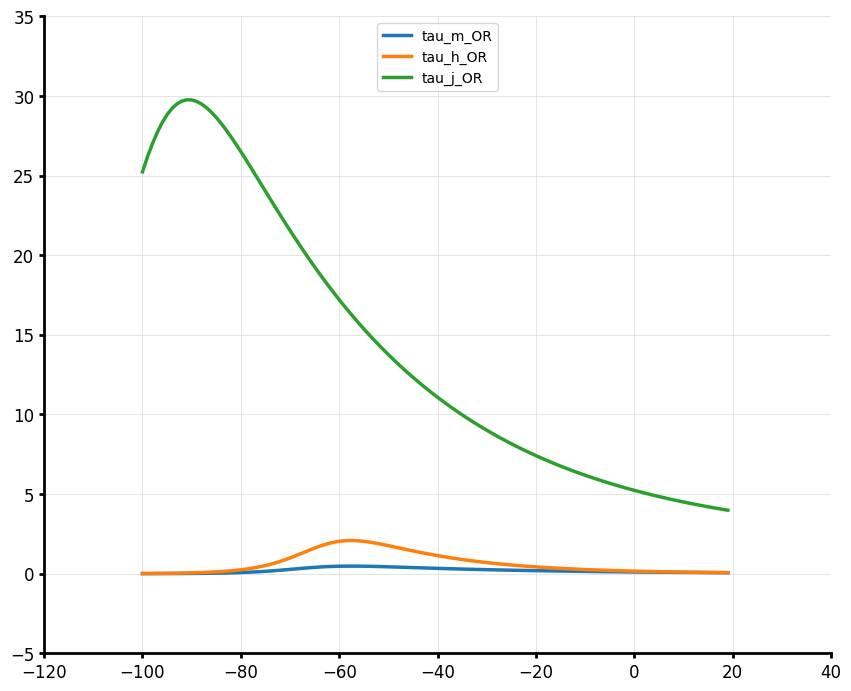

In [68]:
#Ohara-Rudy
m_inf_OR = 1/(1+np.exp(-(V+39.57)/9.871))
tau_m_OR = 1/(6.765*np.exp((V+11.64)/34.77) + 8.552 * np.exp(-(V+77.42)/5.955))

h_inf_OR = 1/(1+np.exp((V+82.9)/6.086))
tau_h_fast_OR = 1/(1.432e-5*np.exp(-(V+1.196)/6.285) + 6.149 * np.exp((V+0.5096)/20.27))
tau_h_slow_OR = 1/(0.009764*np.exp(-(V+17.95)/28.05) + 0.3343 * np.exp((V+0.5730)/56.66))
tau_j_OR = 2.038 + 1/(0.02136 *np.exp(-(V+100.6)/8.281)+0.3052 * np.exp((V+0.9941)/38.45))

#plt.plot(V, m_inf_OR)
#plt.plot(V, h_inf_OR)
plt.plot(V, tau_m_OR, label = 'tau_m_OR')
plt.plot(V, tau_h_fast_OR, label = 'tau_h_OR')
plt.plot(V, tau_j_OR, label = 'tau_j_OR')
plt.legend()

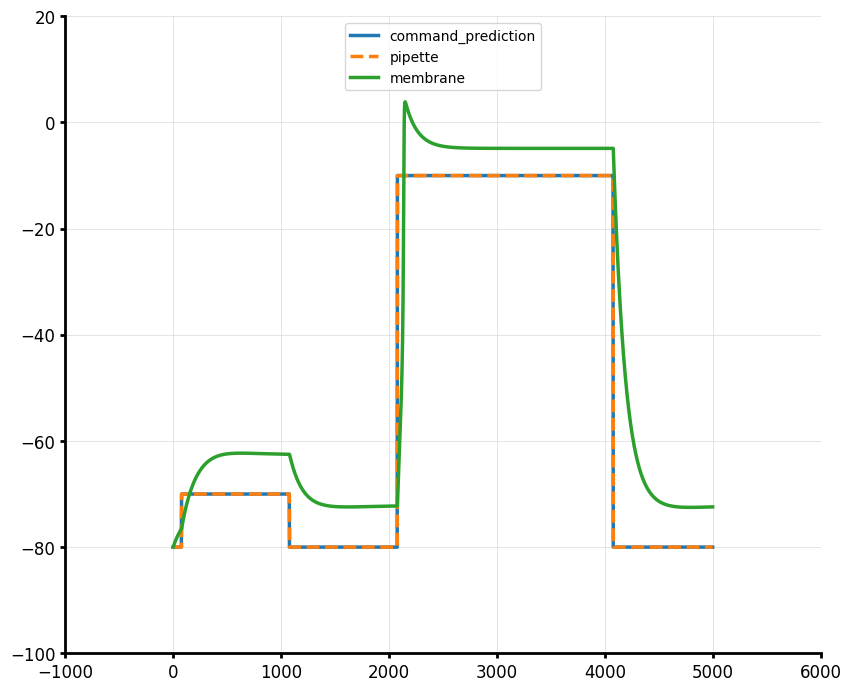

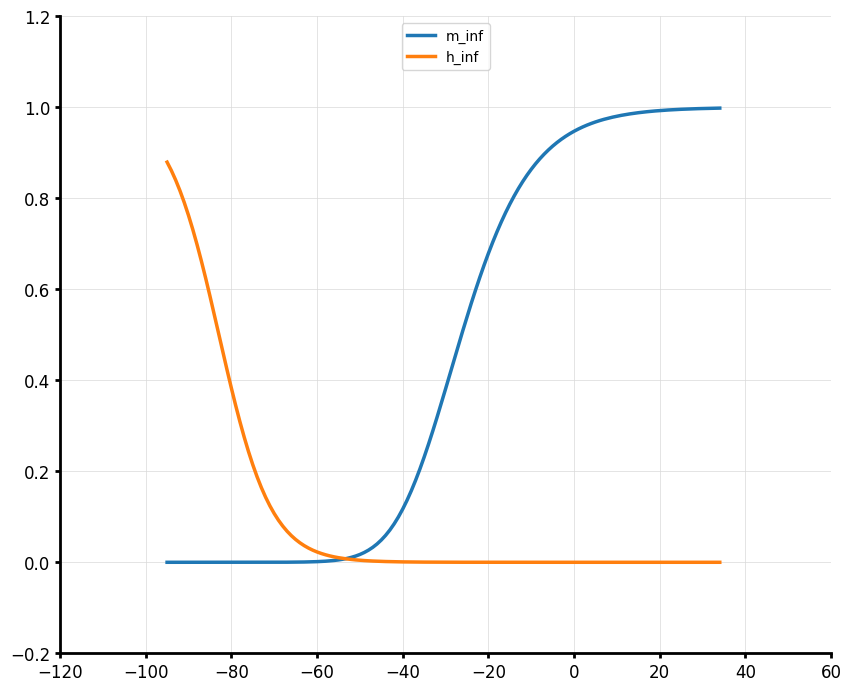

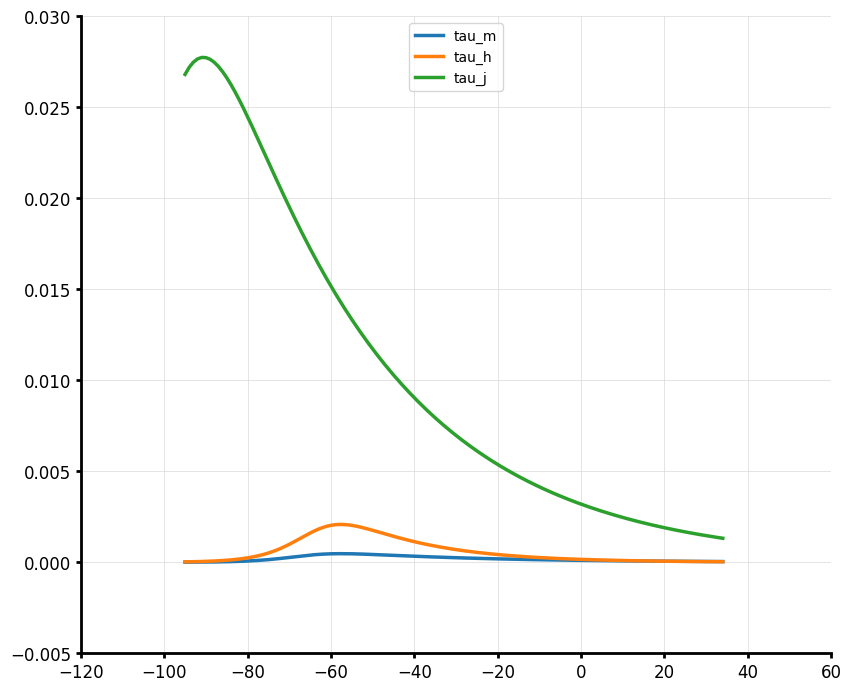

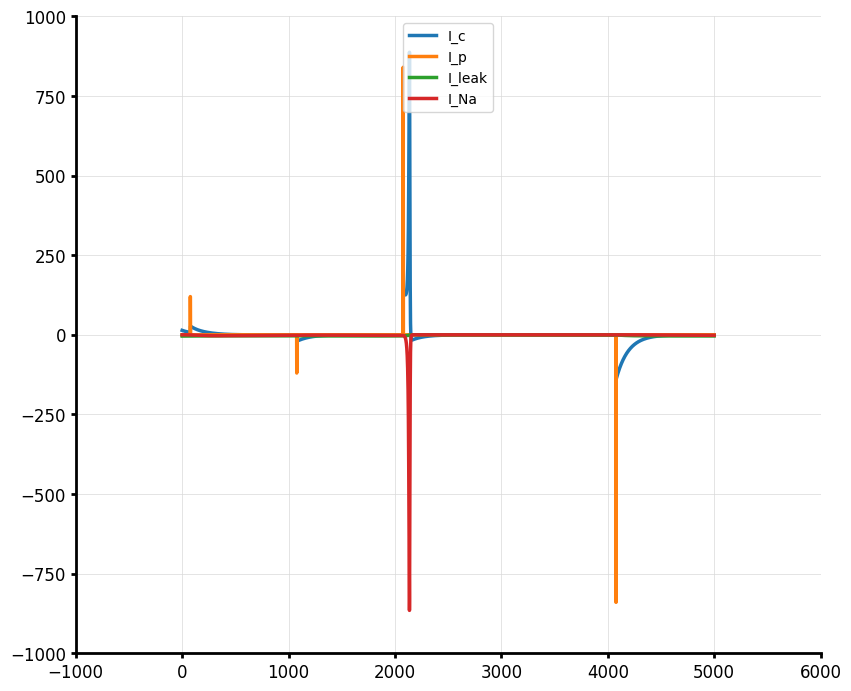

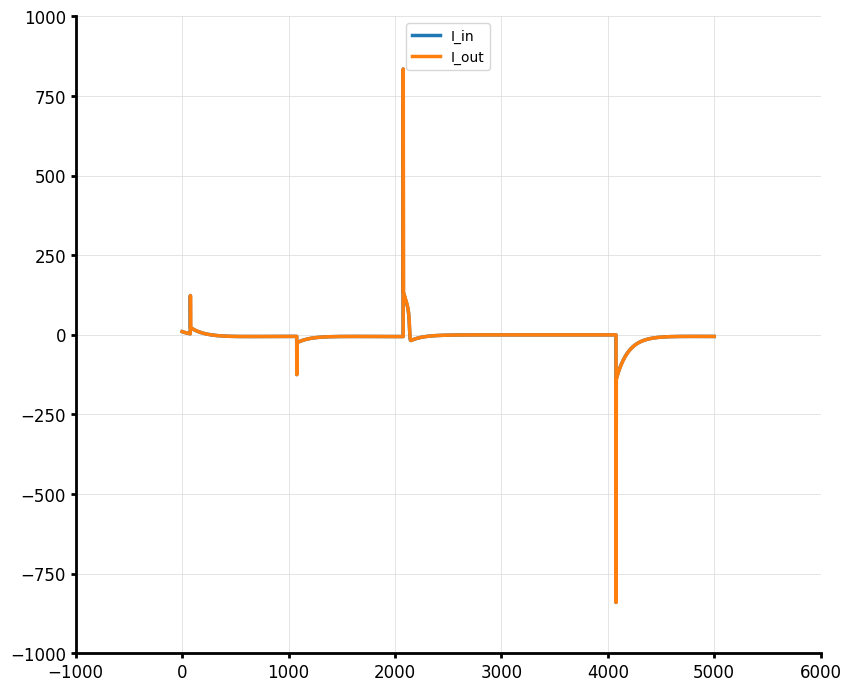

In [63]:
#p0 = np.array([6e-16, 6e-12, 2e3,  1.6e3,   0.9,   60,  1e-1,   4e2,    0.3,     3,    8e8,   5e3,  13,   2e-1, 11, 52,0.2,0.3,10])
#x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
#p0 = np.array([6e-13, 1.6e-11, 90,  8e1,0.2,   100,    6e-3,   4e3,    0.1,  0.9,    5e8,   5e5,5e1,   5e-1,20,30,5,7, 5])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak

#              C_p      C      a0_m    b0_m    s_m_1   s_m_2     a0_h   b0_h      s_h_1  s_h_2  a0_j    b0_j
p0 = np.array([6e-13, 1.16e-11, 9.455, 1.93e-5, 34.77,  5.95,    6.306, 1.184e-5, 20.27, 6.285, 0.313, 1.13e-7,\
               38.45, 8.281, 5e8,  5e6 ,   2.5e4,   5e-2,   39.57,      82.9,   9.871,   6.086, 5e-5,   5.])
#              s_j_1  s_j_2  R    R_p      g_max  g_leak  v_half_m   v_half_h  k_m     k_h     tau_z   v_off

#x_true_log = np.log(p0)
x_true_log = np.concatenate((np.log(p0[:-1]),p0[-1:]))


t = np.load('../data/time.npy')

#v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
#k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs_all = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = True)#,
              #sample_weights = sample_weight)
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph =  True)#,

data = calculate_I_out(x_true_log, kwargs) 
#print(p0)


In [70]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

<ipython-input-57-bcbb0bb09c25>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


118 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


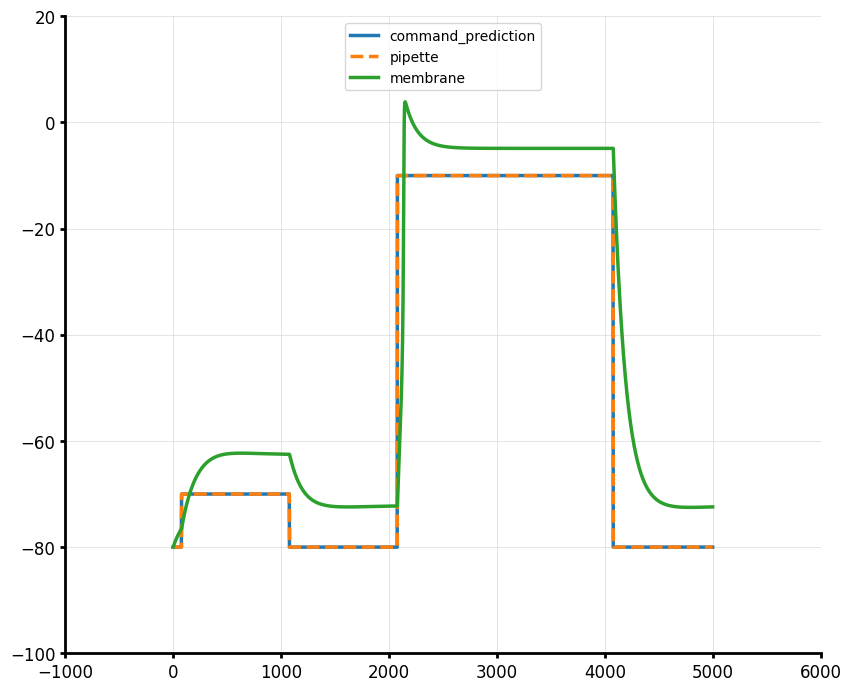

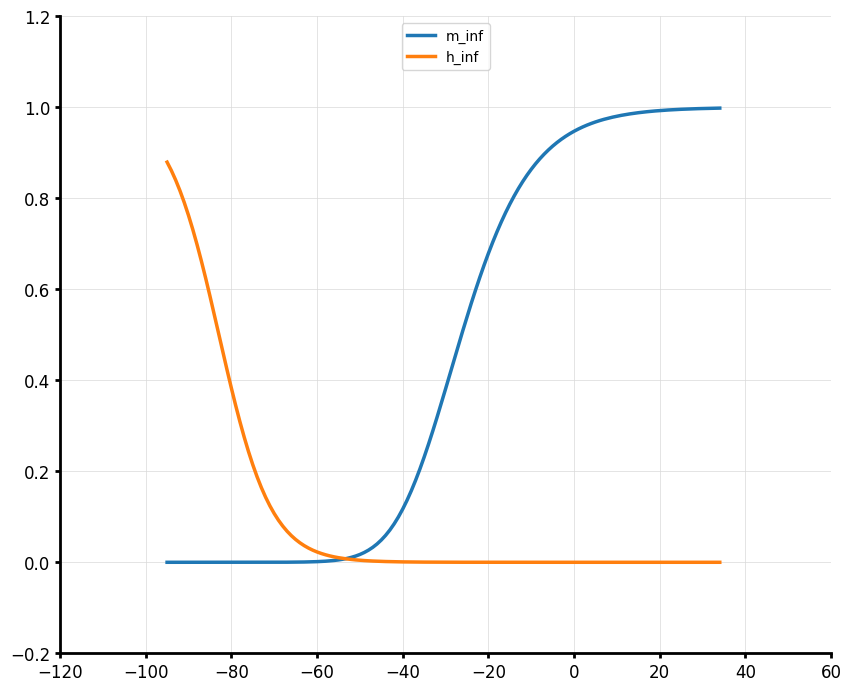

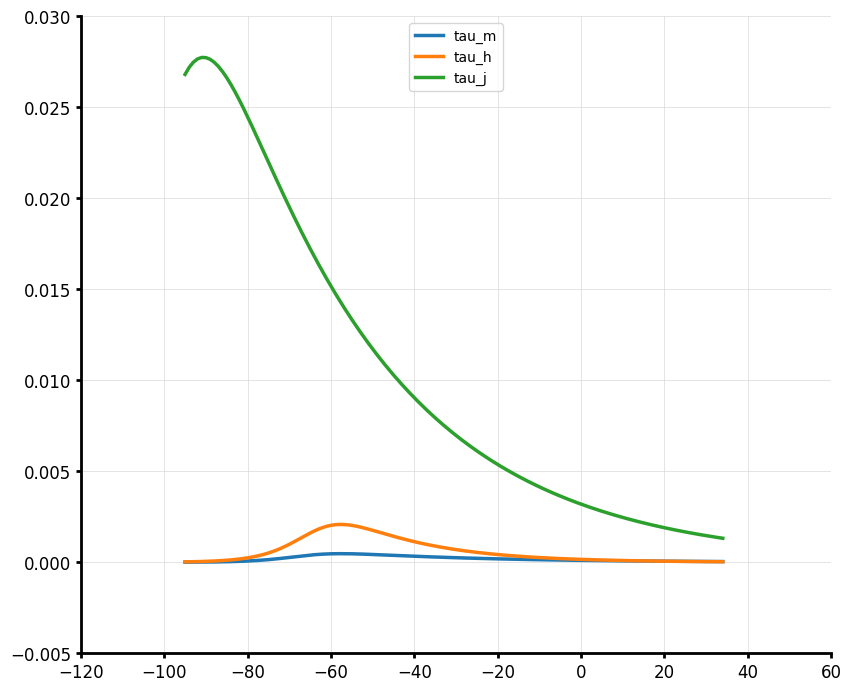

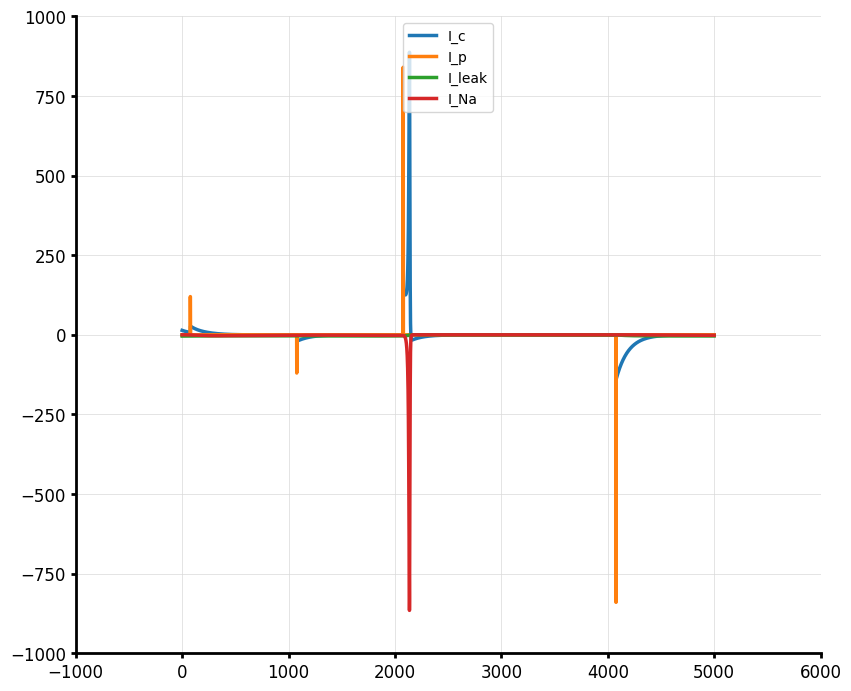

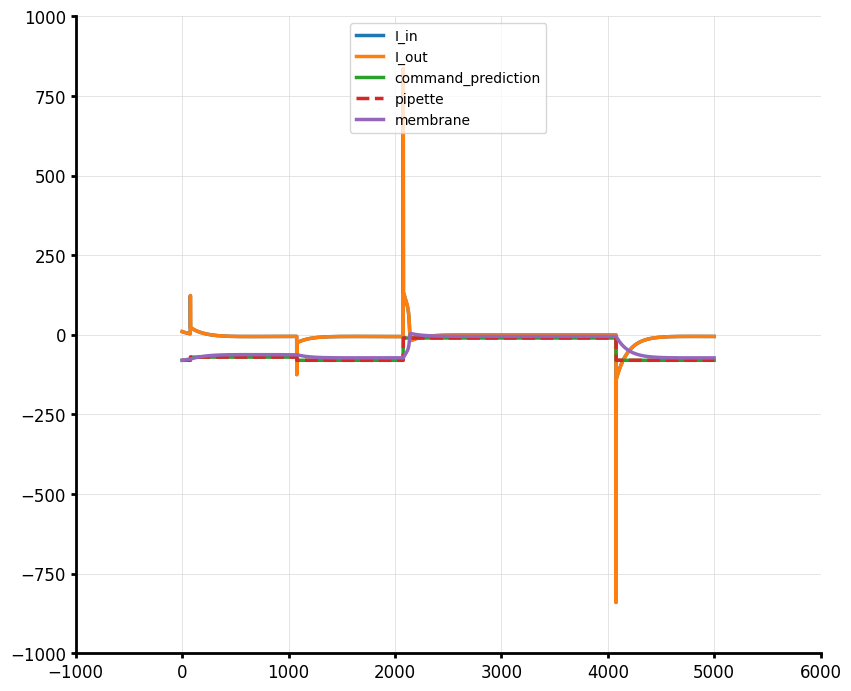

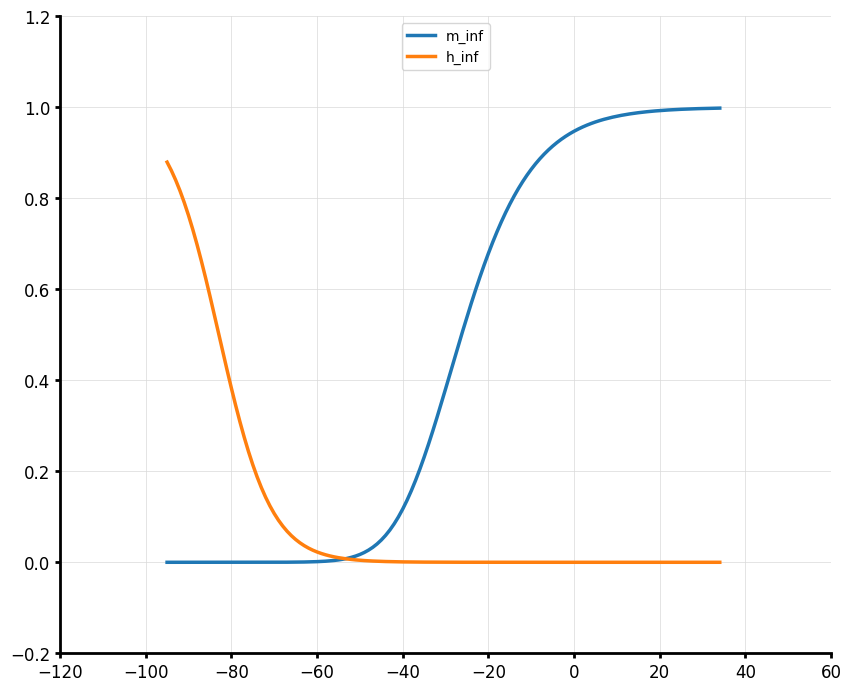

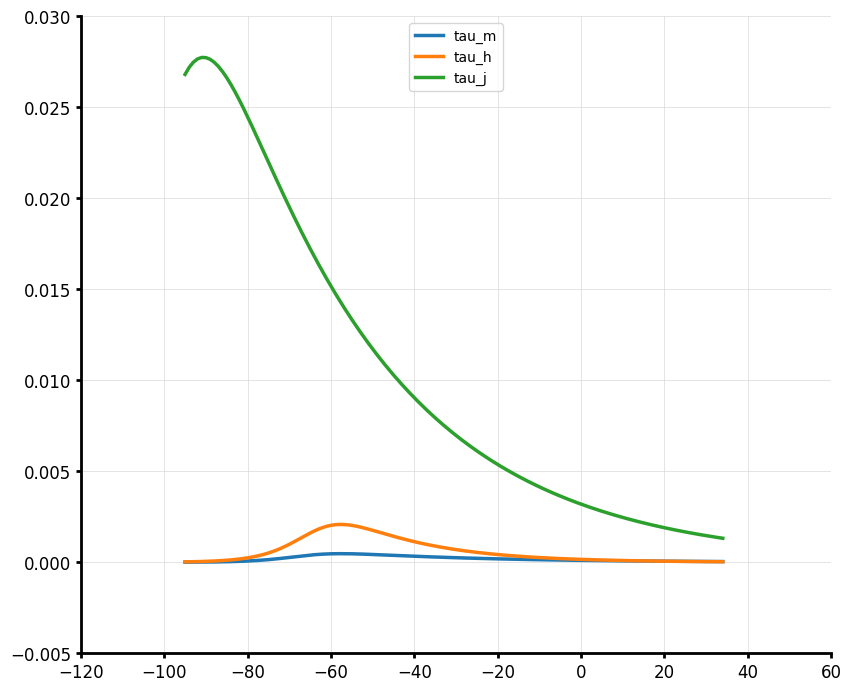

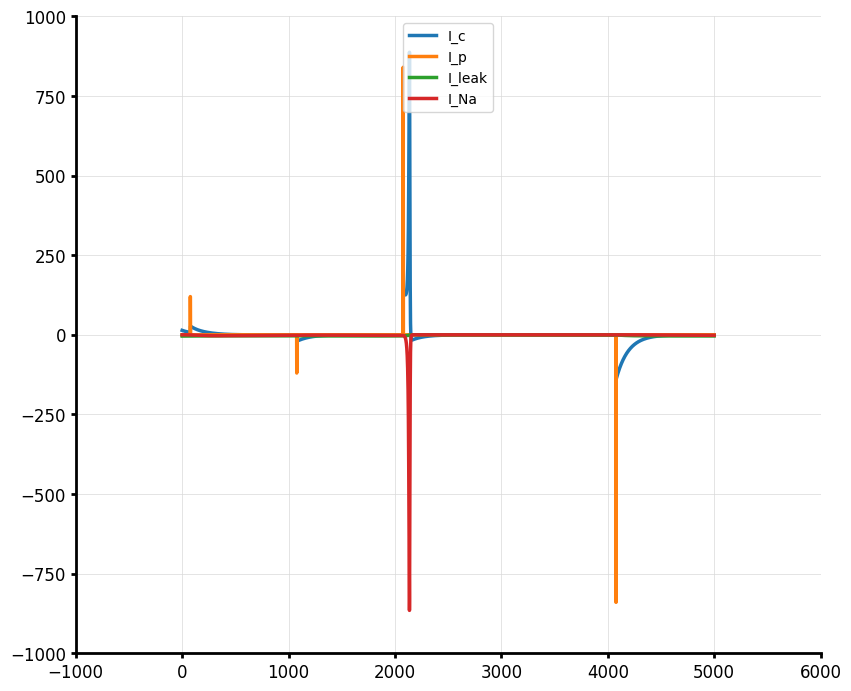

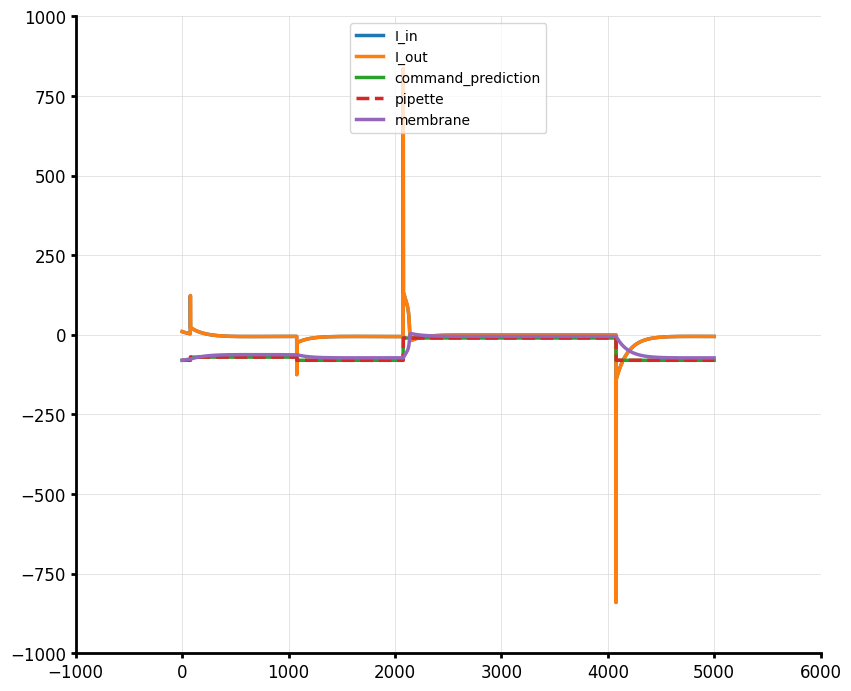

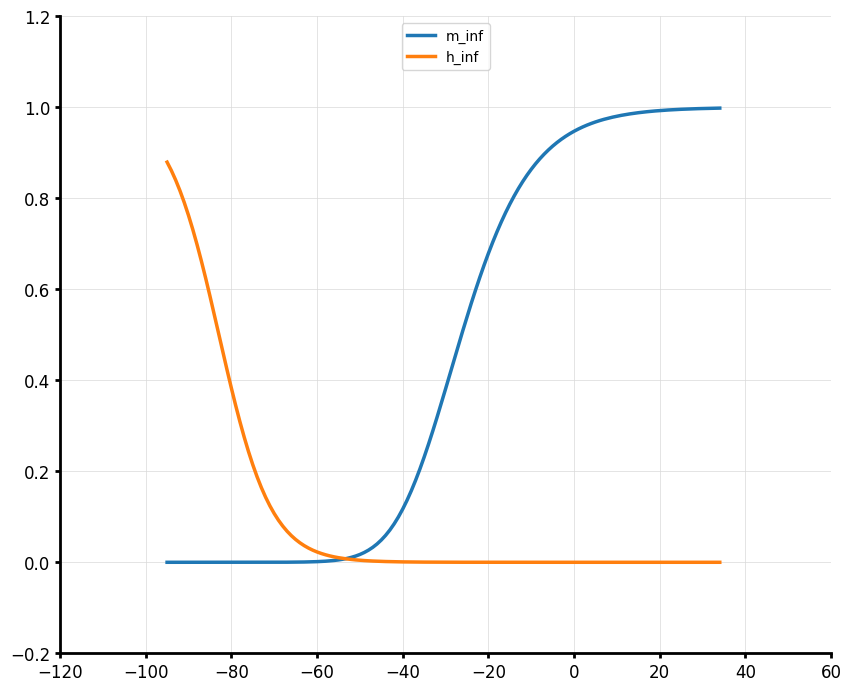

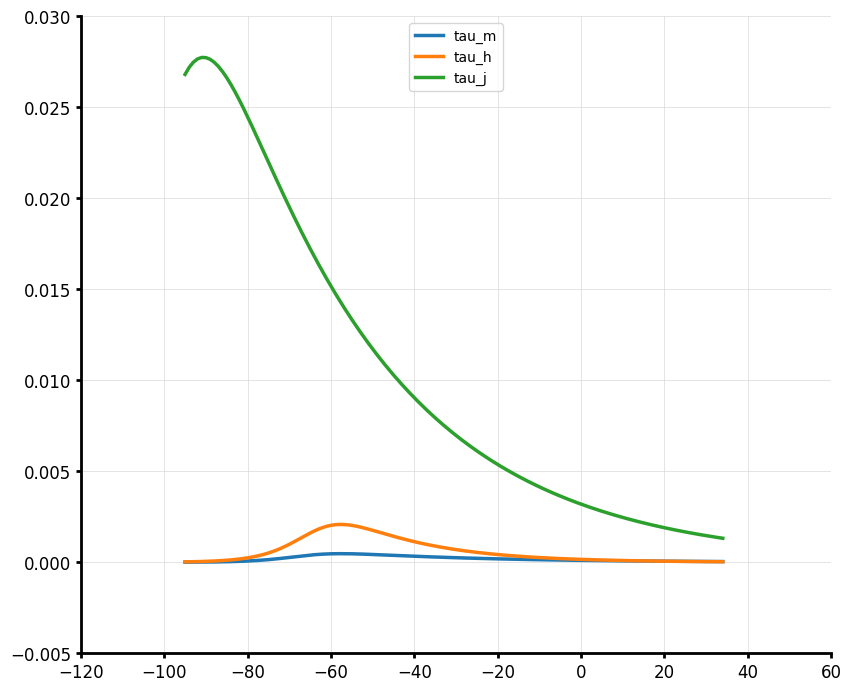

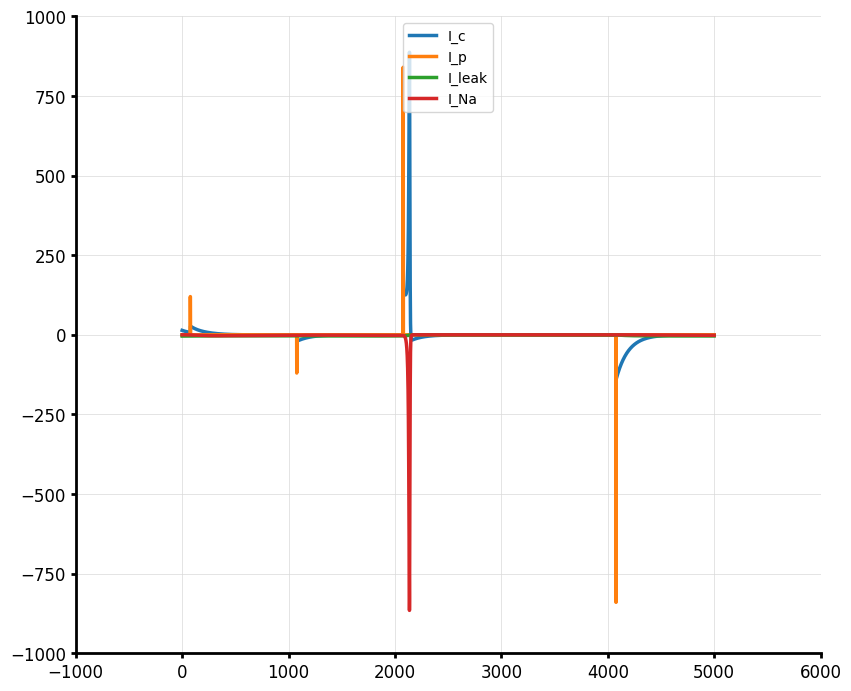

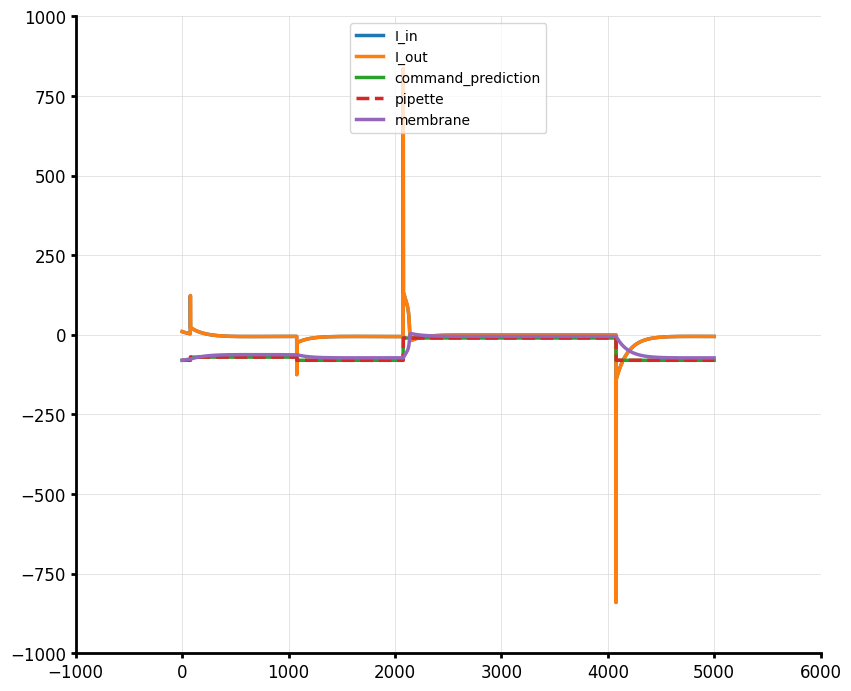

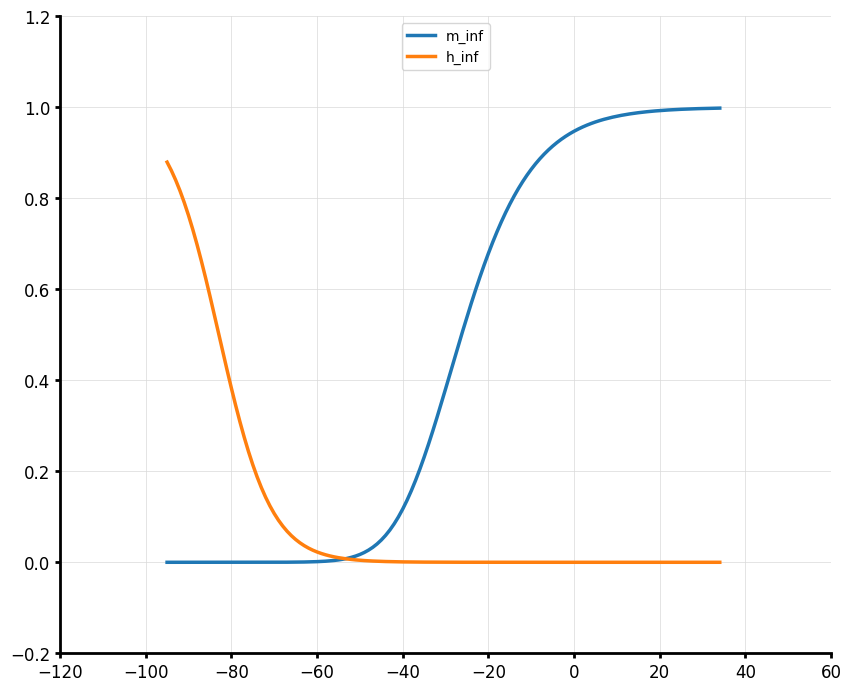

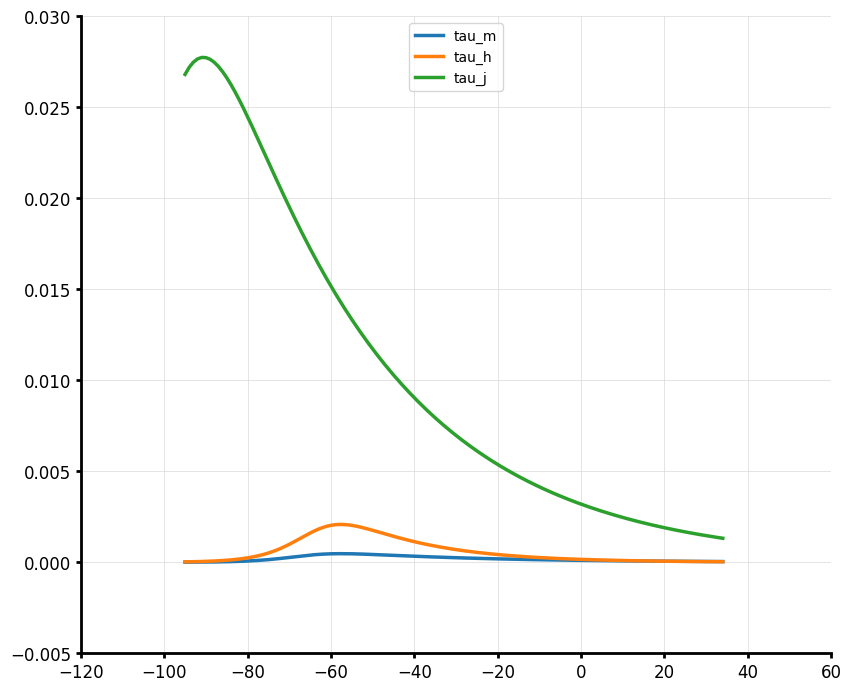

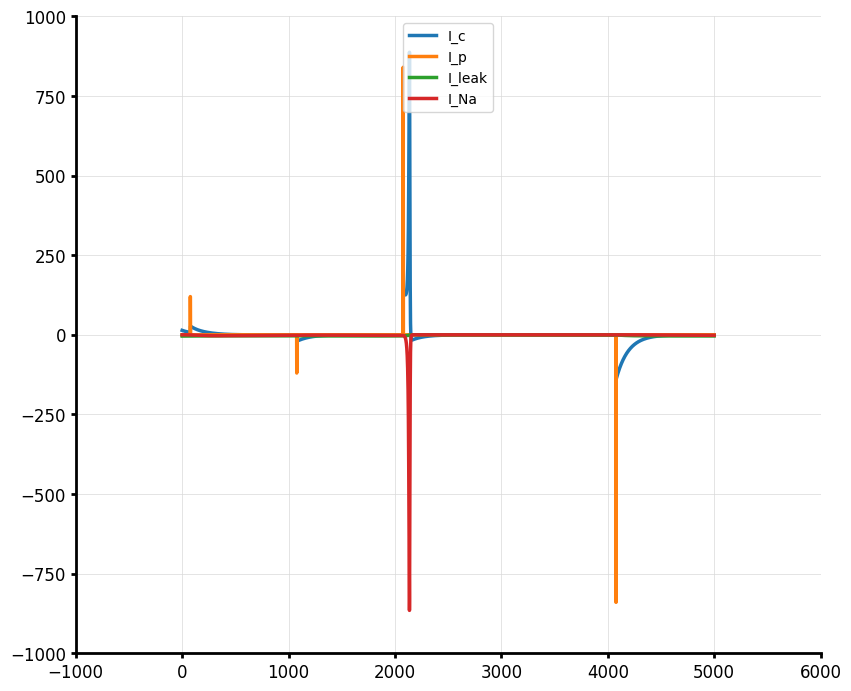

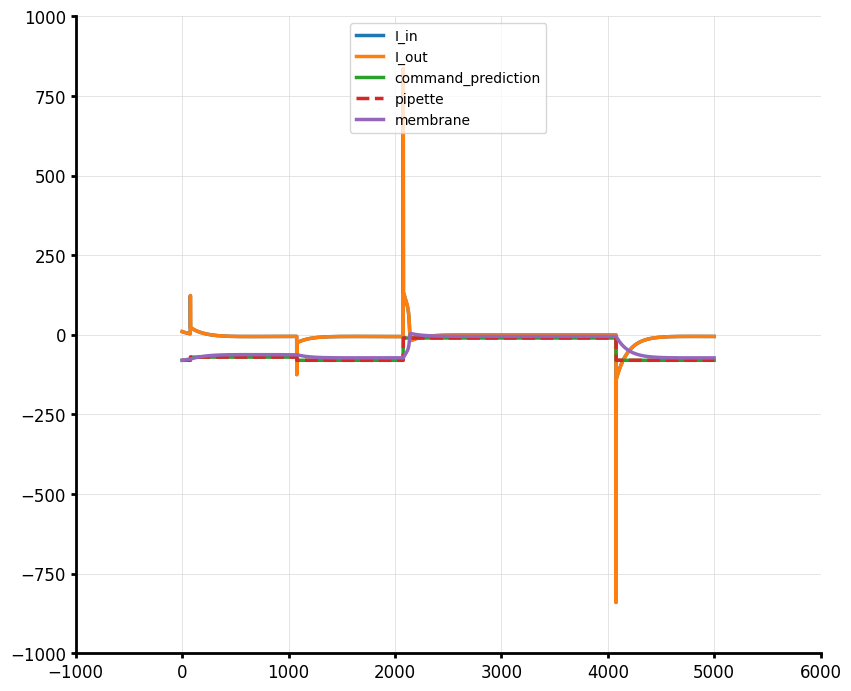

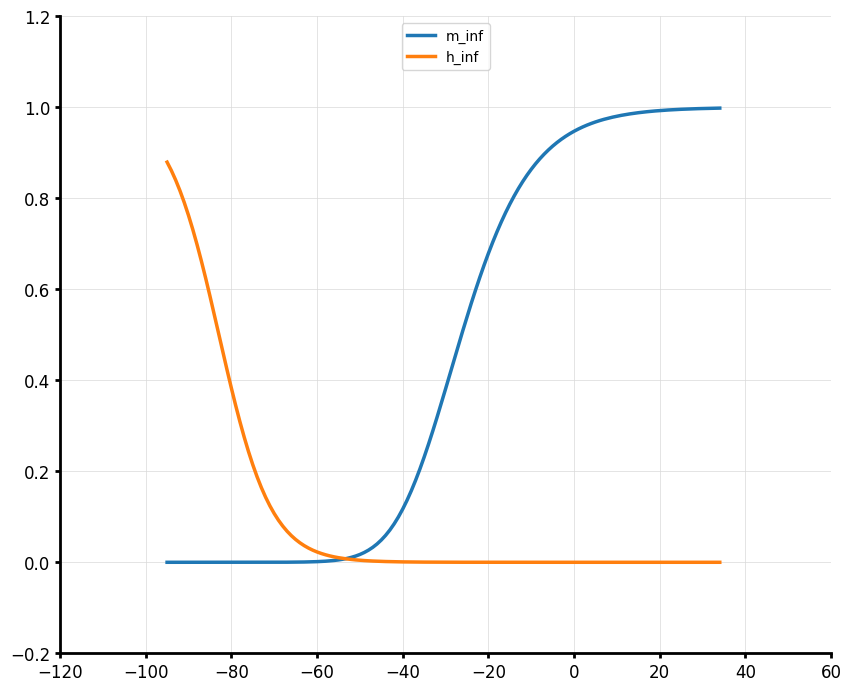

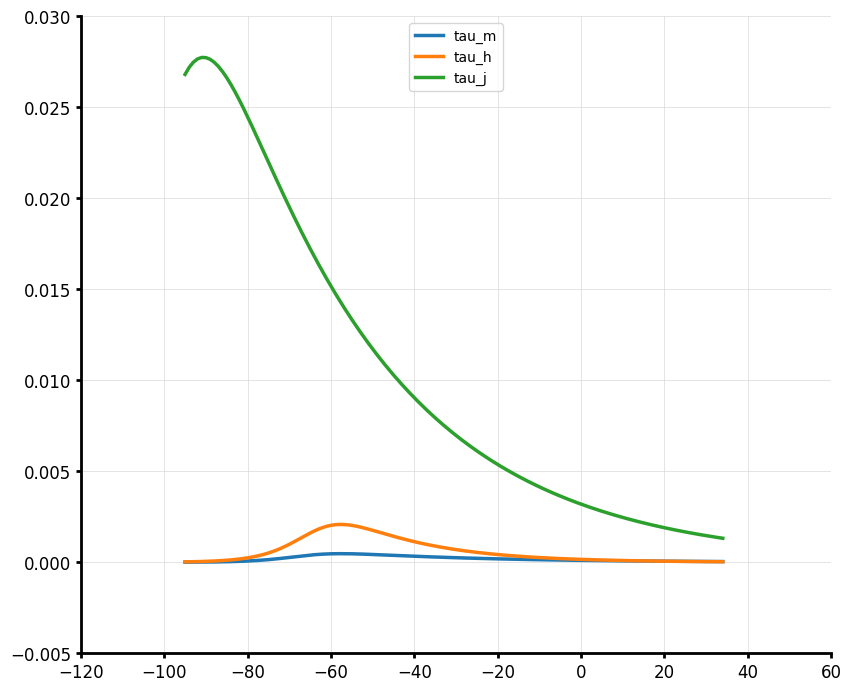

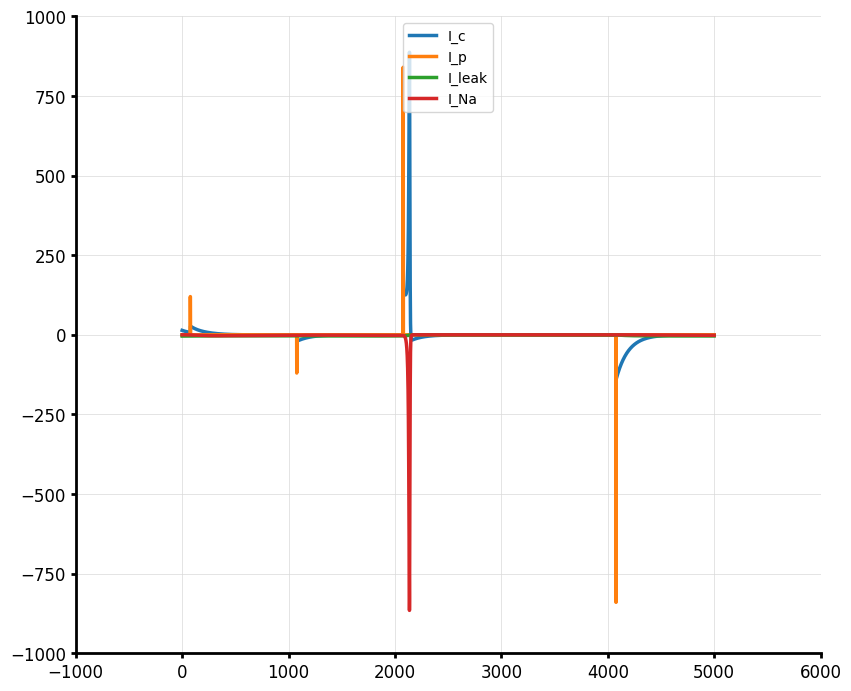

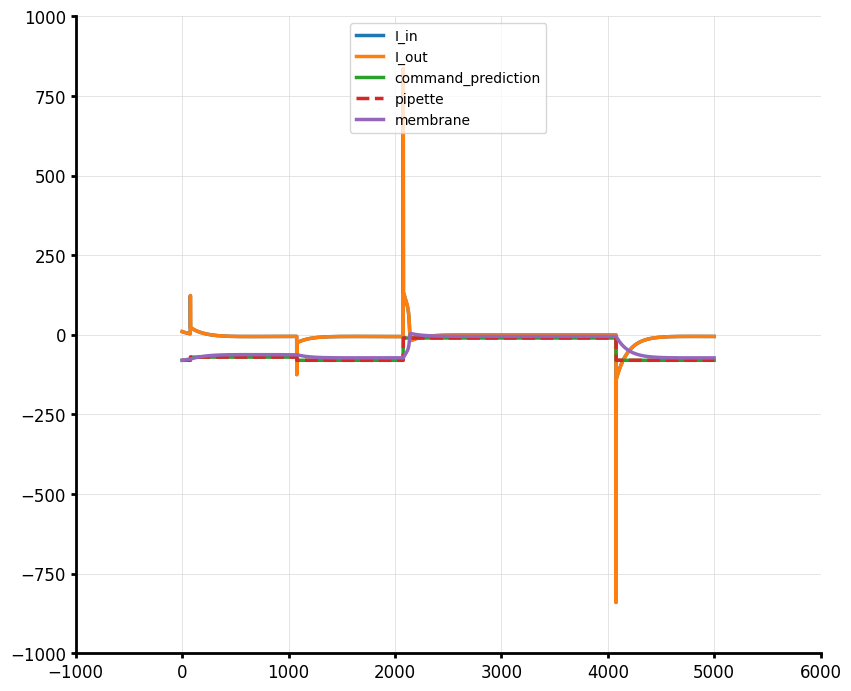

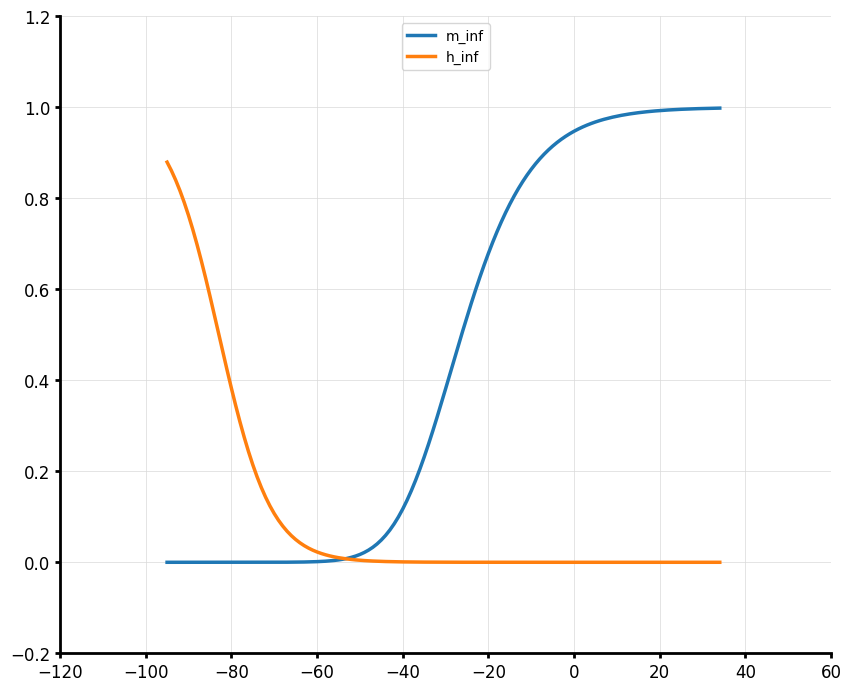

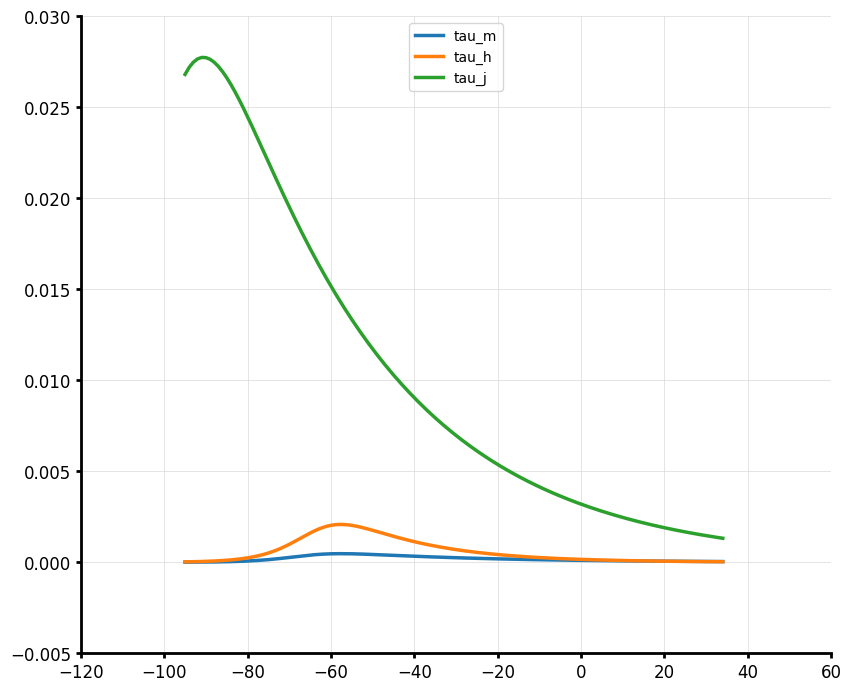

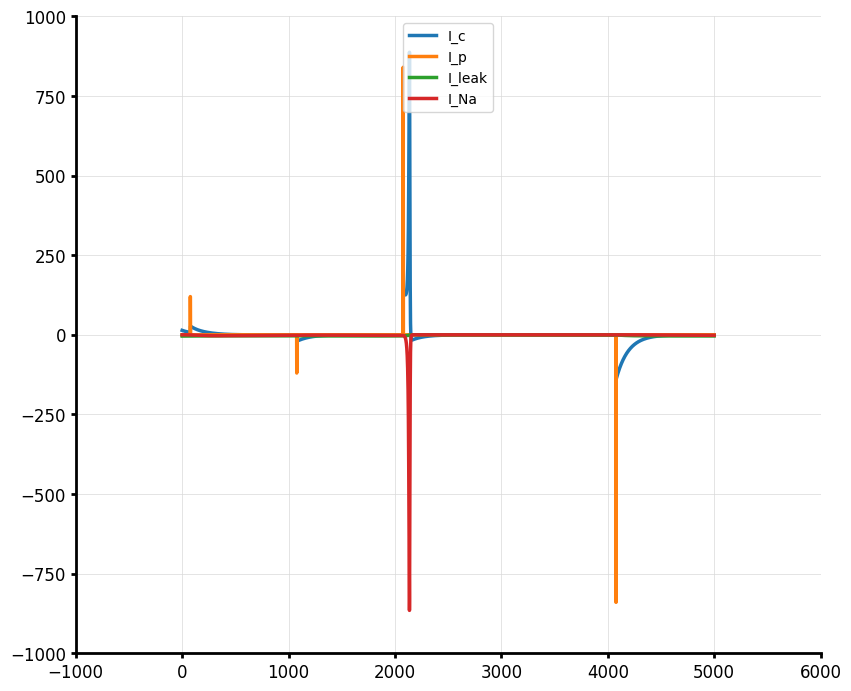

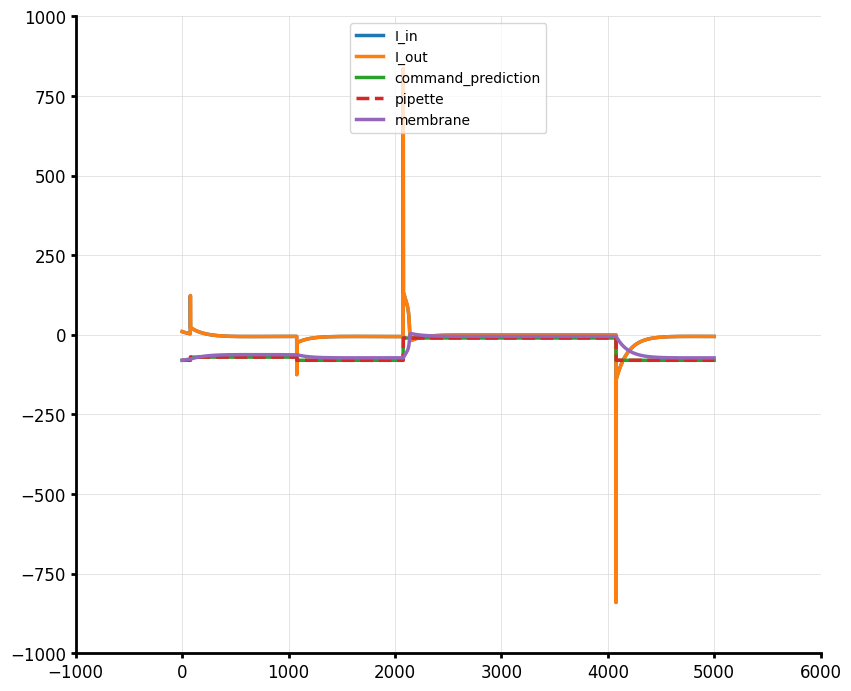

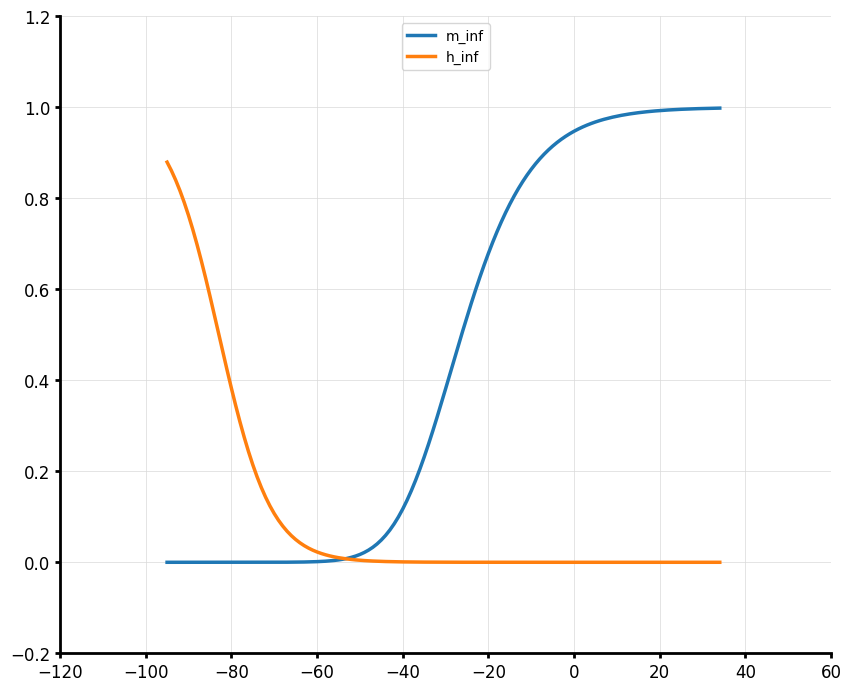

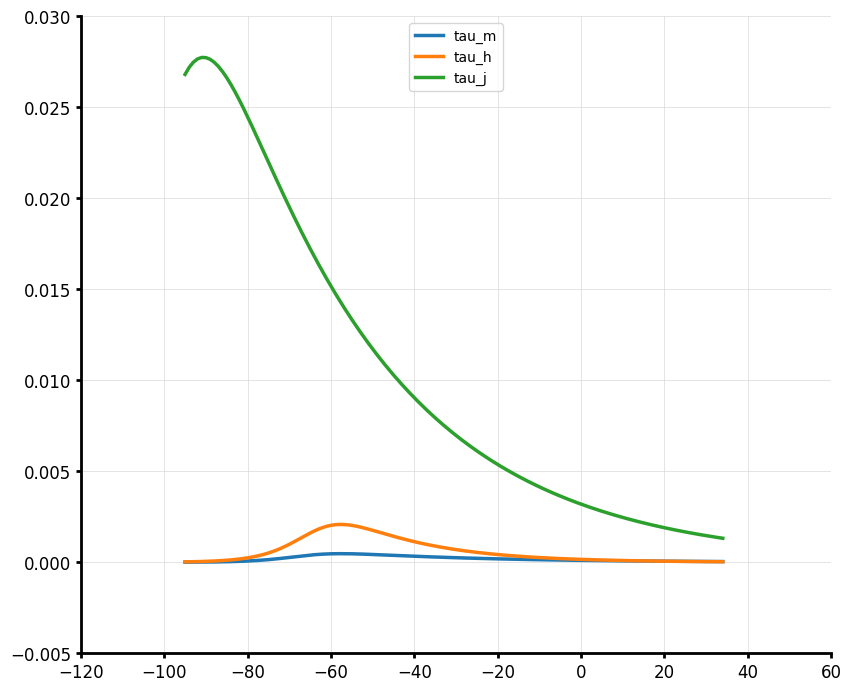

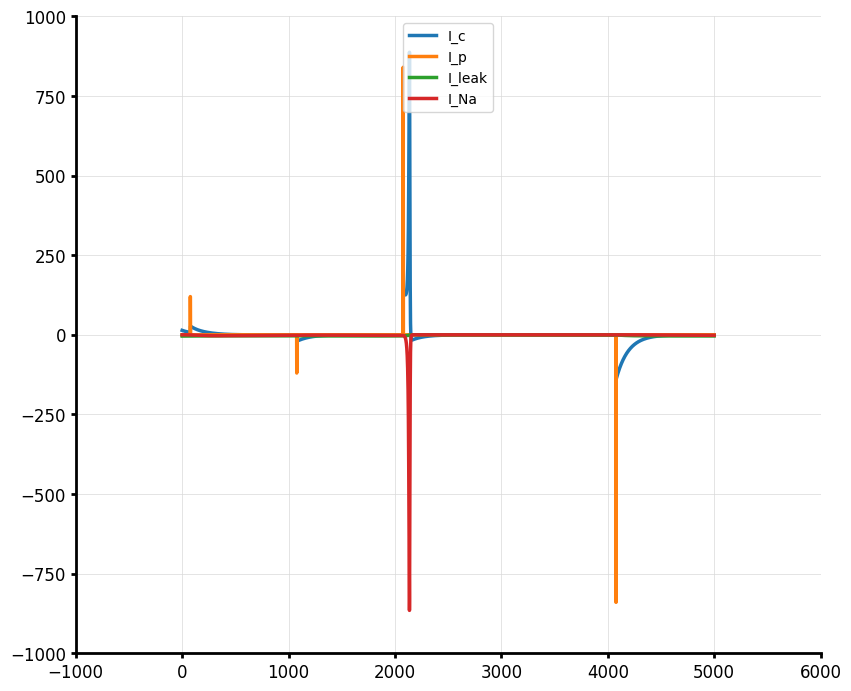

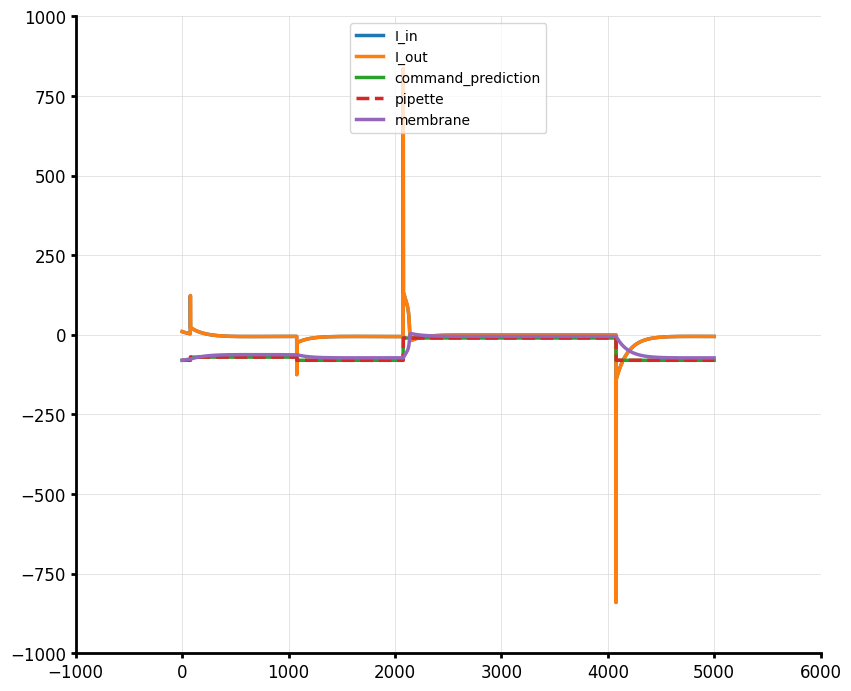

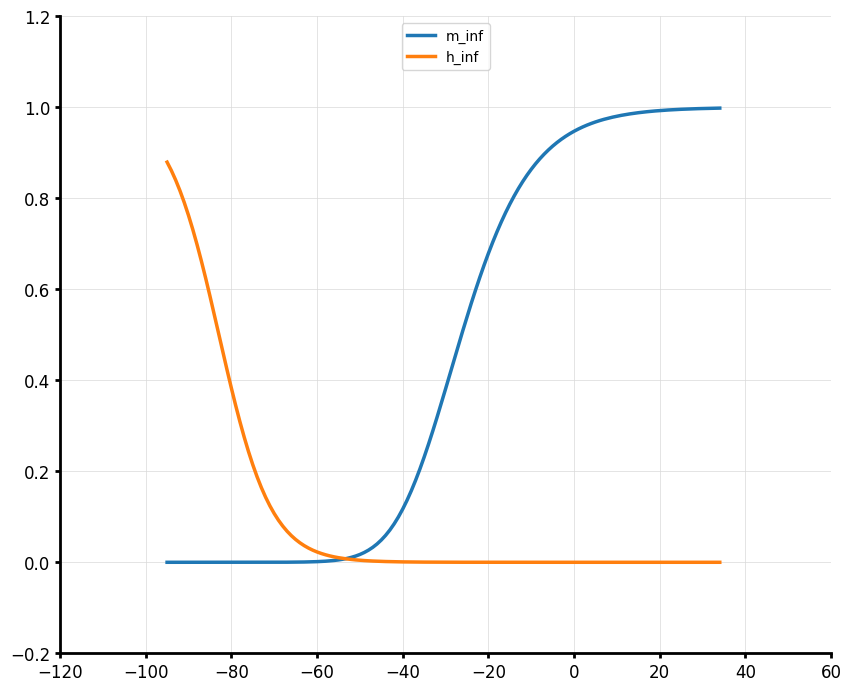

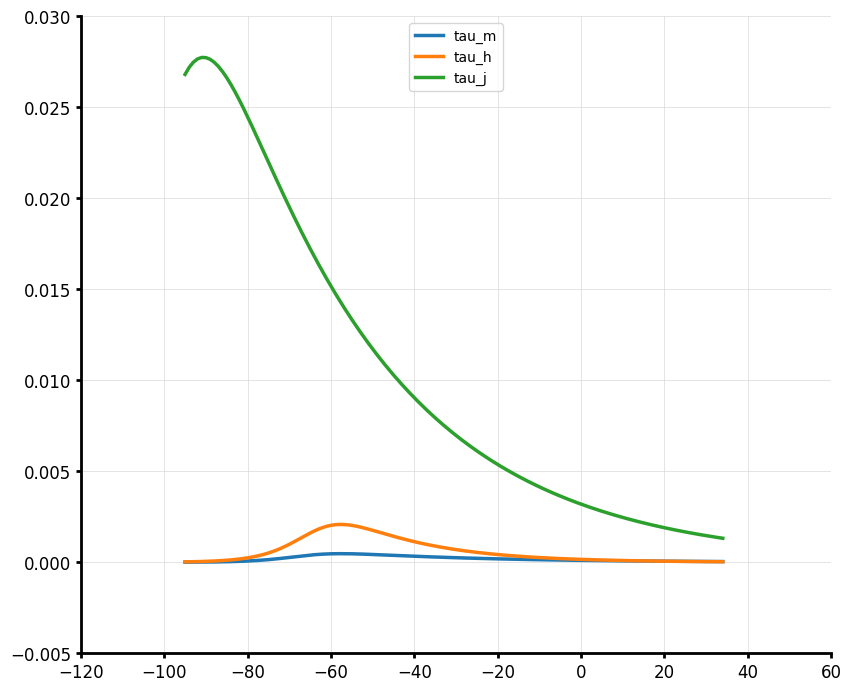

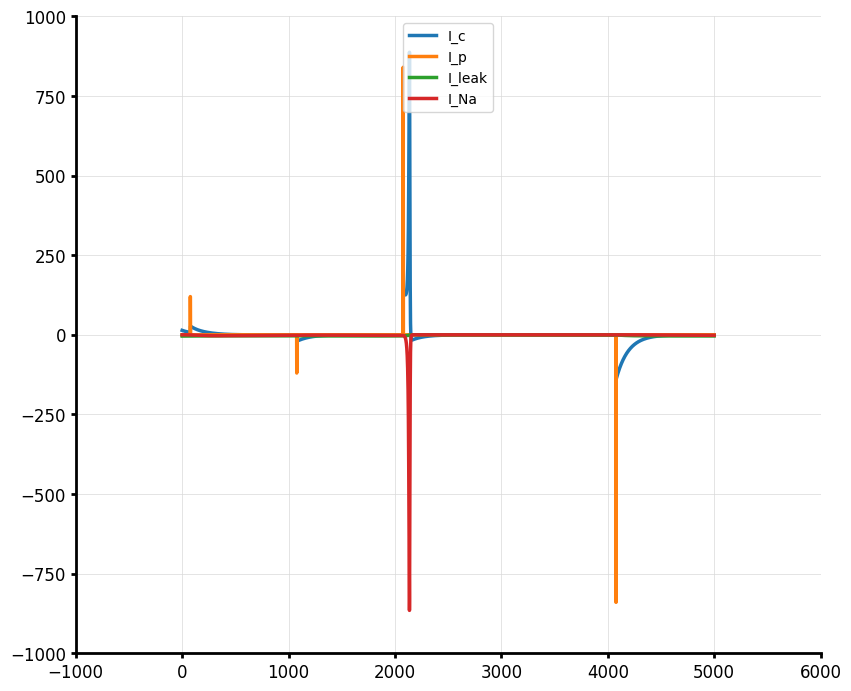

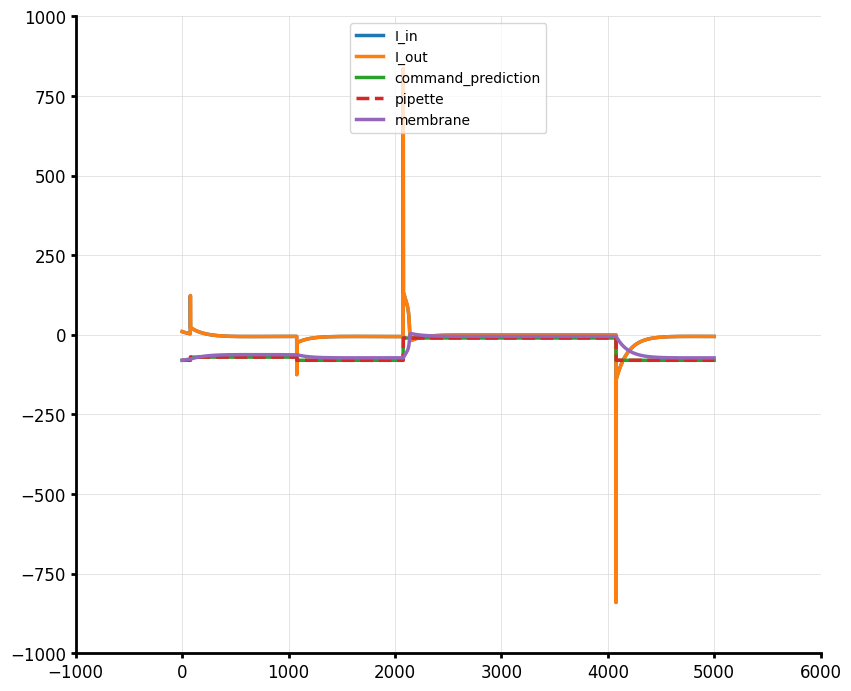

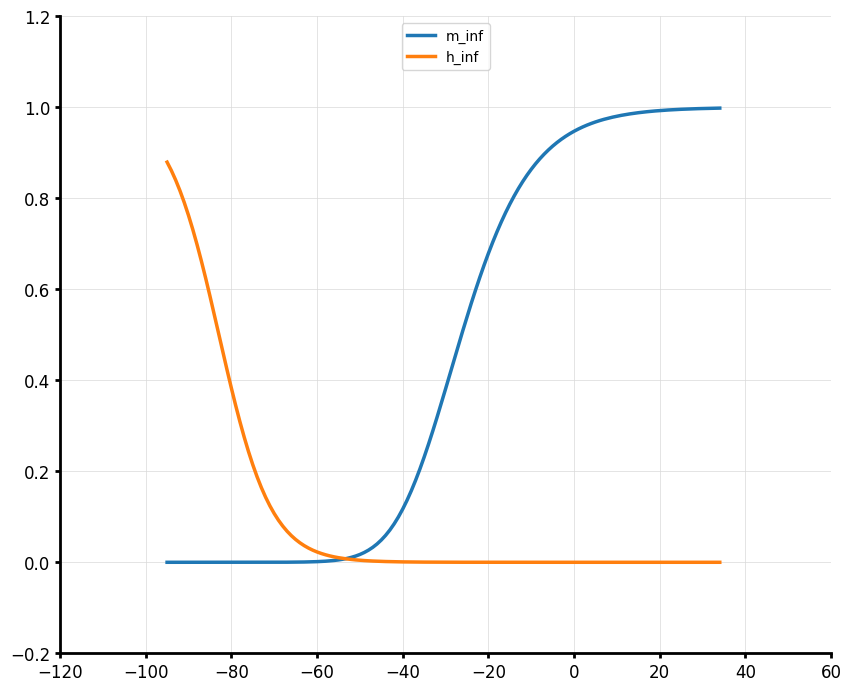

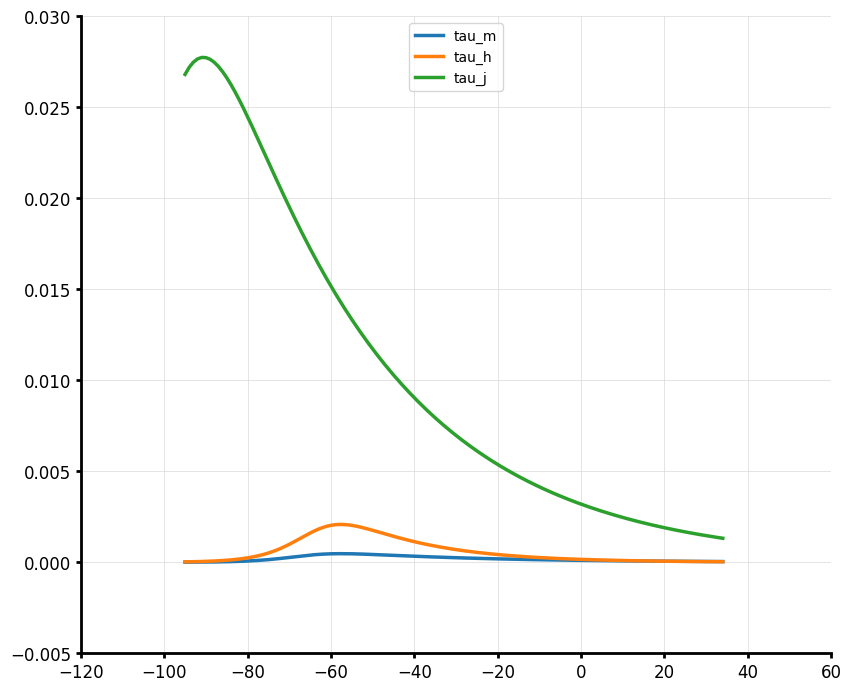

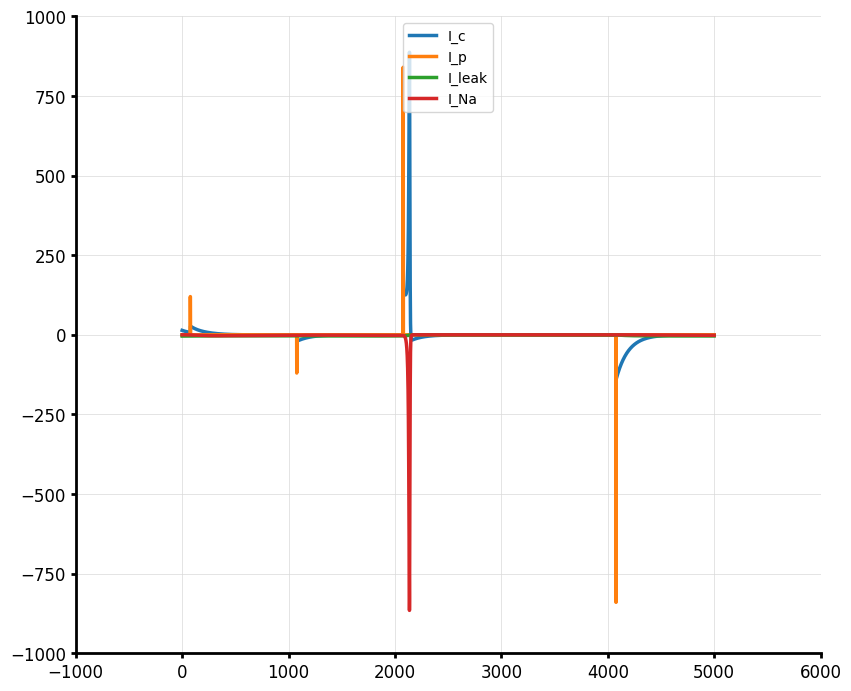

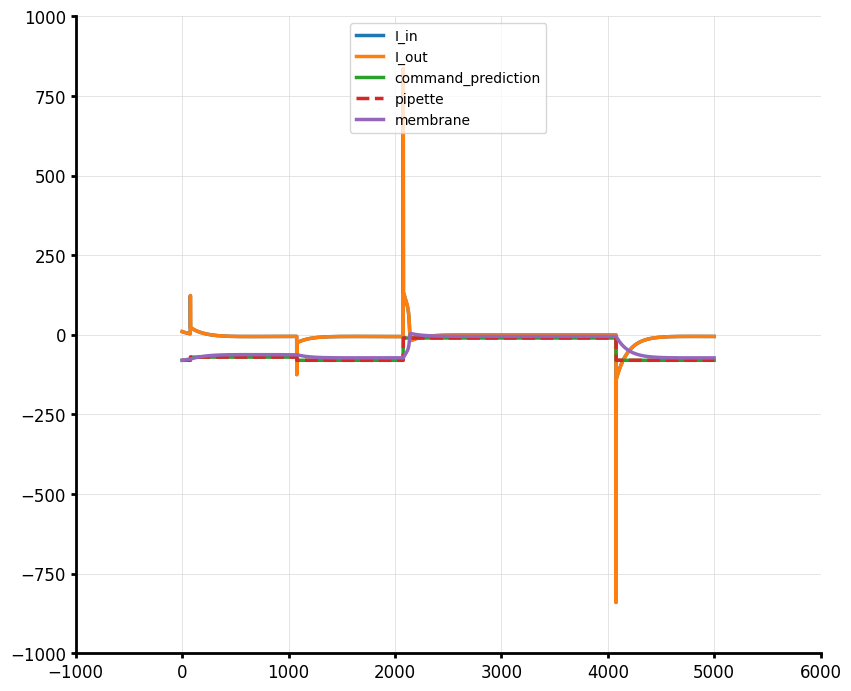

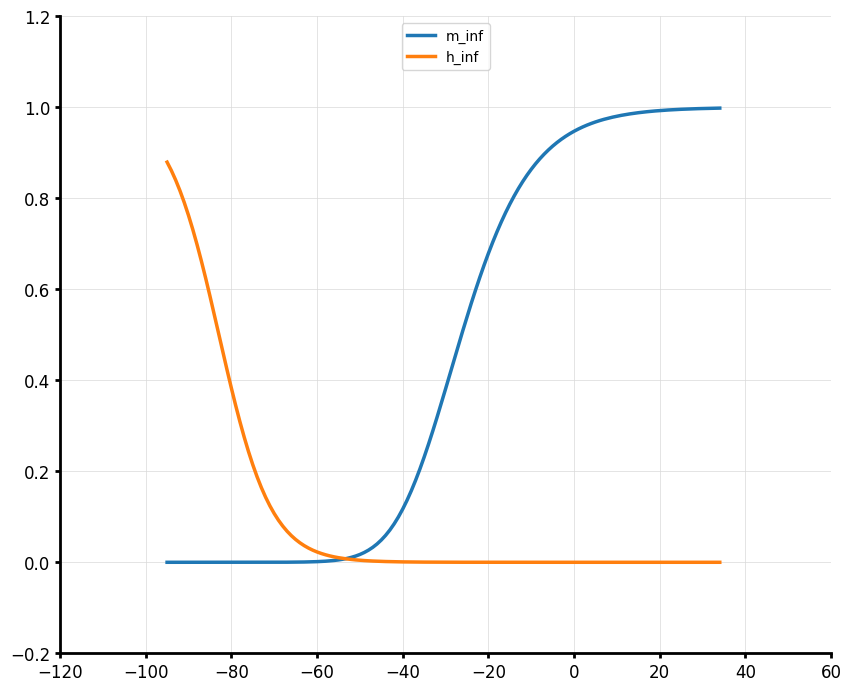

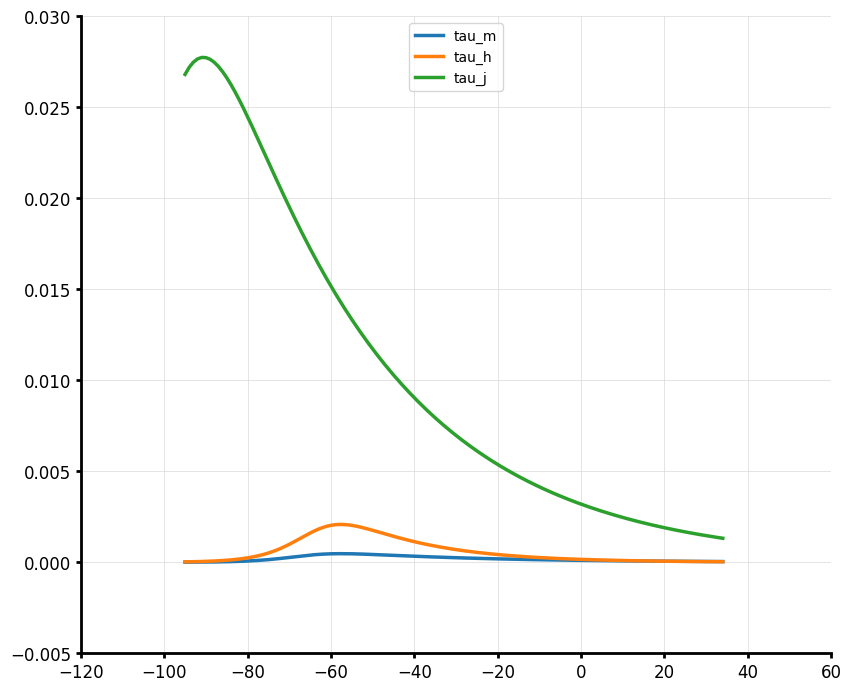

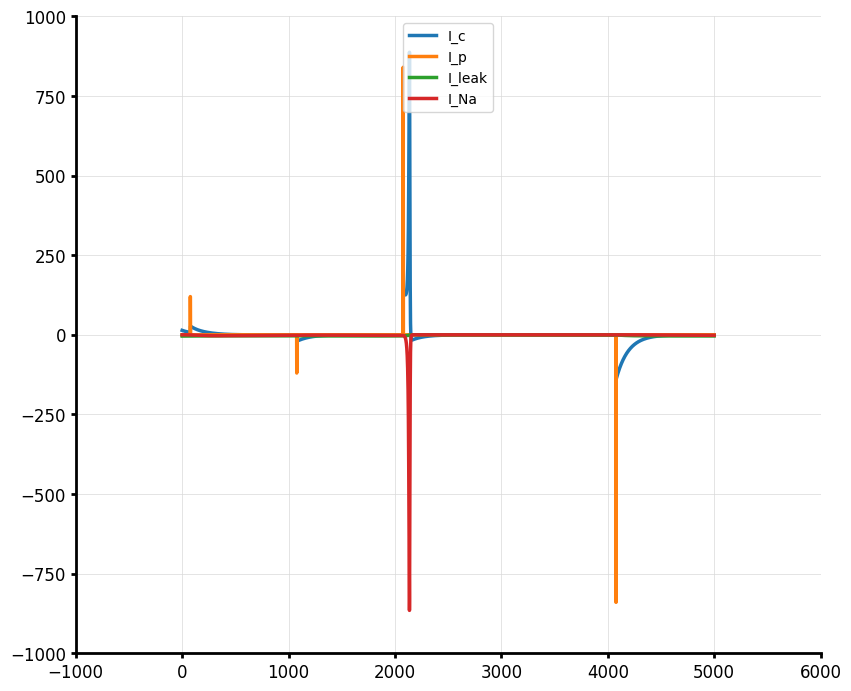

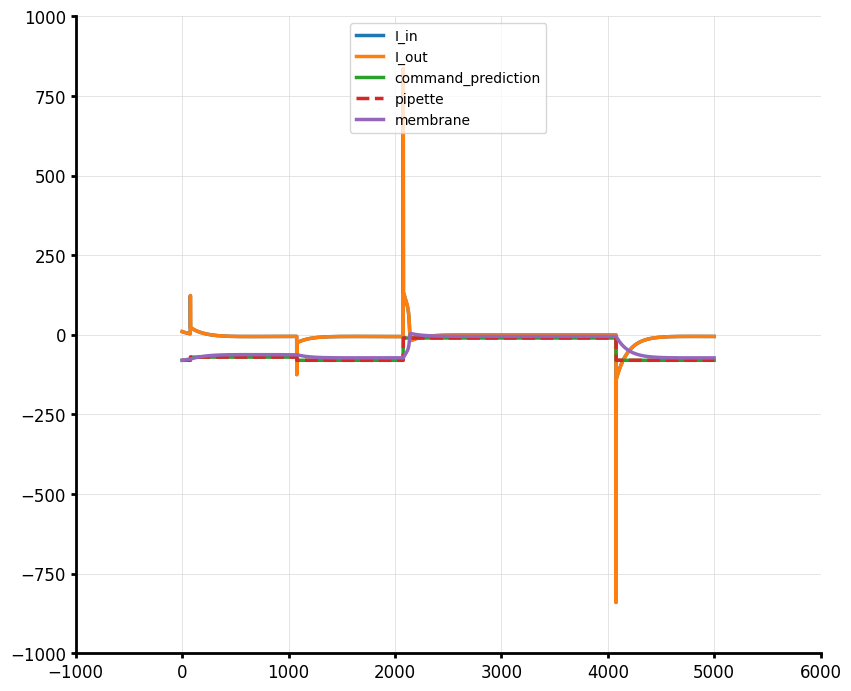

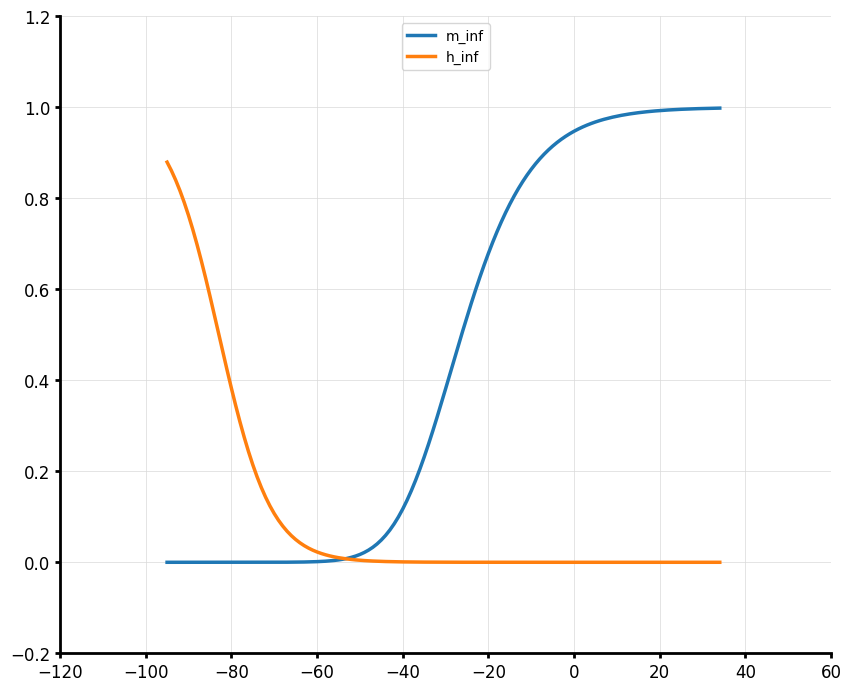

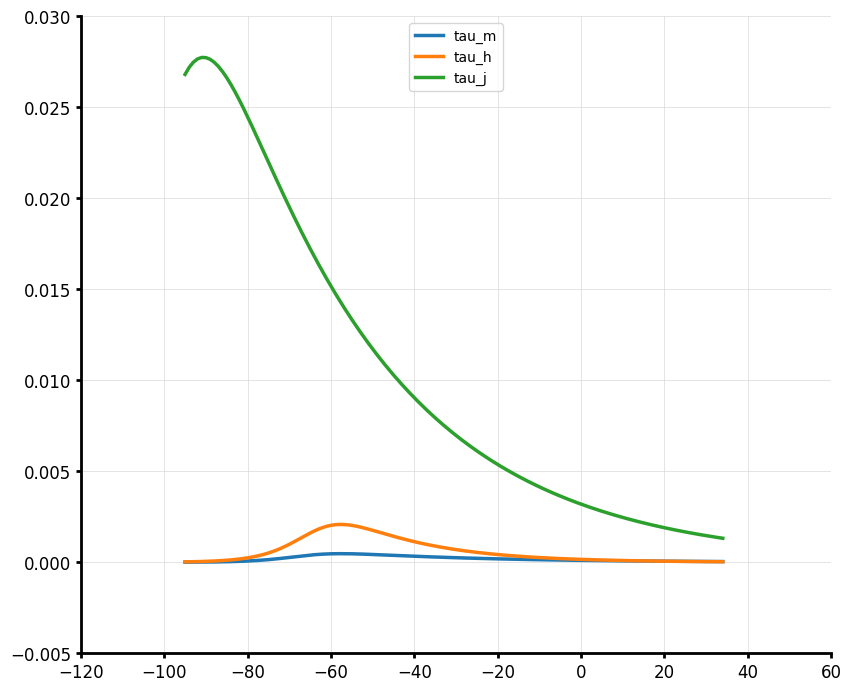

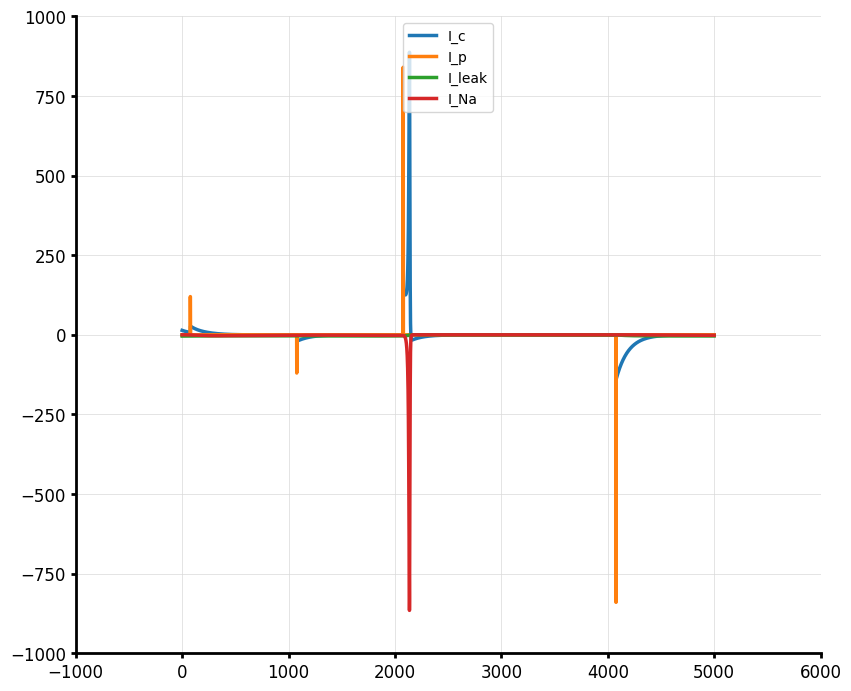

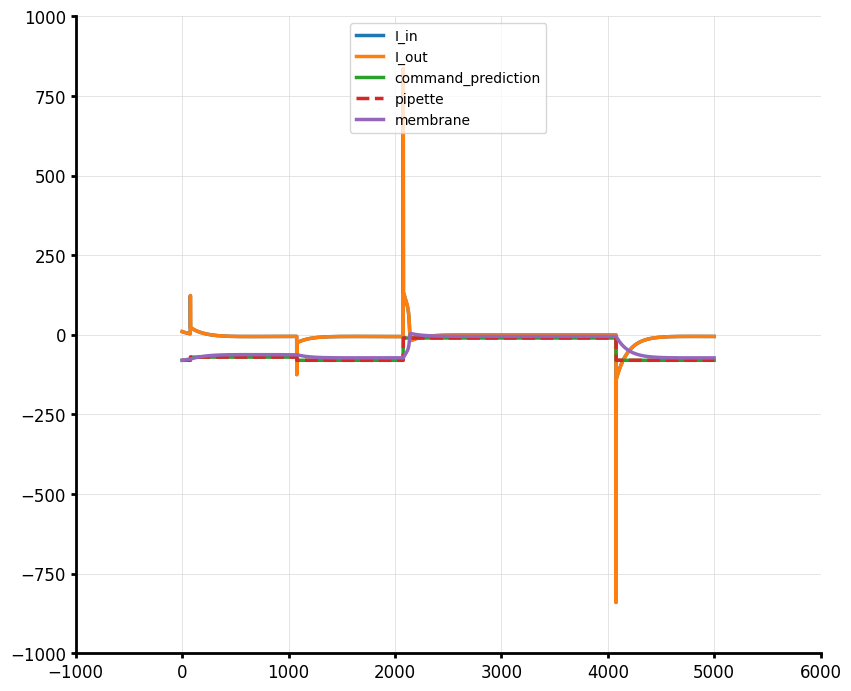

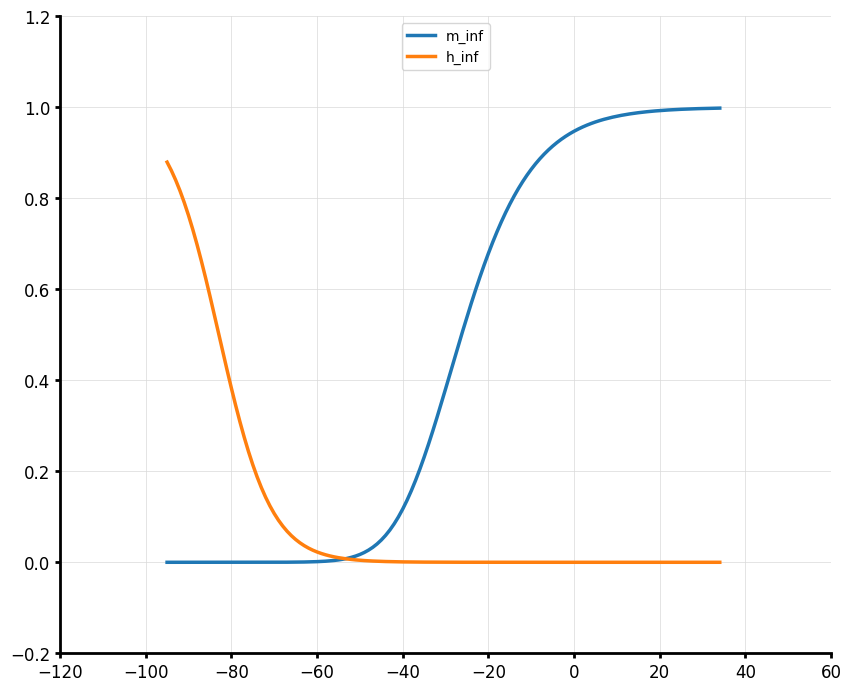

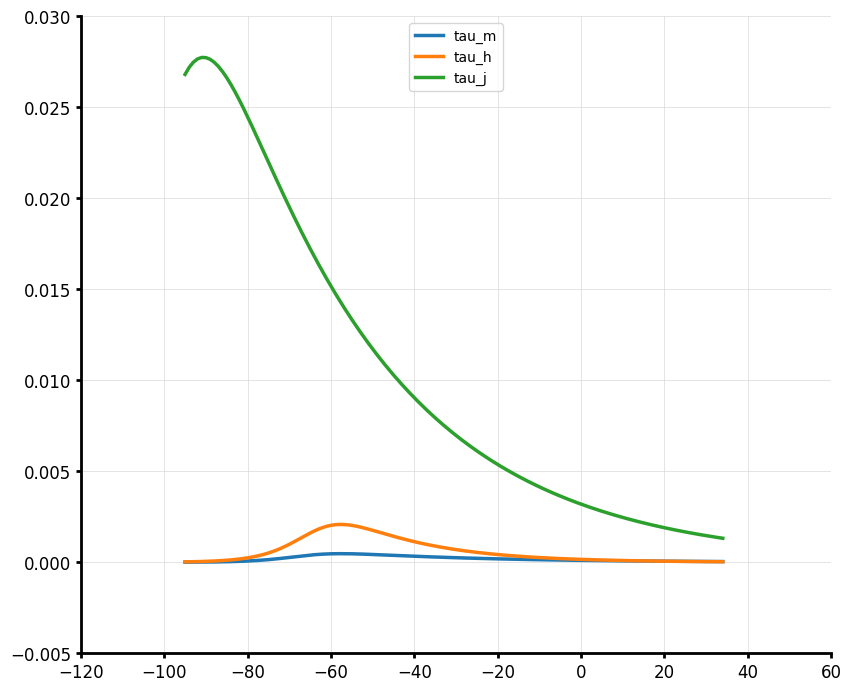

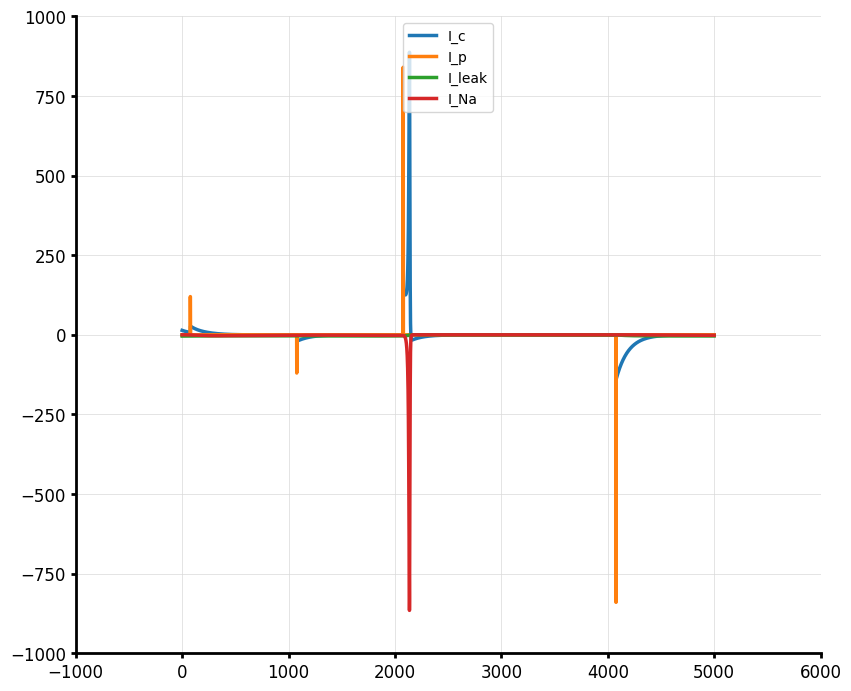

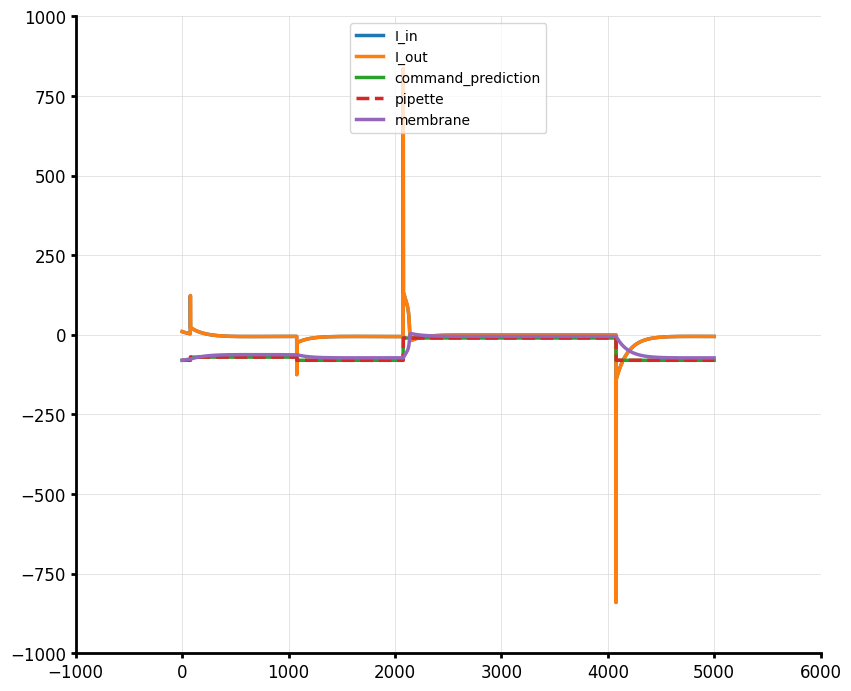

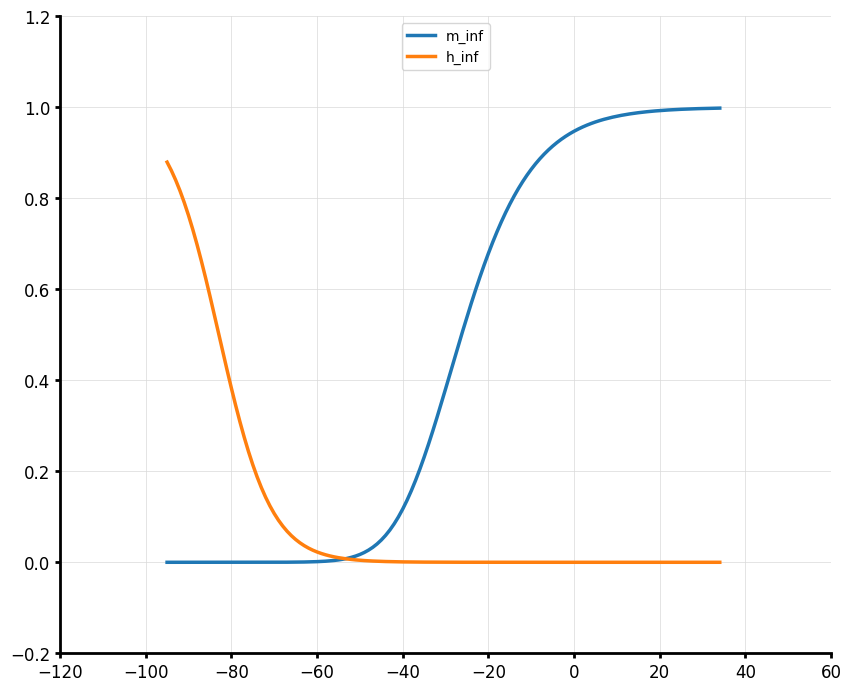

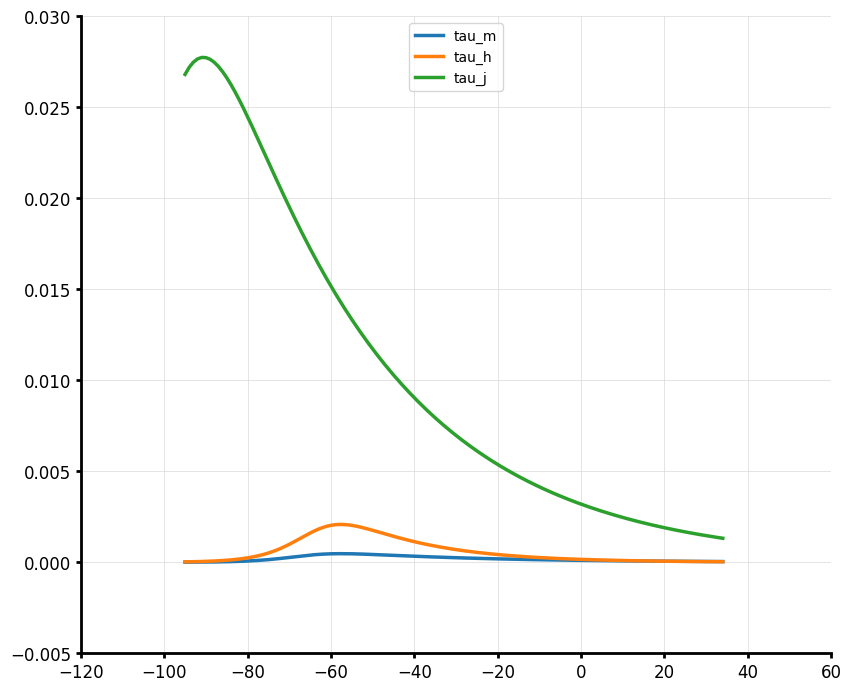

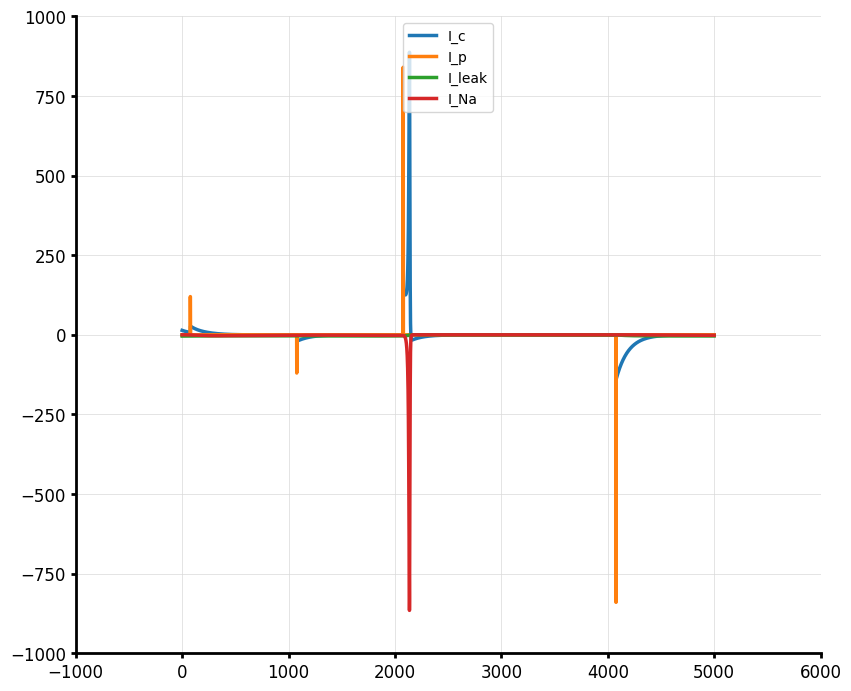

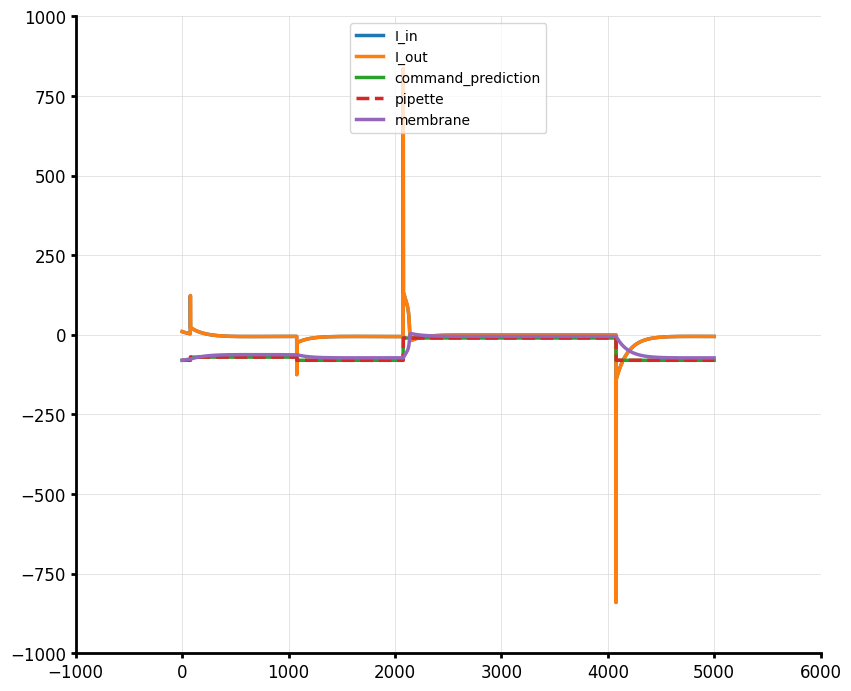

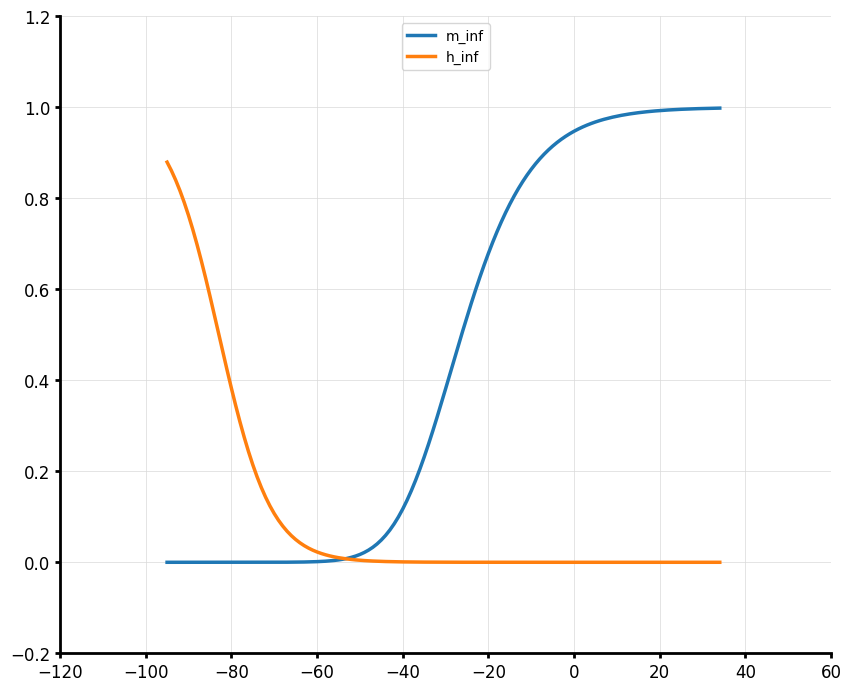

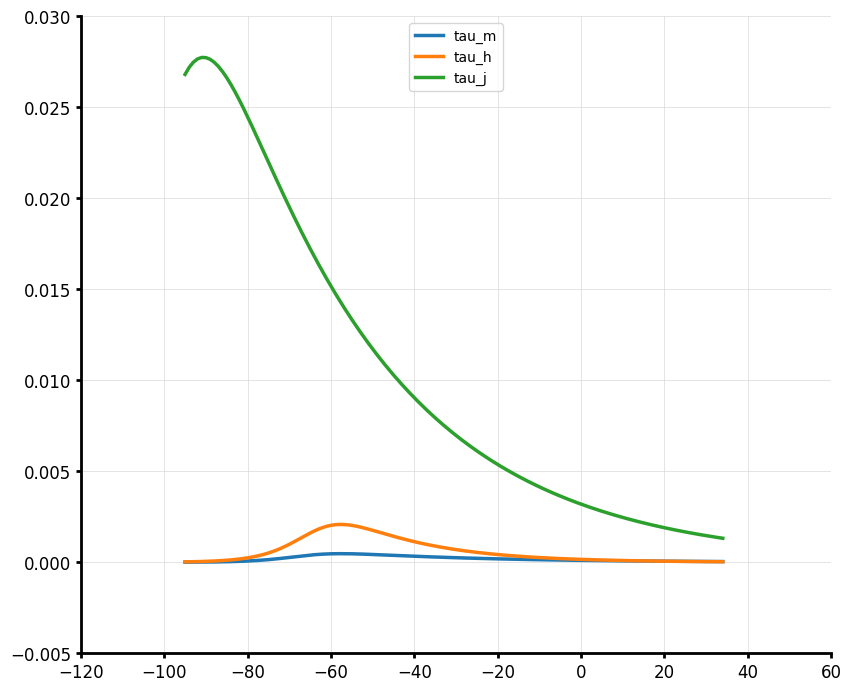

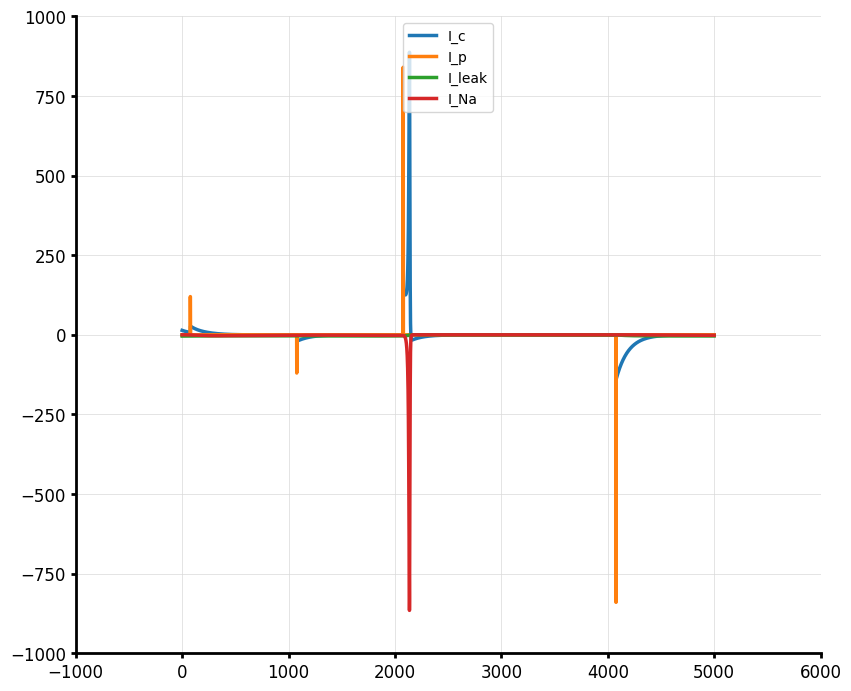

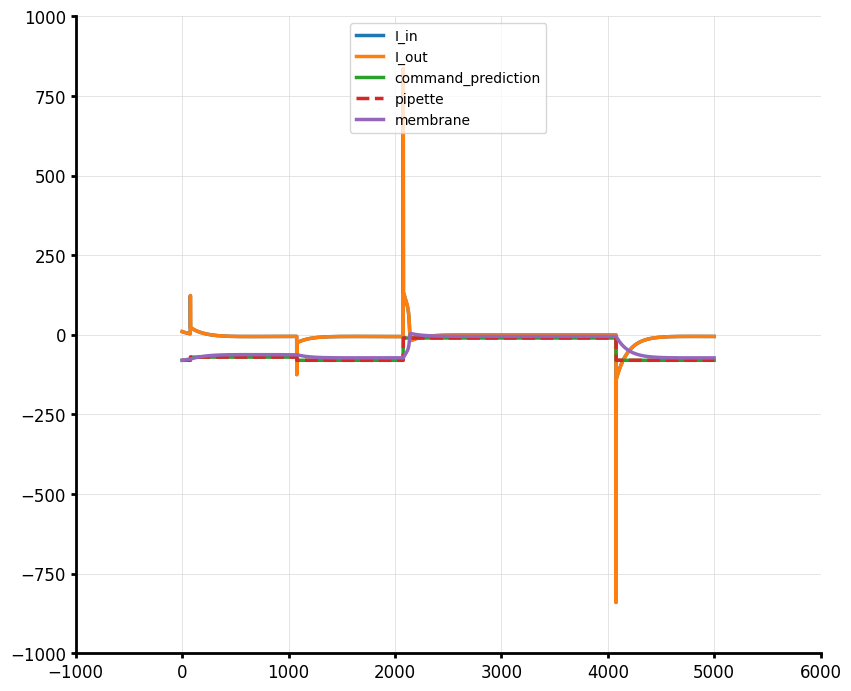

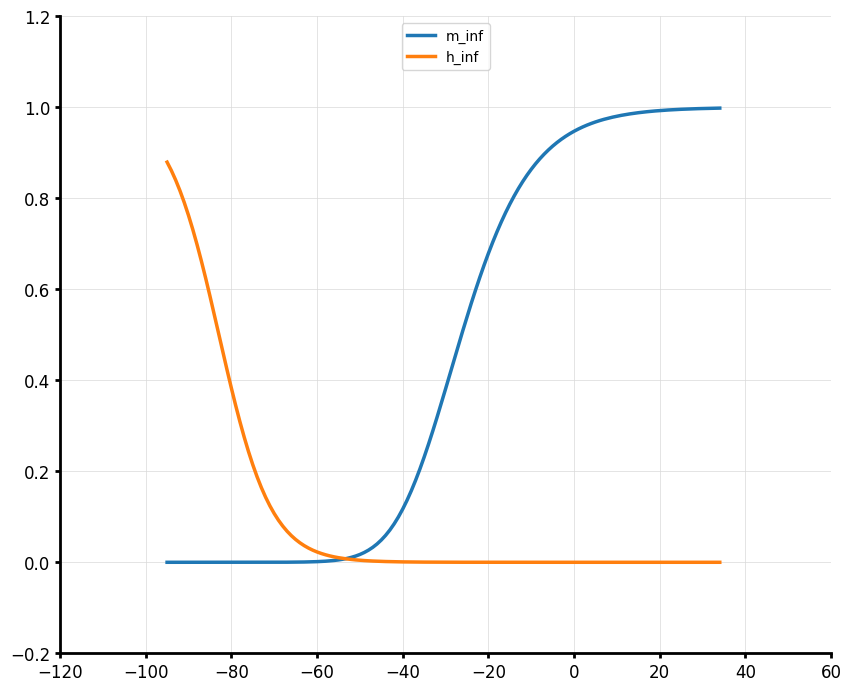

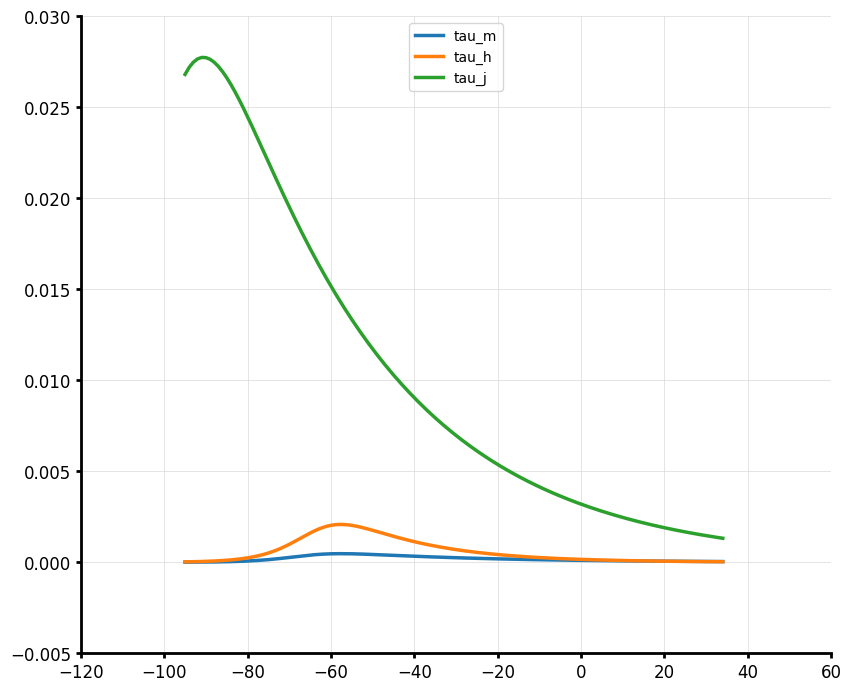

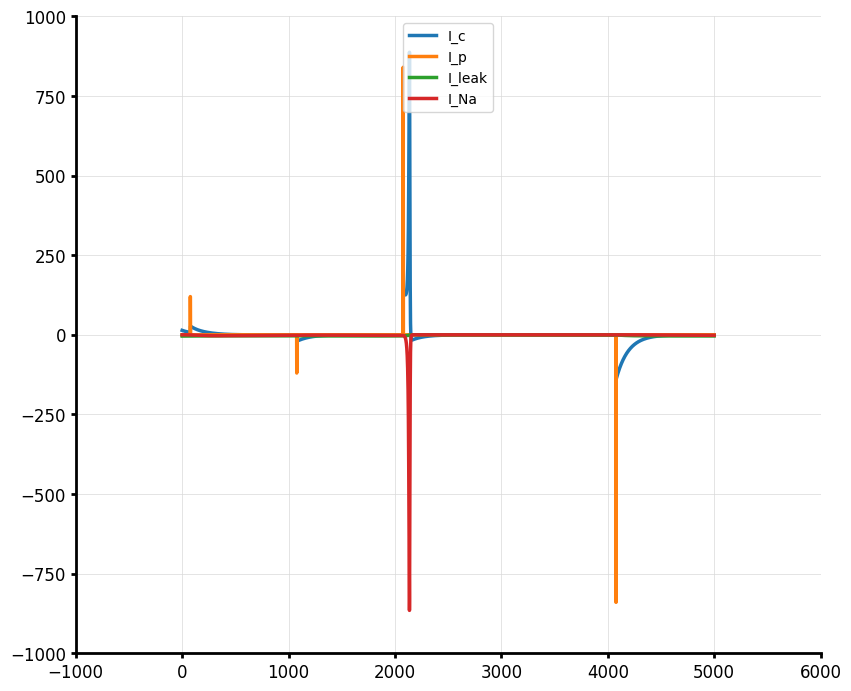

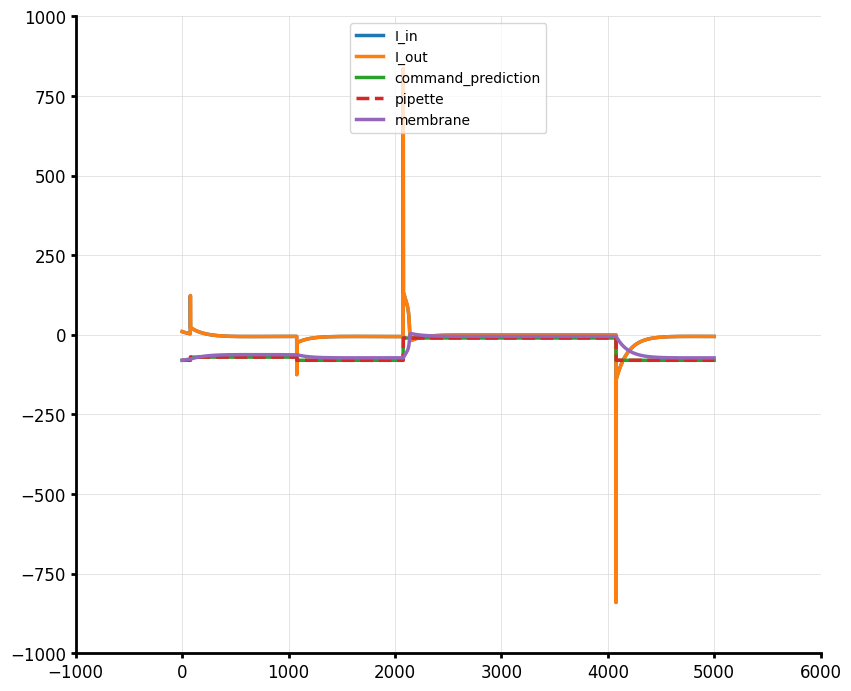

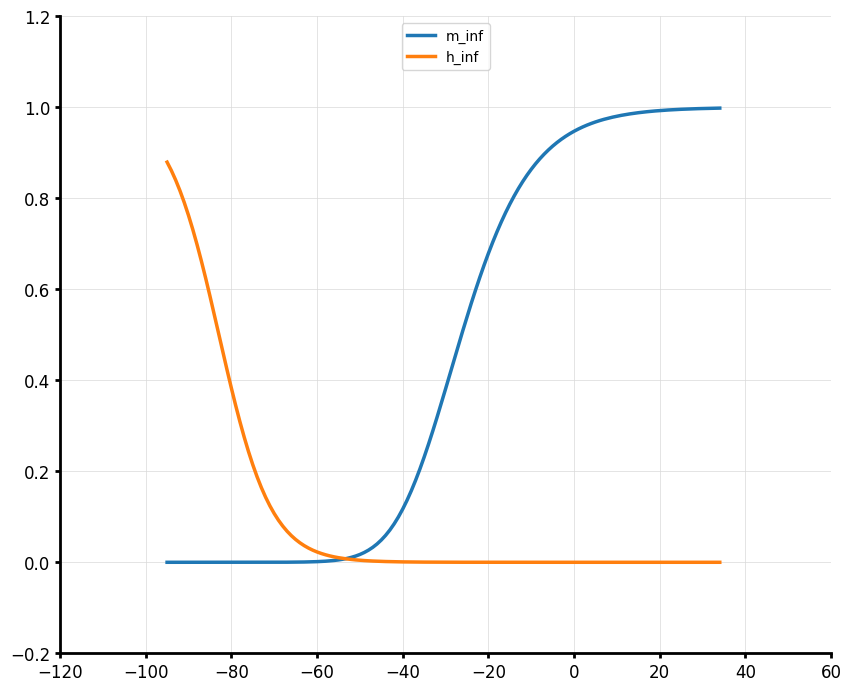

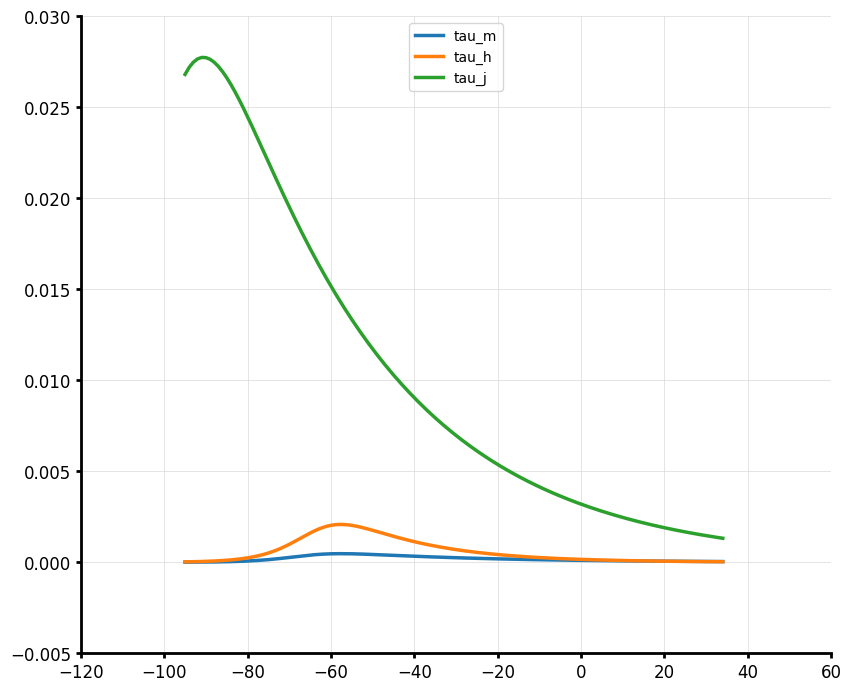

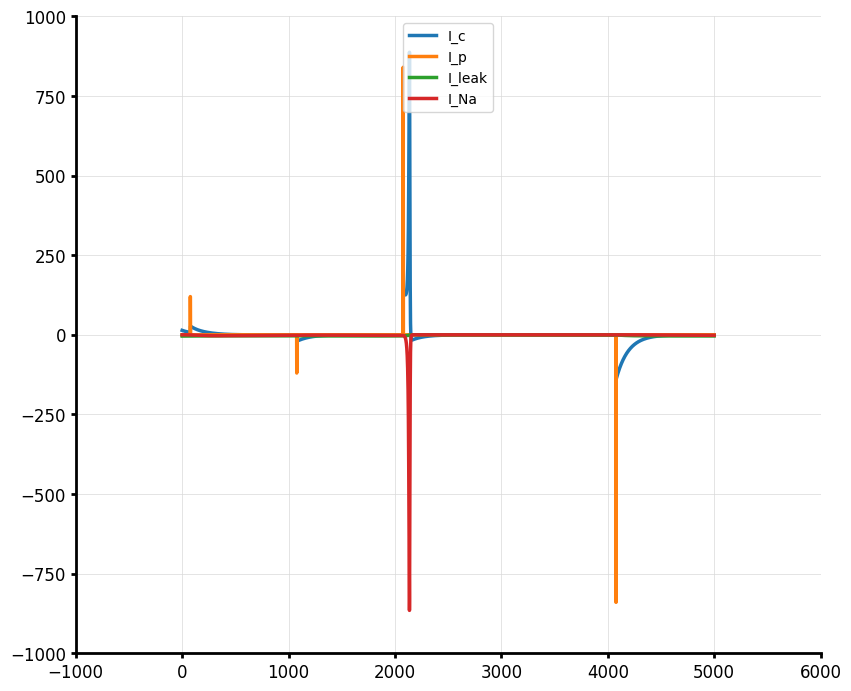

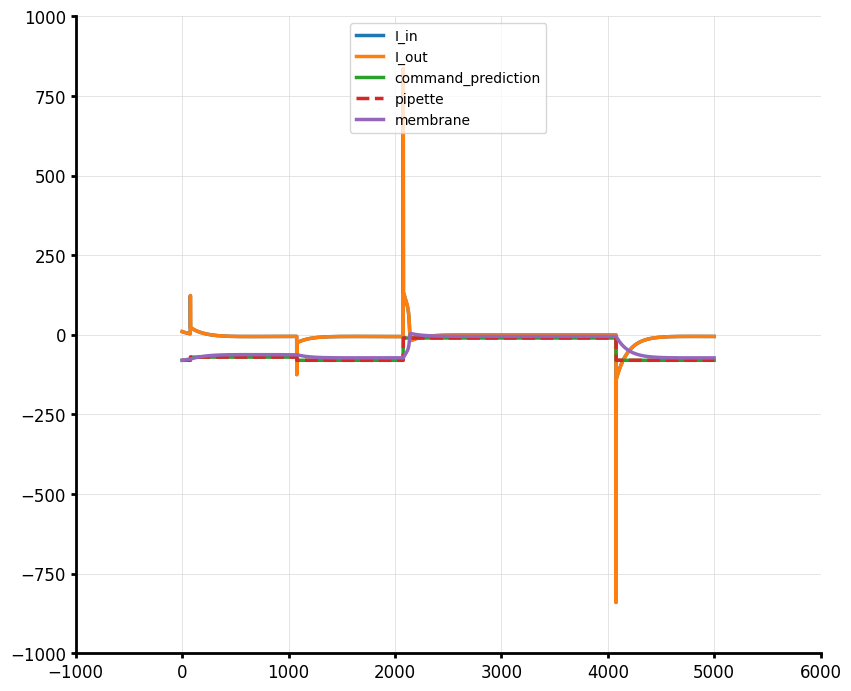

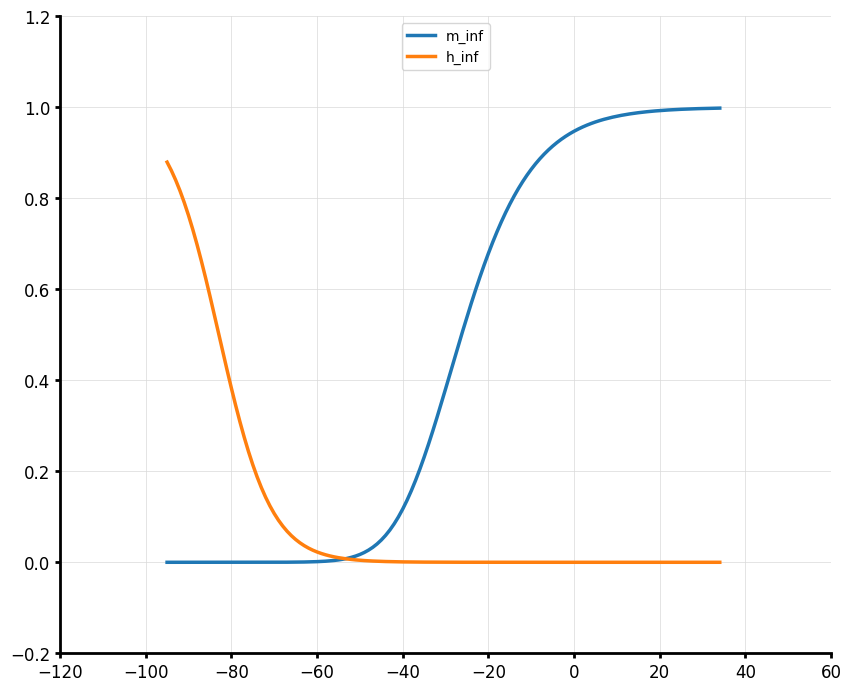

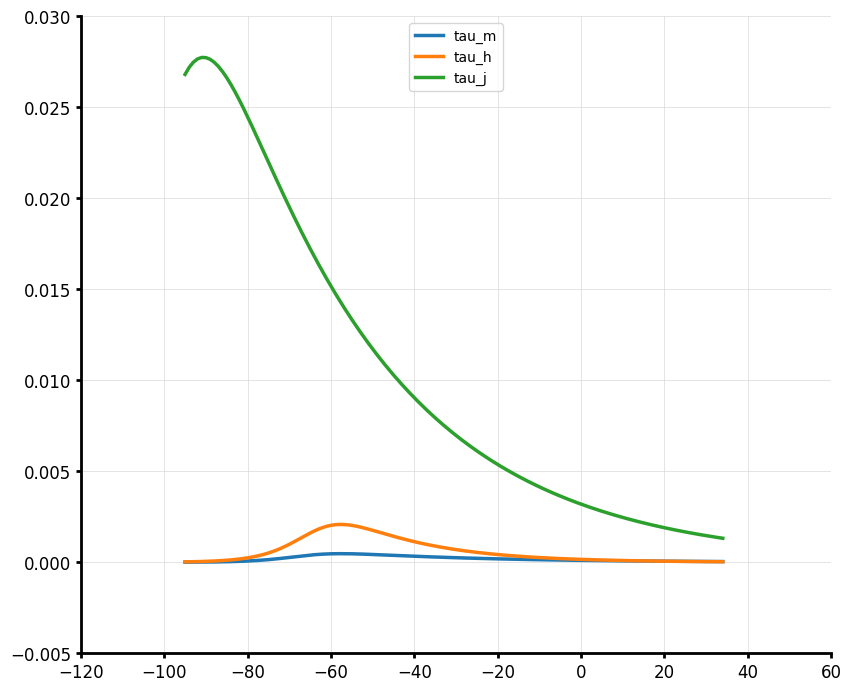

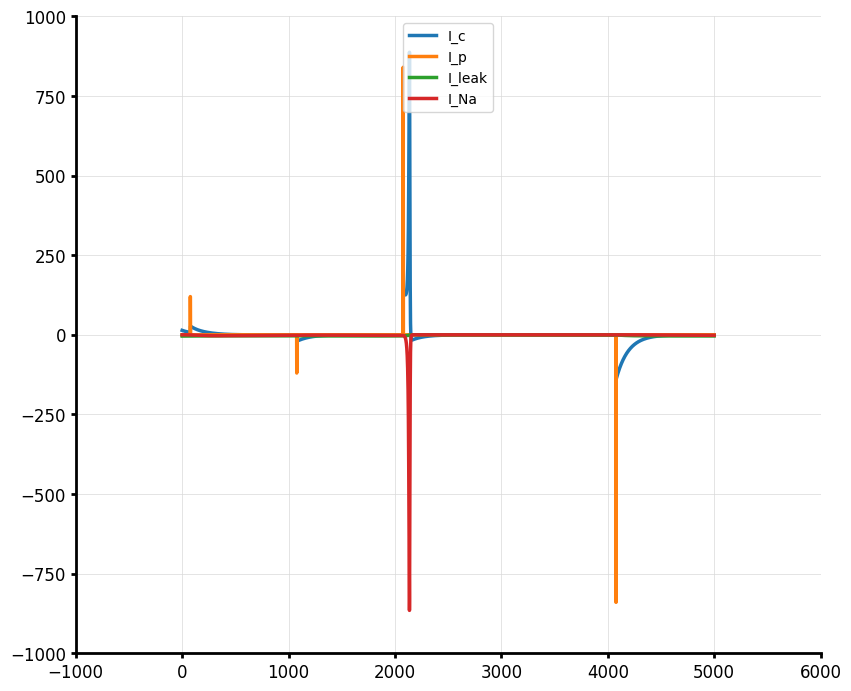

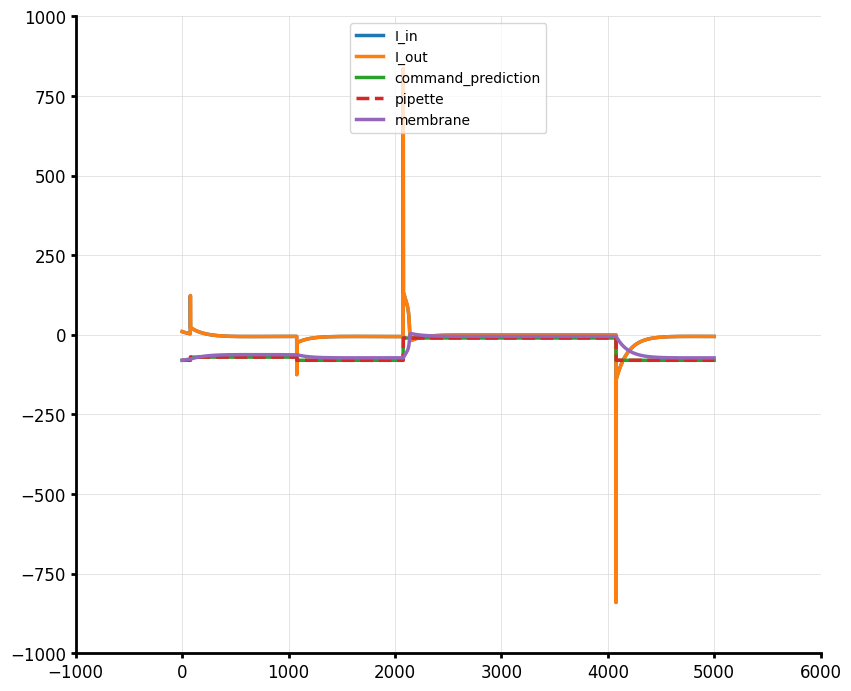

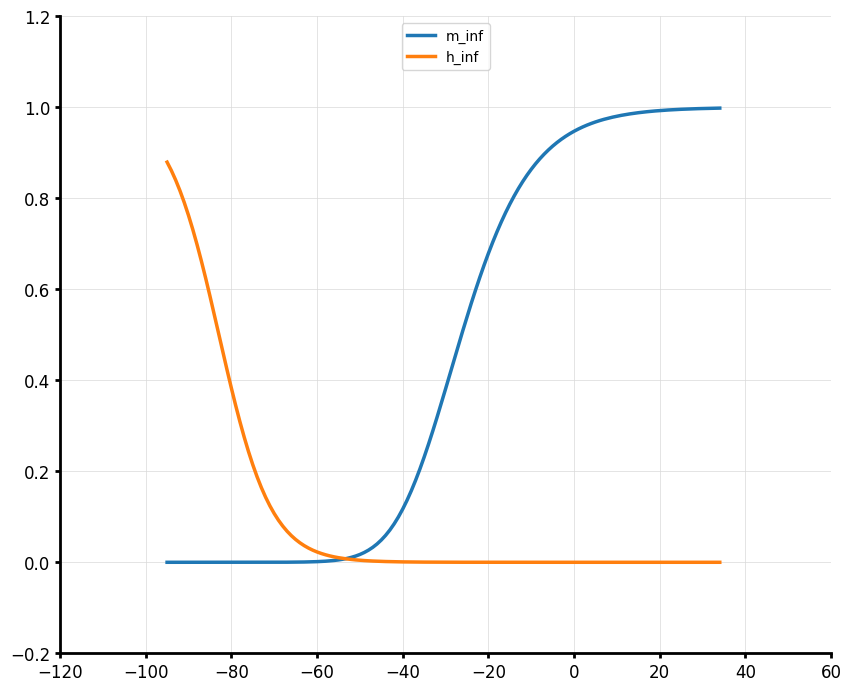

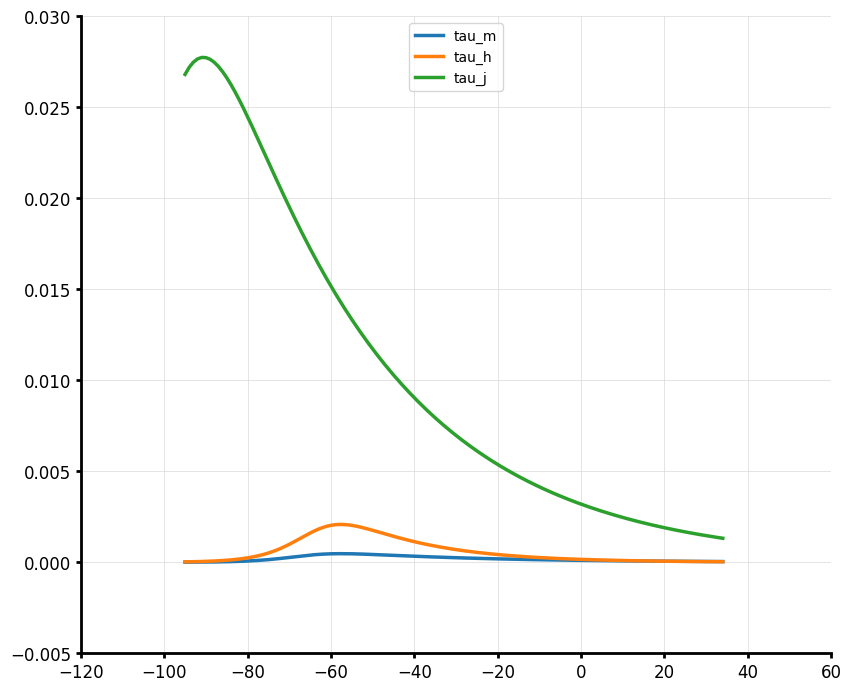

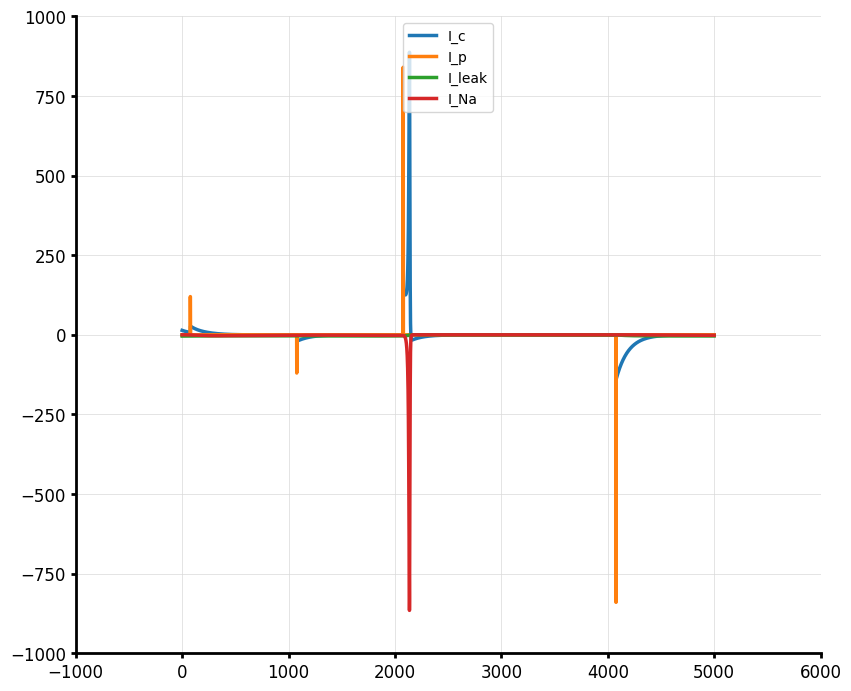

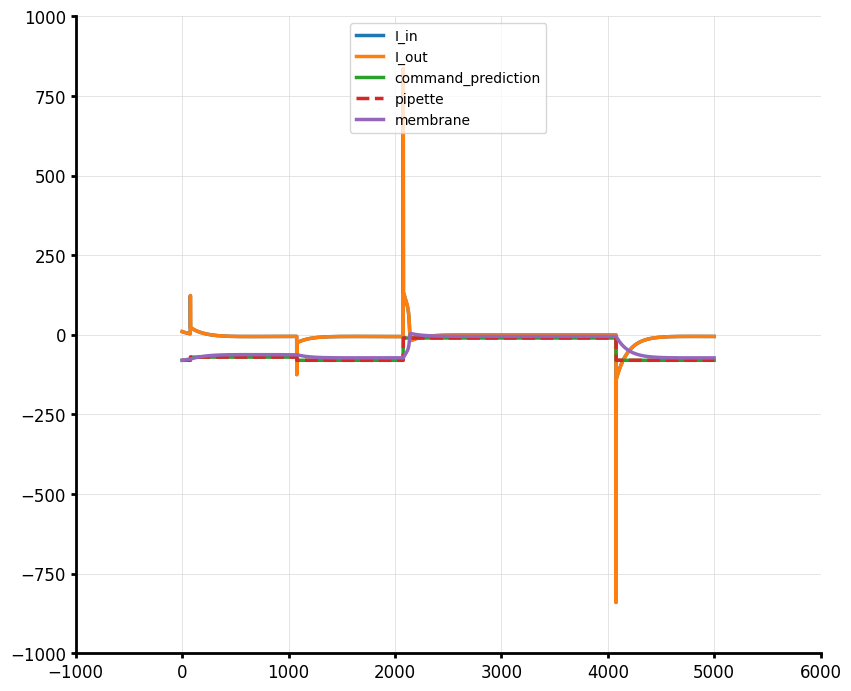

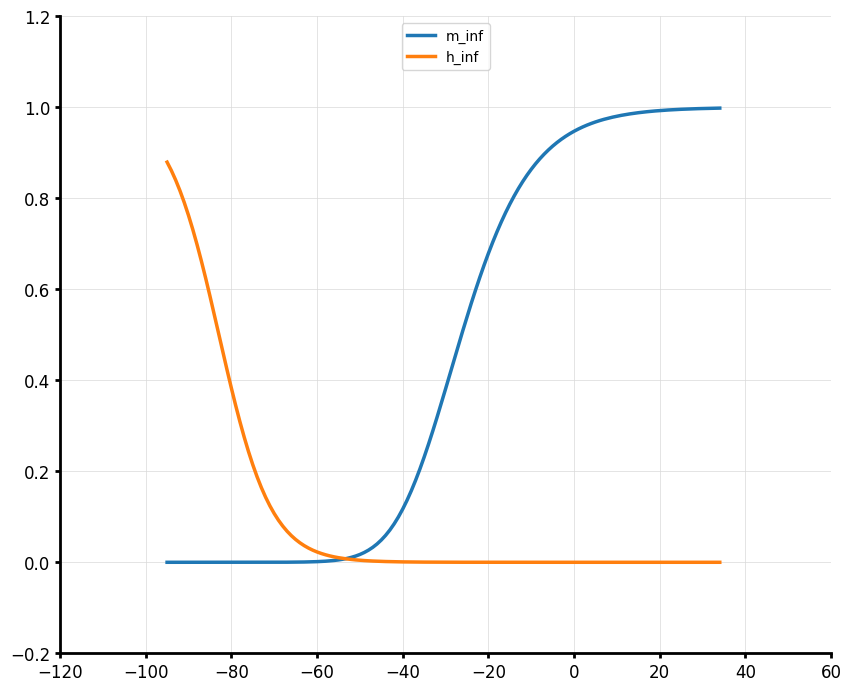

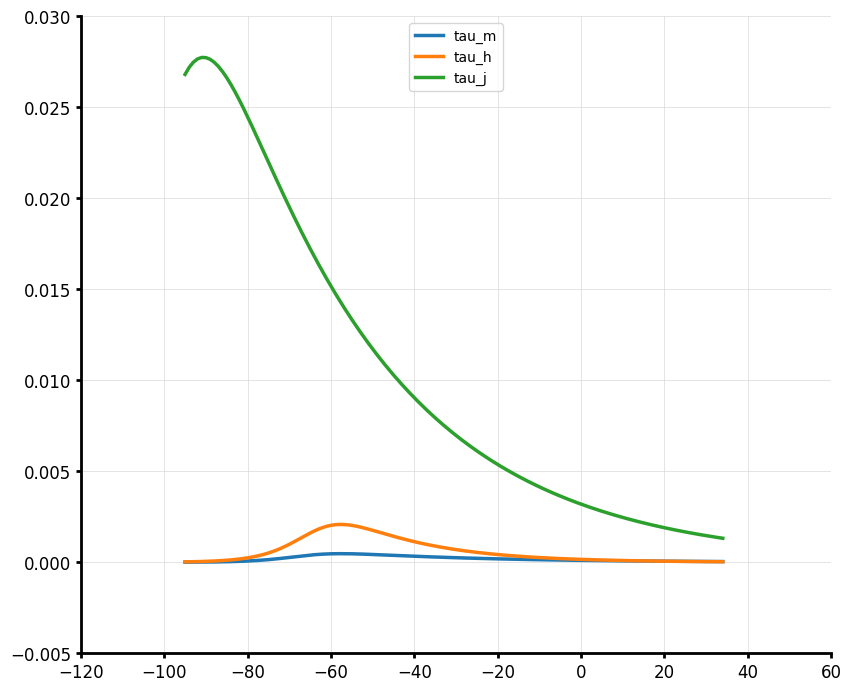

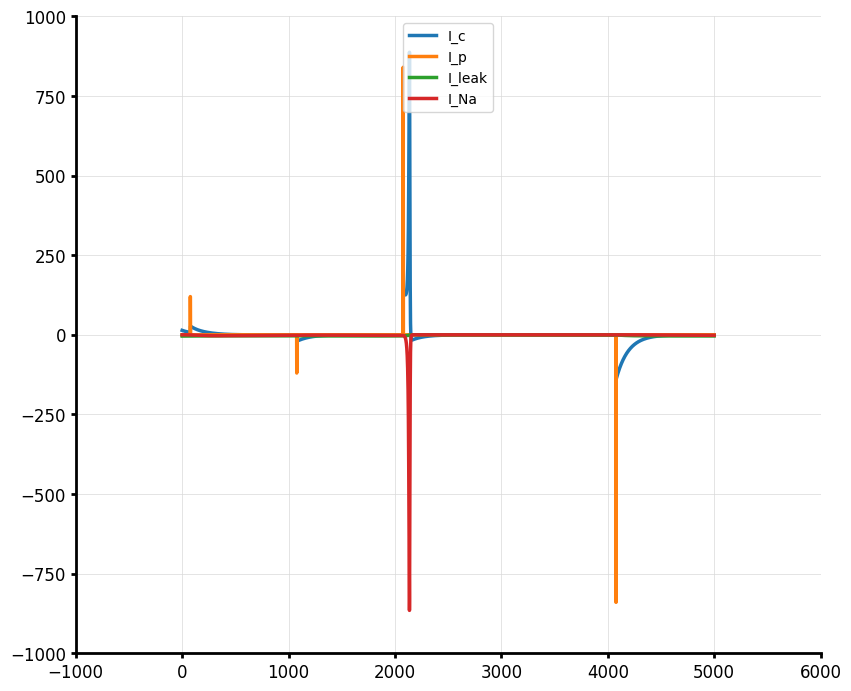

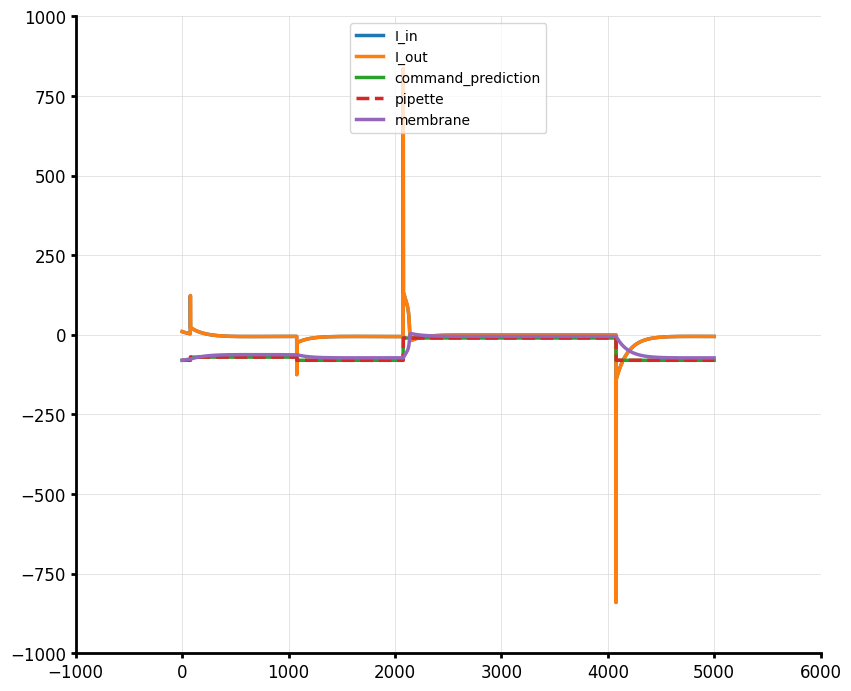

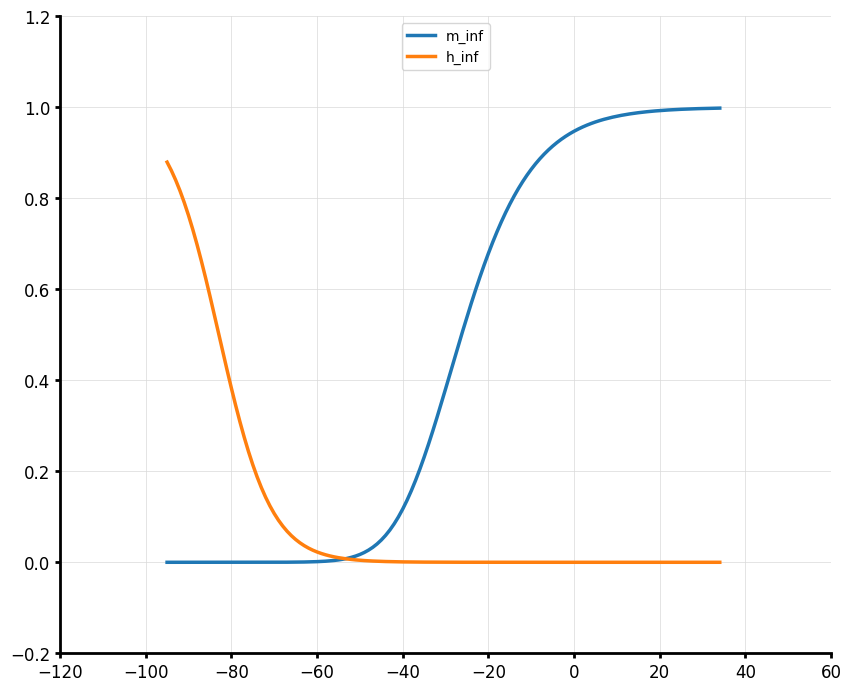

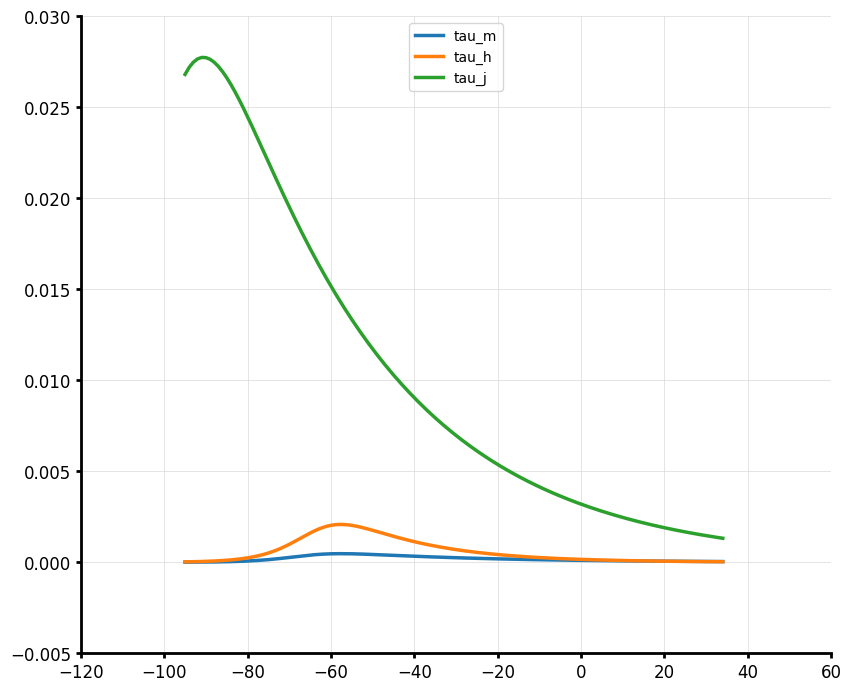

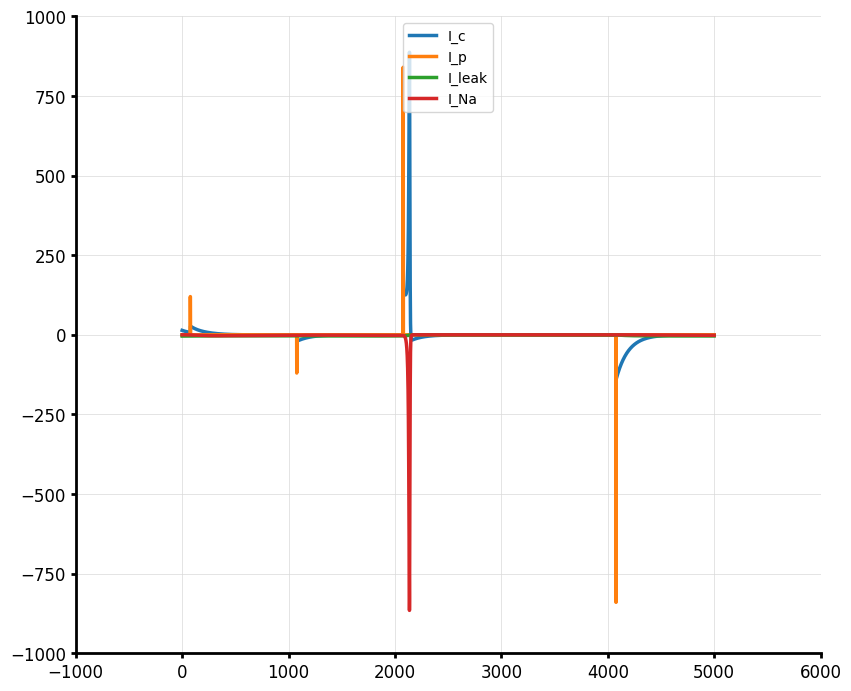

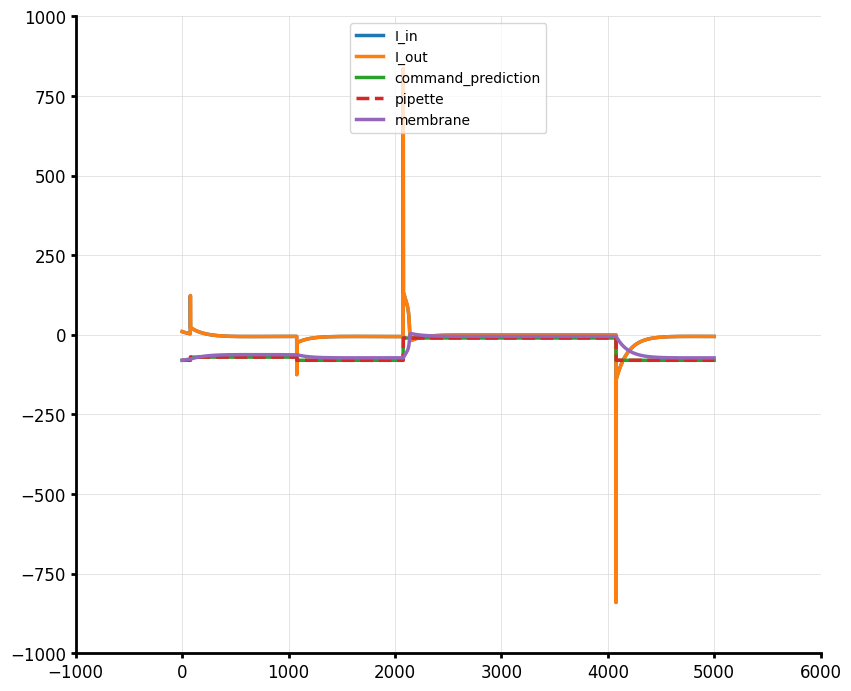

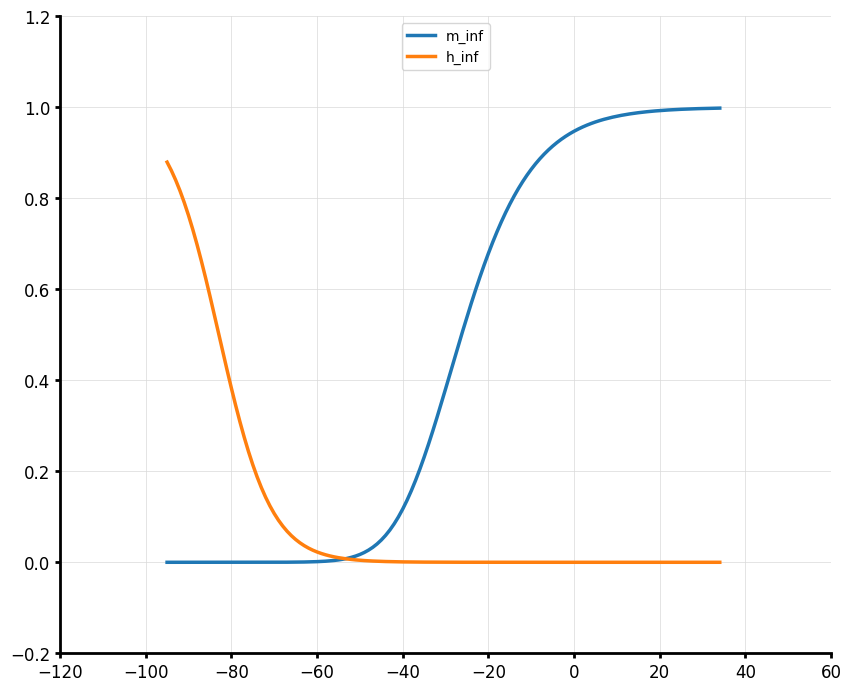

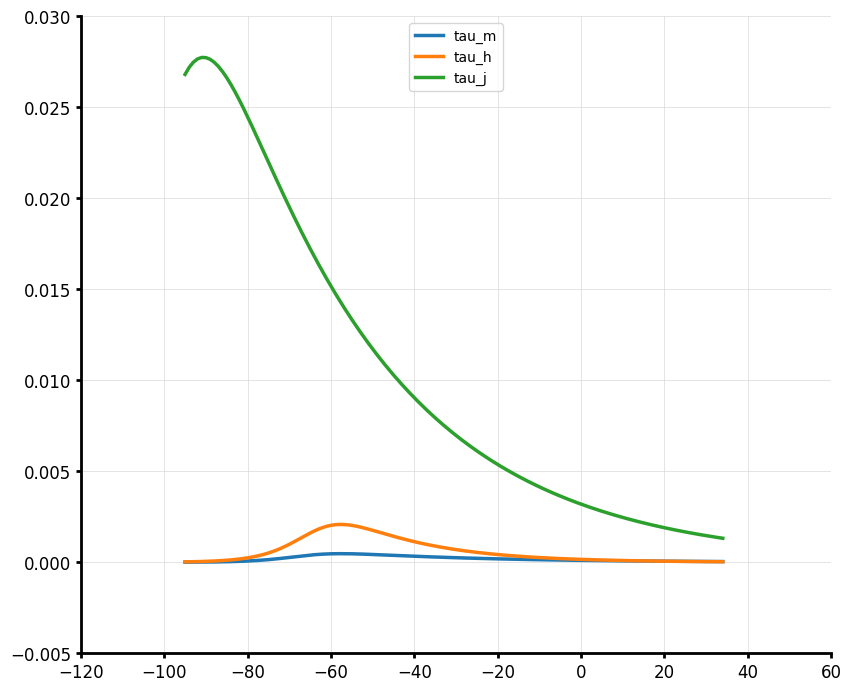

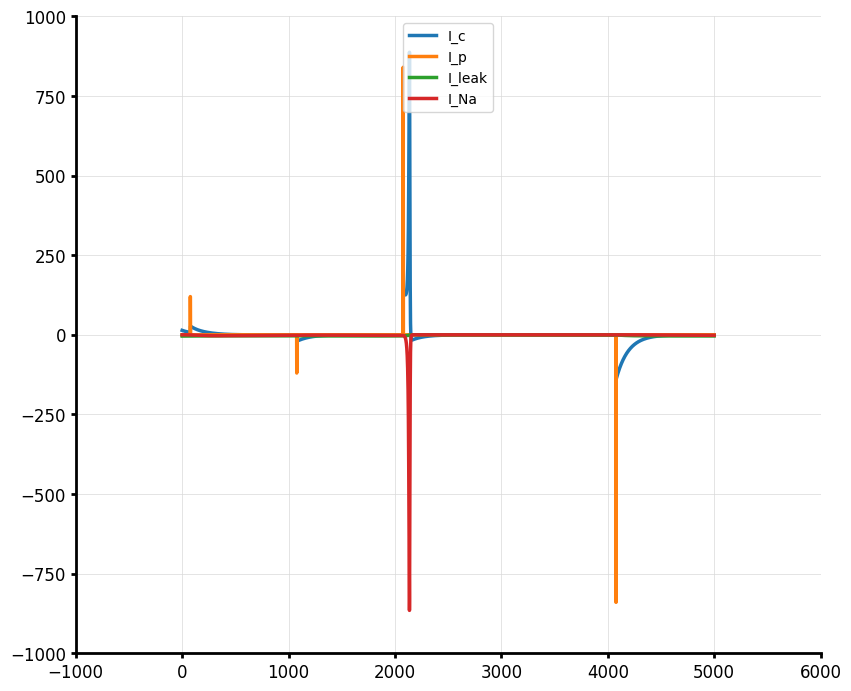

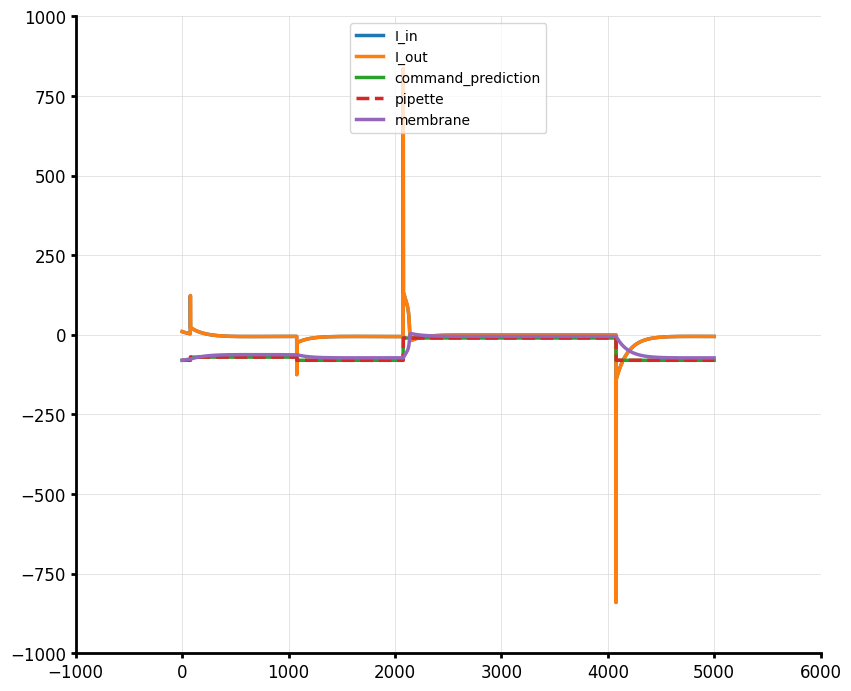

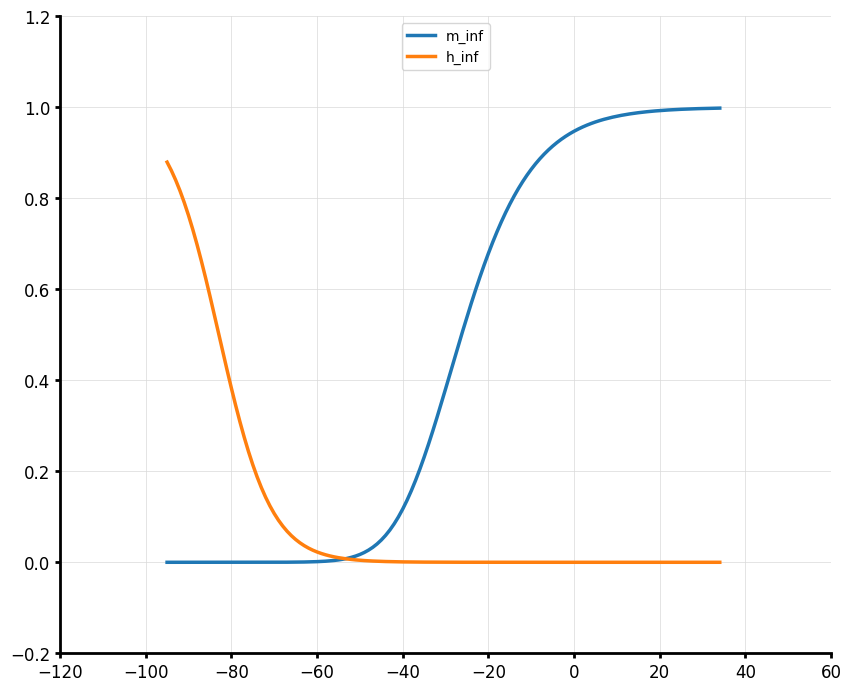

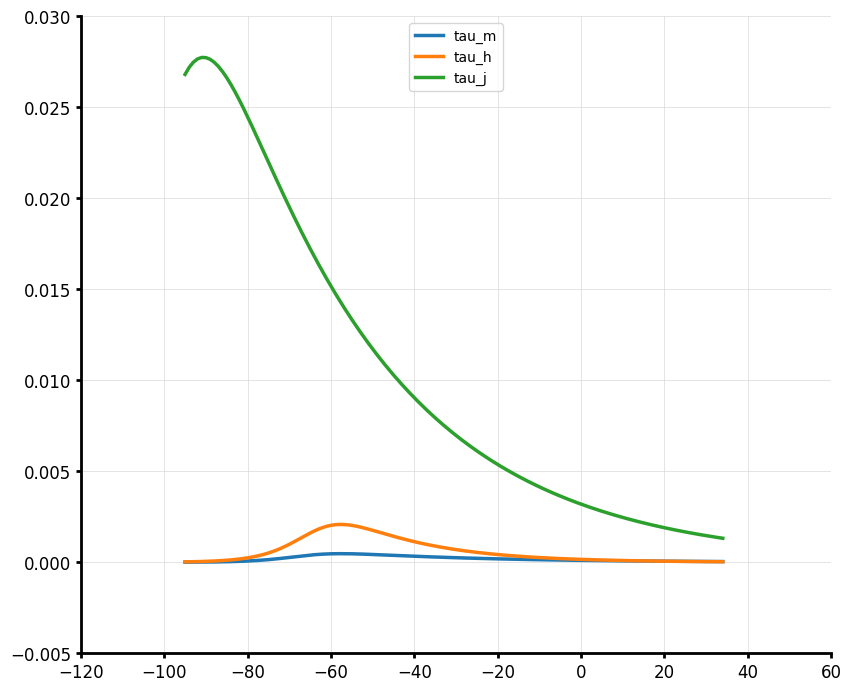

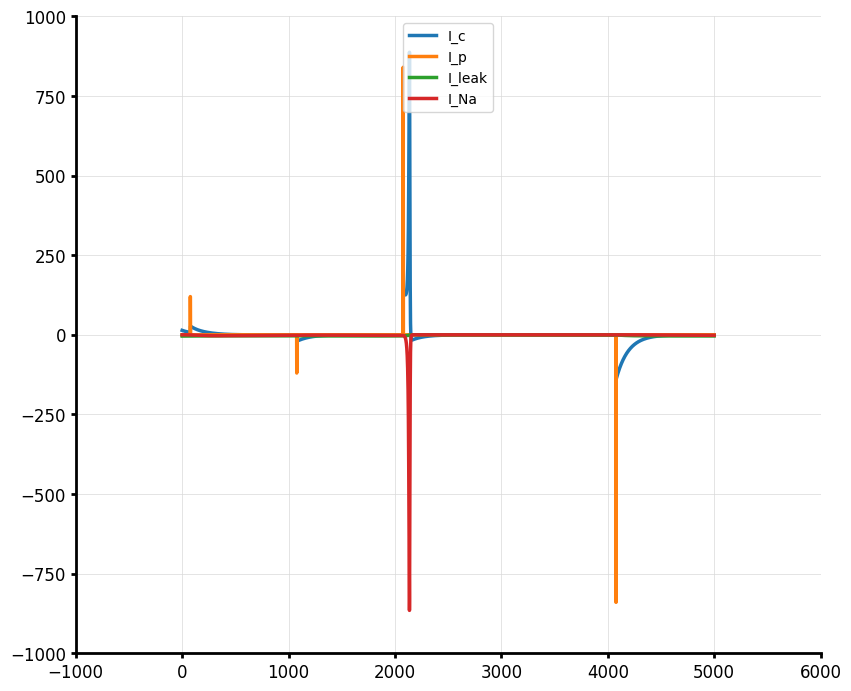

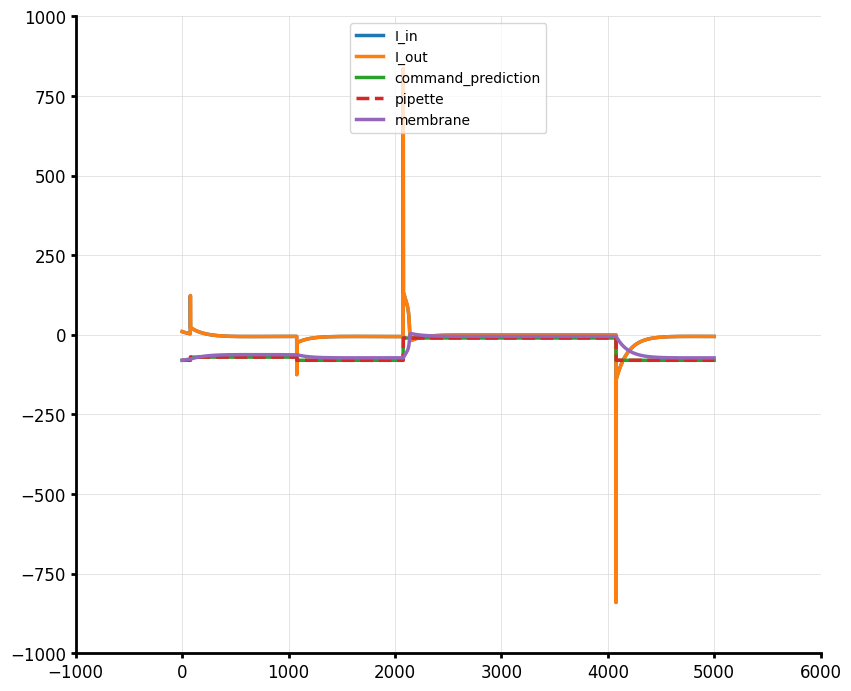

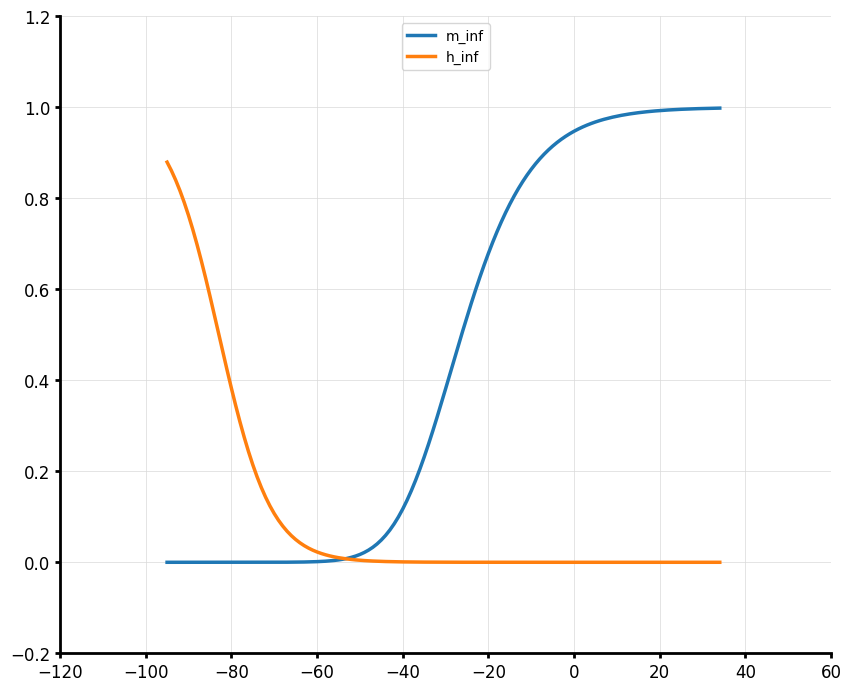

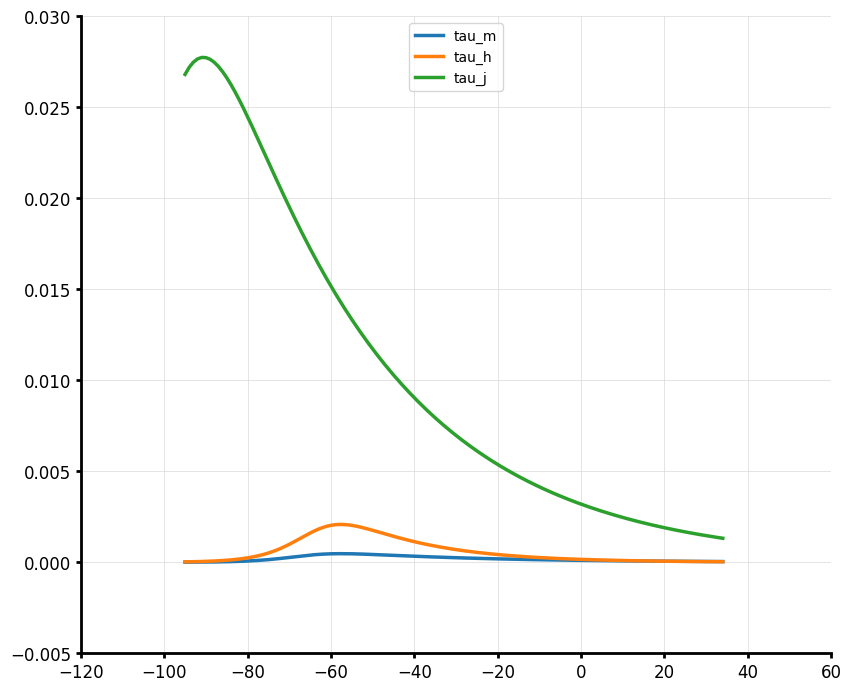

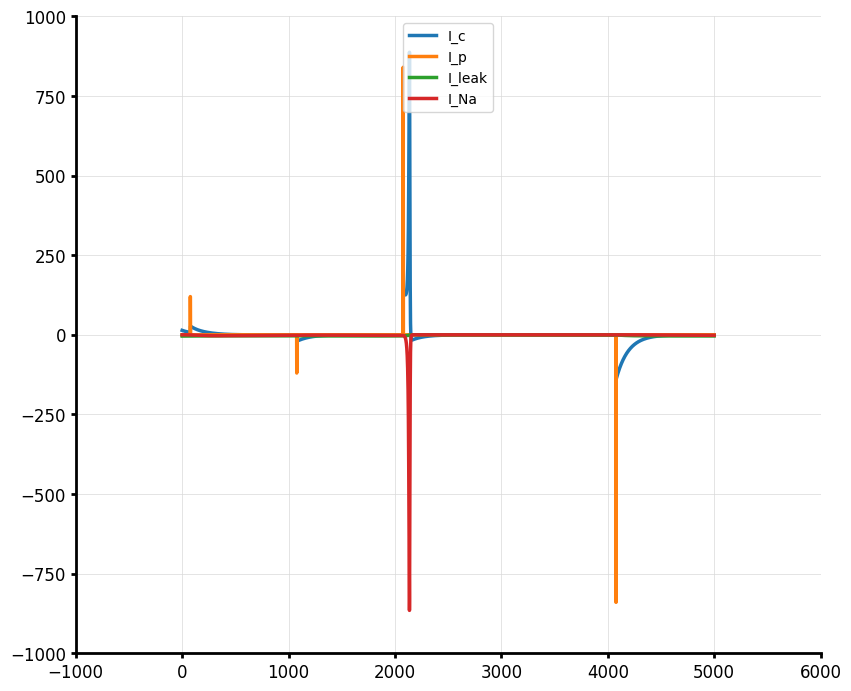

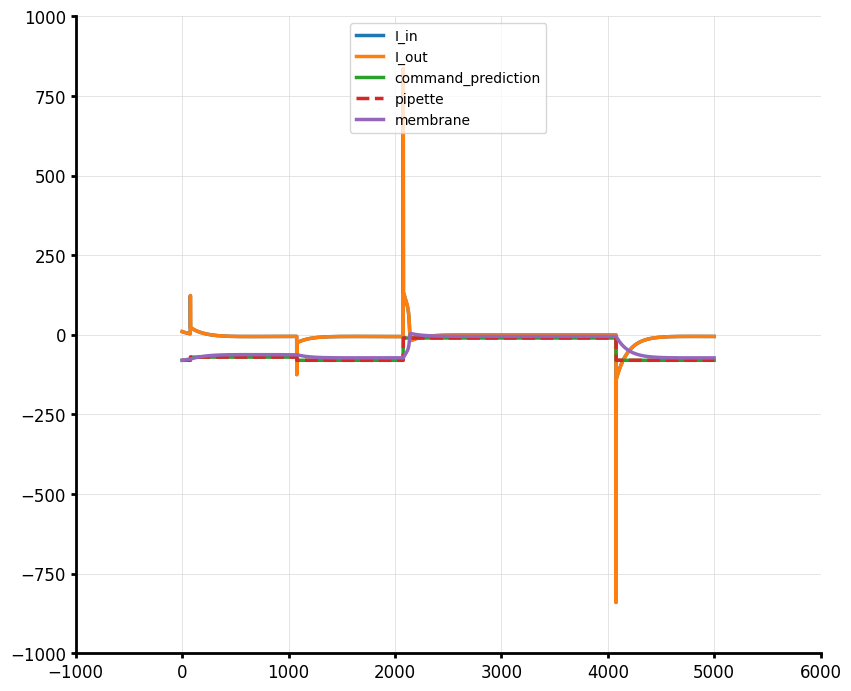

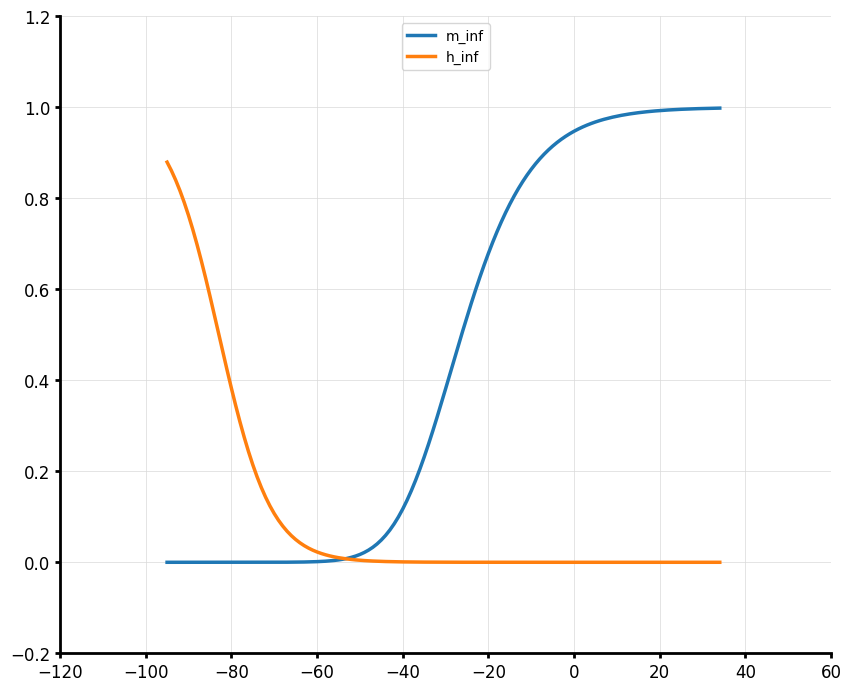

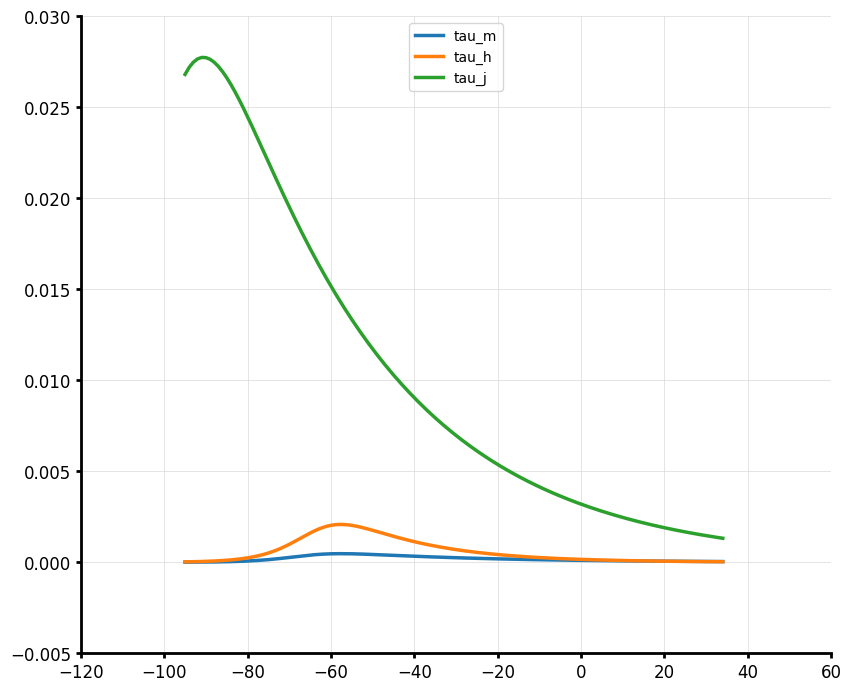

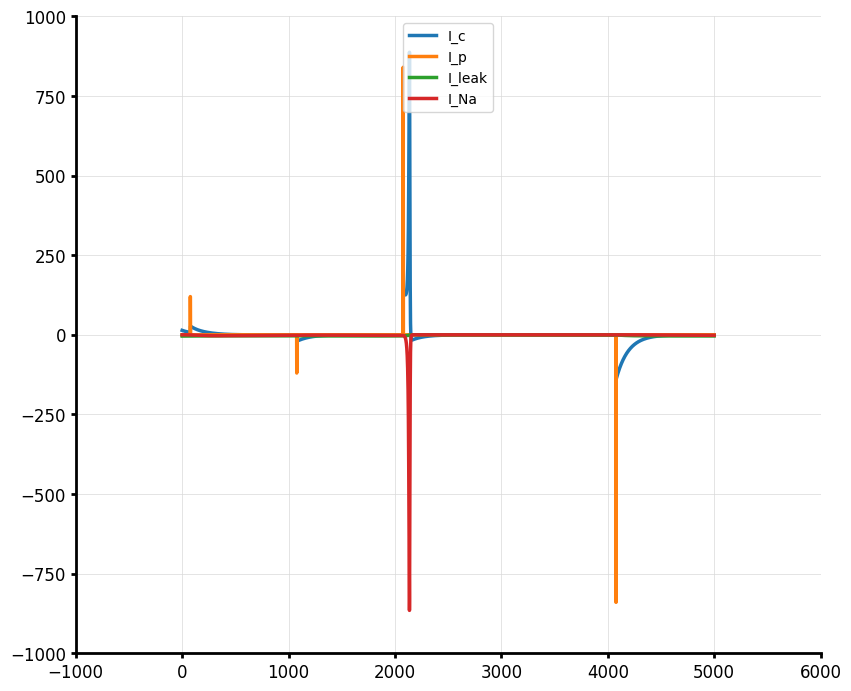

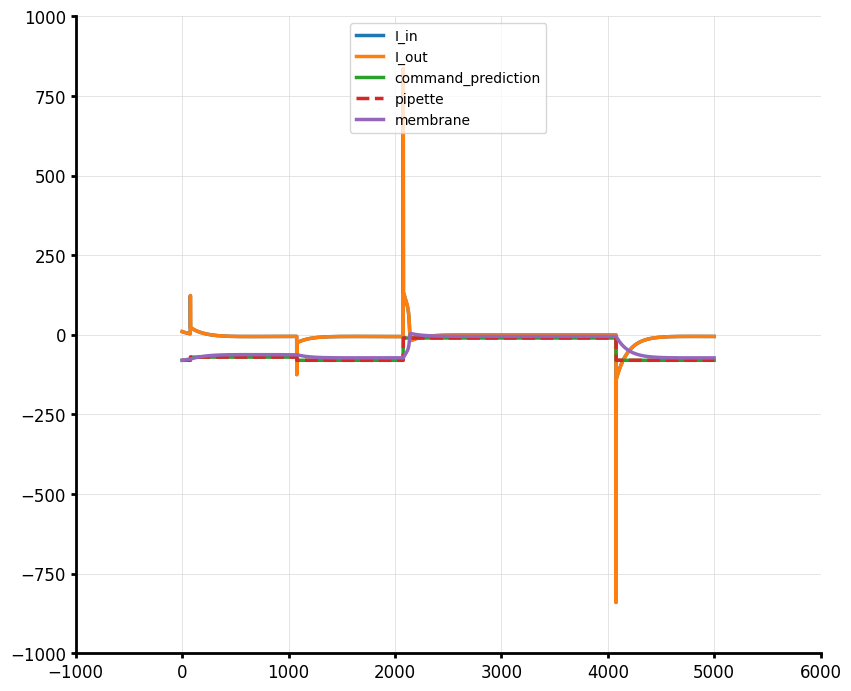

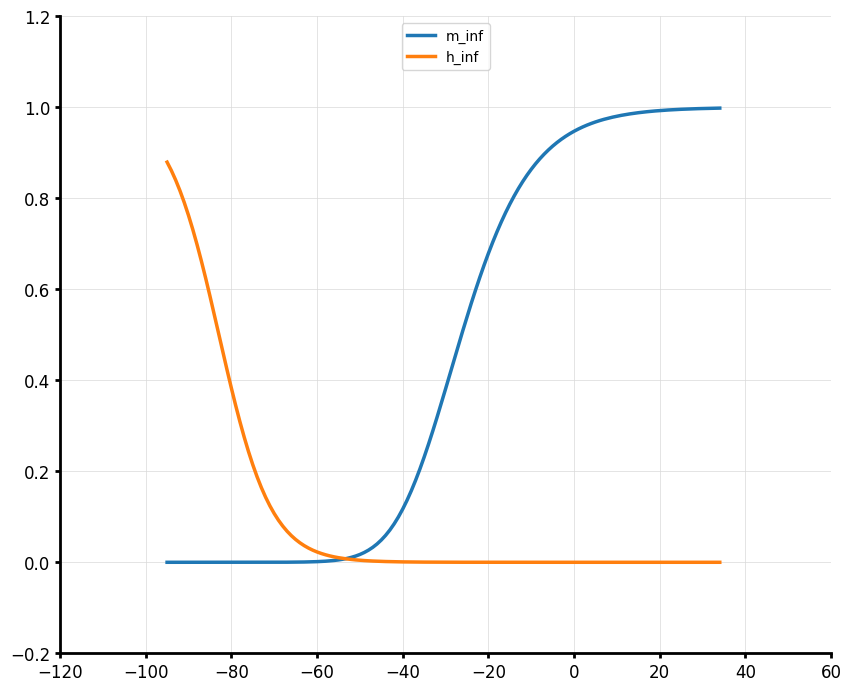

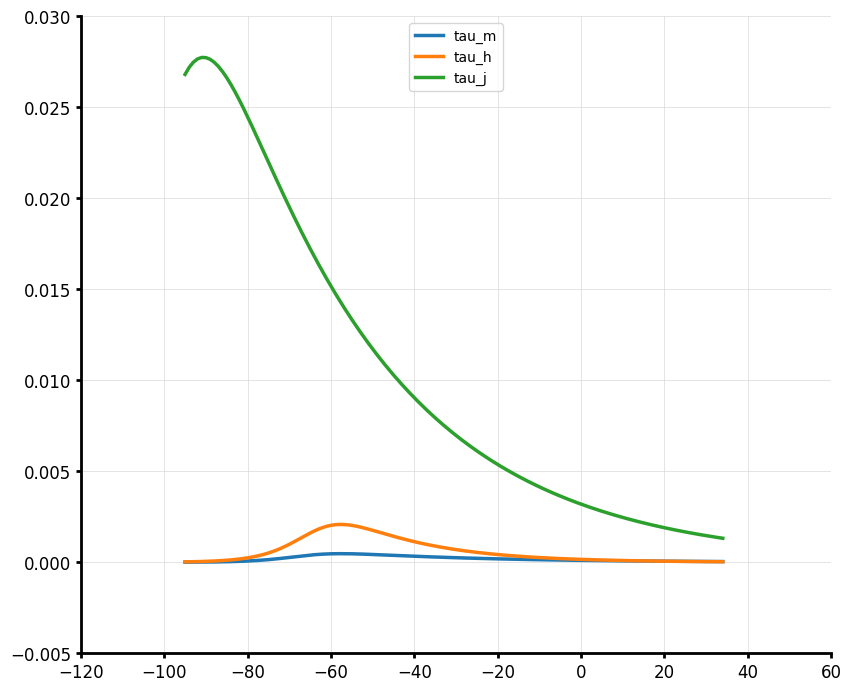

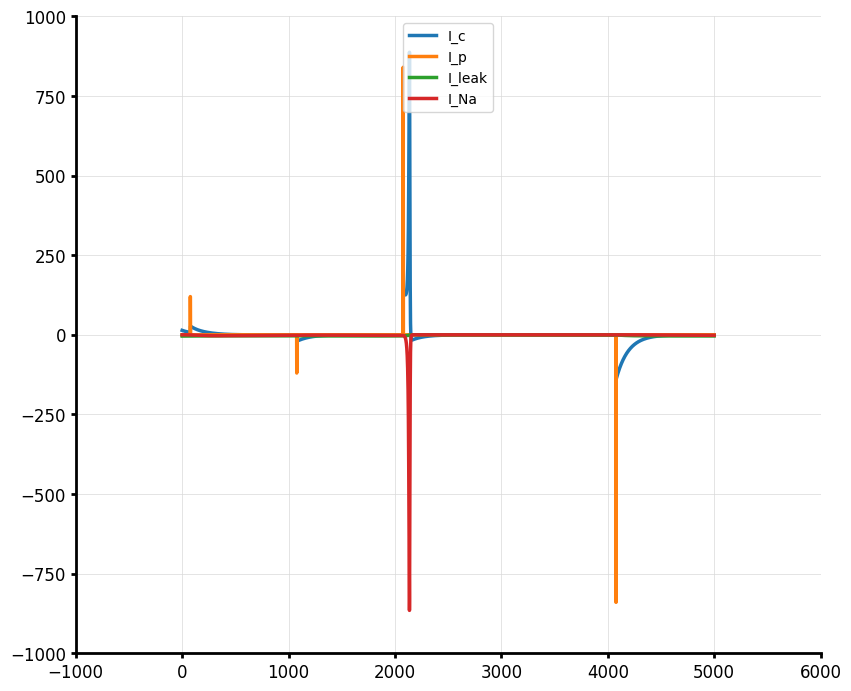

Error in callback <function flush_figures at 0x7faf7eb9f790> (for post_execute):


KeyboardInterrupt: 

In [71]:
%%timeit
#kwargs = dict(v_list = v_all,
#              k_list = k_all,
#              t = t_all,
#              log_scale = True,
#              graph = False)
loss(x_true_log, data, kwargs)

0.0

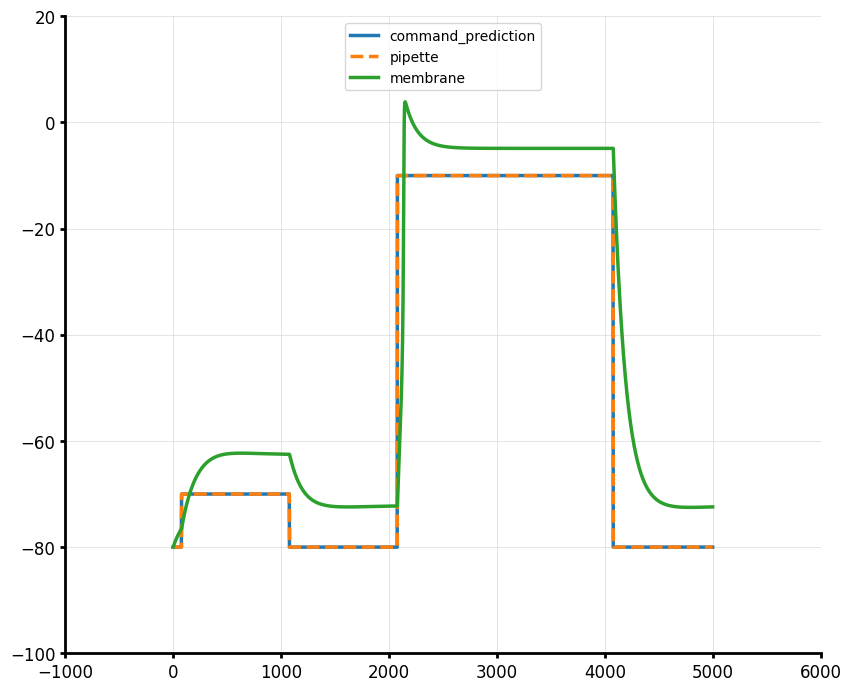

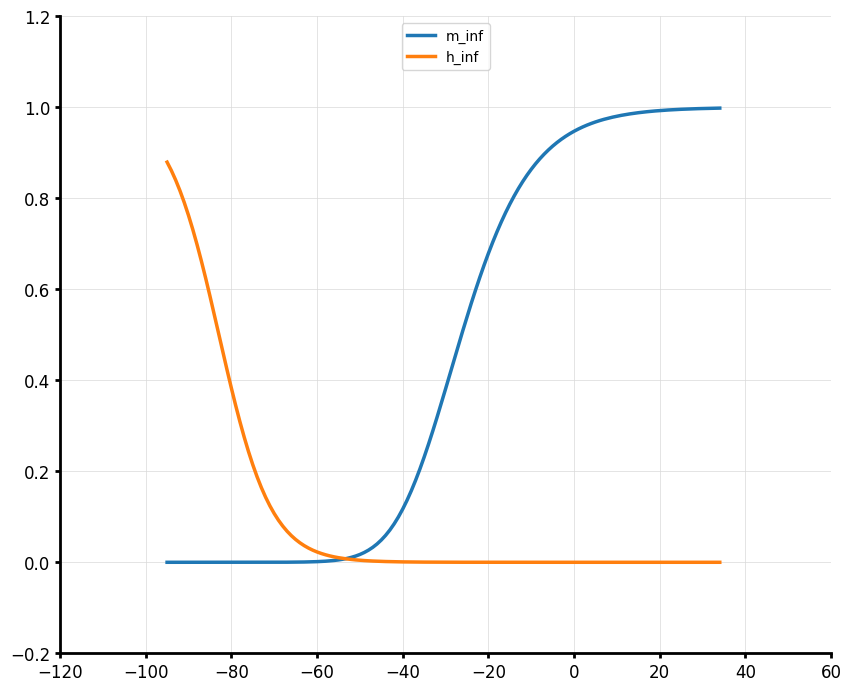

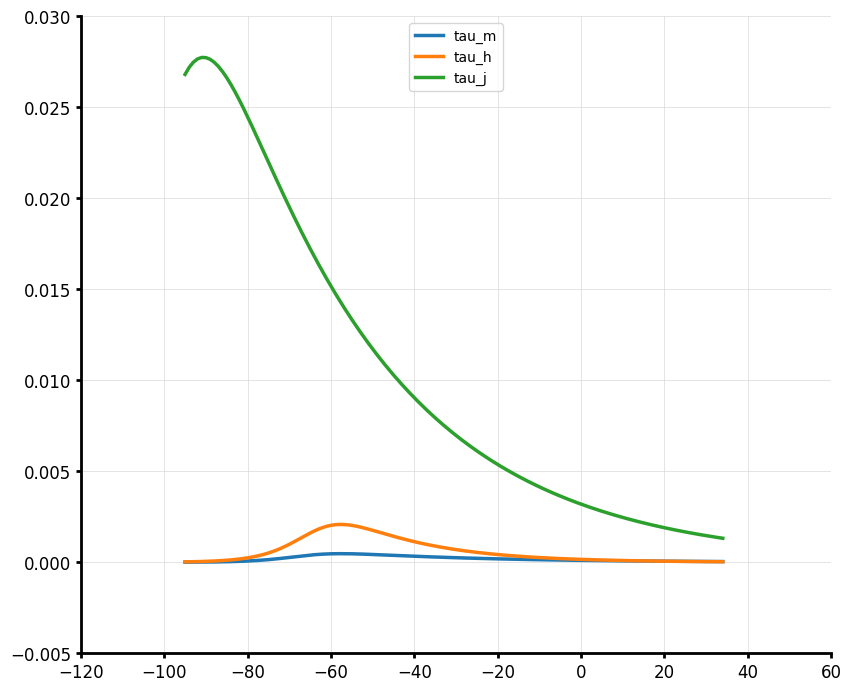

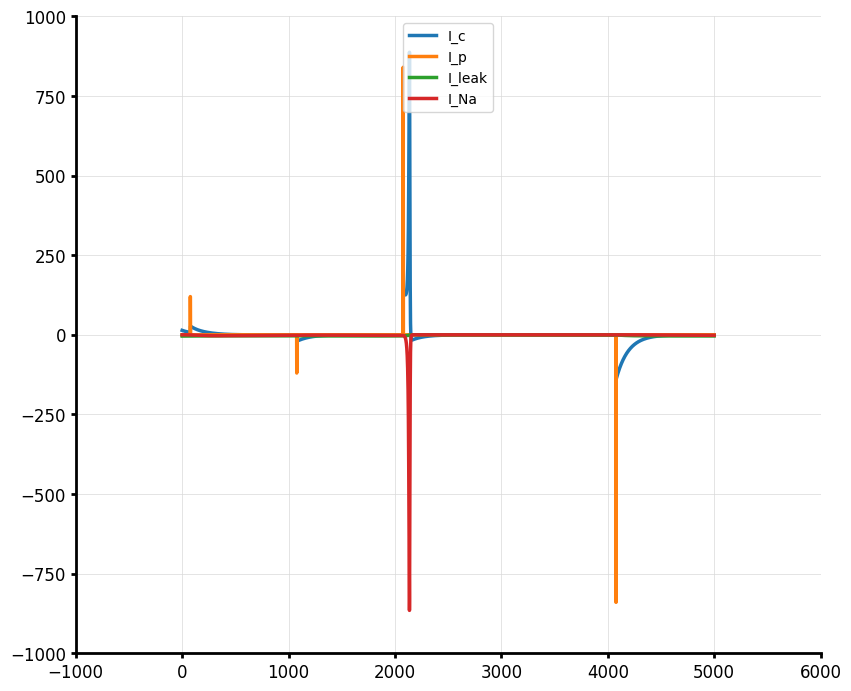

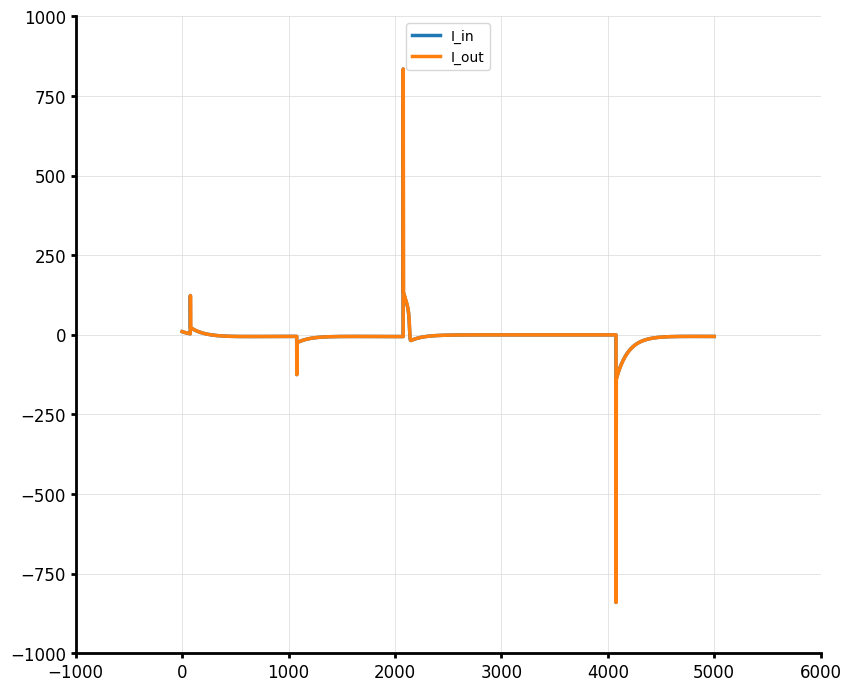

In [74]:
names =  ["C_f","C","a0_m","b0_m","s_m_1","s_m_2","a0_h","b0_h" ,"s_h_1","s_h_2", "R"   , "R_f"  ,\
          "g_max"  ,"g_leak", "v_half_m", "v_half_h", "k_m", "k_h","tau_z", "v_off" ]

#kwargs = dict(v_list = v_all,
#              k_list = k_all,
#              t = t_all,
#             log_scale = True,
#             graph = False)
x0 = x_true_log - 0.6
bounds = np.vstack([x_true_log  - 1, x_true_log + 1]).T
#bounds = ([1e-18, 1e-13, 1e-10, 1e-10, 1e-10,  1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e5,  1e3,  1e-5, 1e-5,  1e-4,     1e-4,   1e-4,1e-4,1e-4],
#          [1e-11,  1e-10, 1e8,   1e6,   1,      1e4,   1e8,   1e8,   1,     1e8,   1e15, 1e15, 1e5,  1e5,   100,      100,    1e2, 1e2,1e8])
#log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T

loss(x_true_log, data, kwargs)

array([16.03464544, 16.03464544, 15.08391769, ..., -2.05900417,
       -2.05900417, -2.05900417])

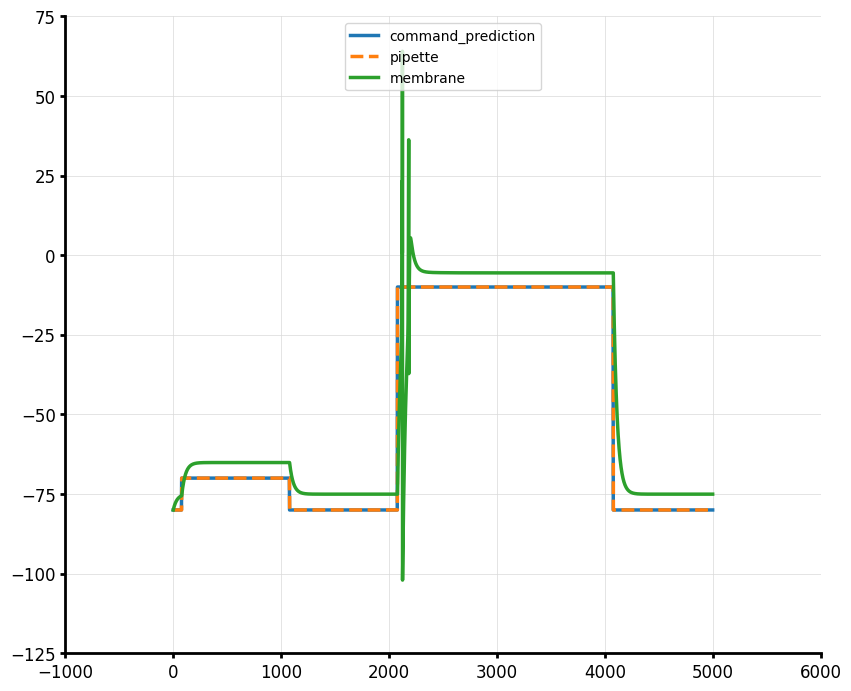

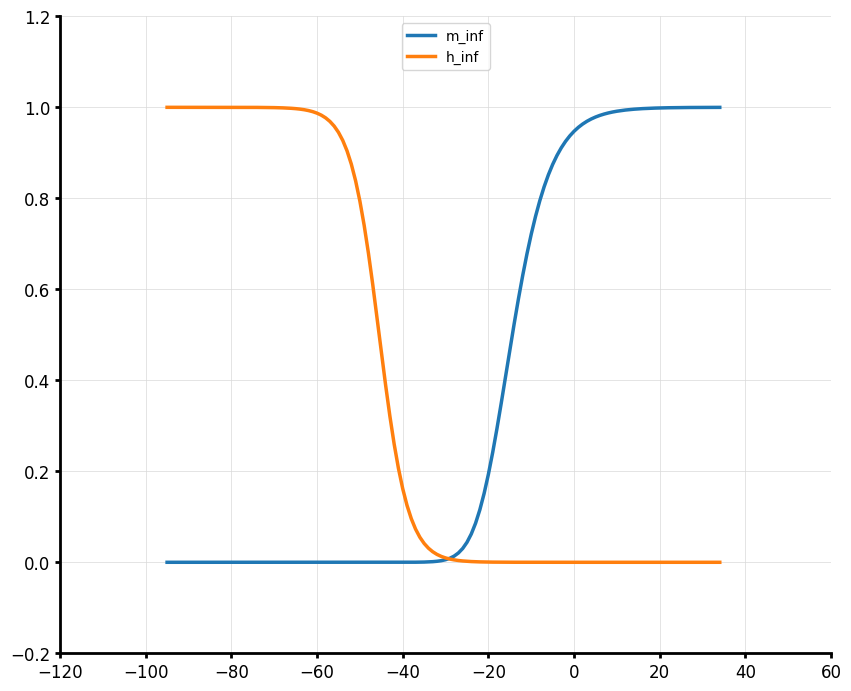

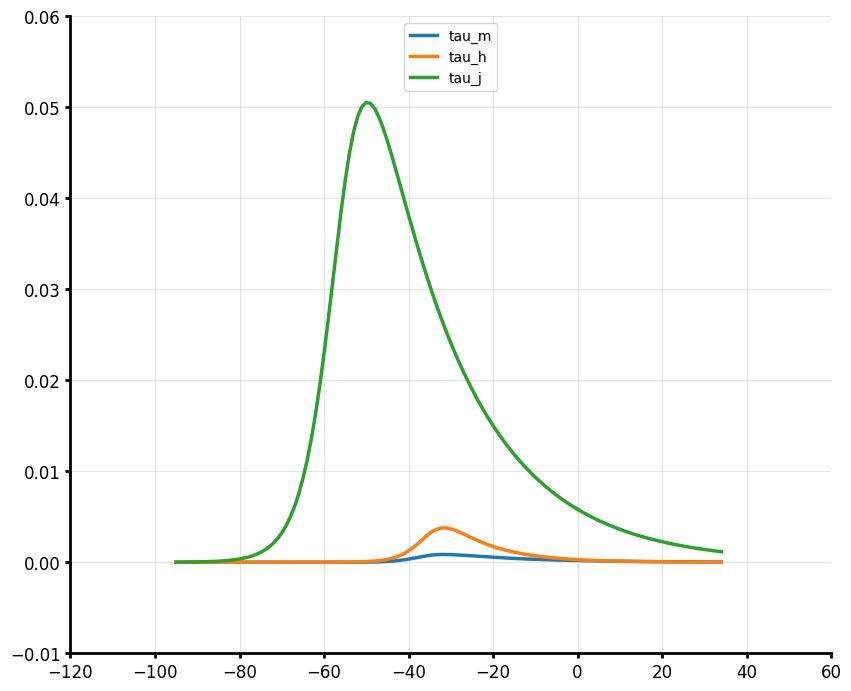

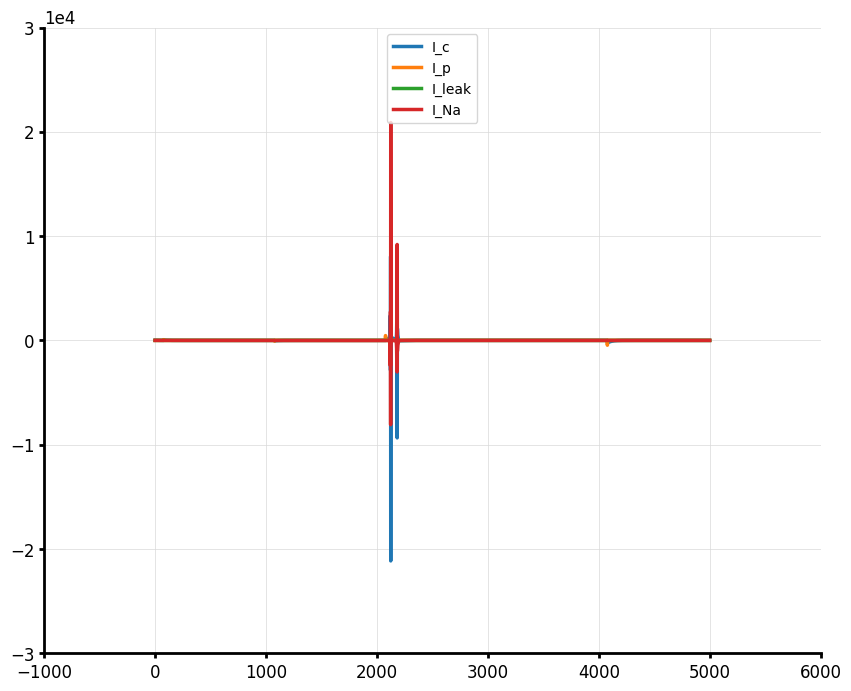

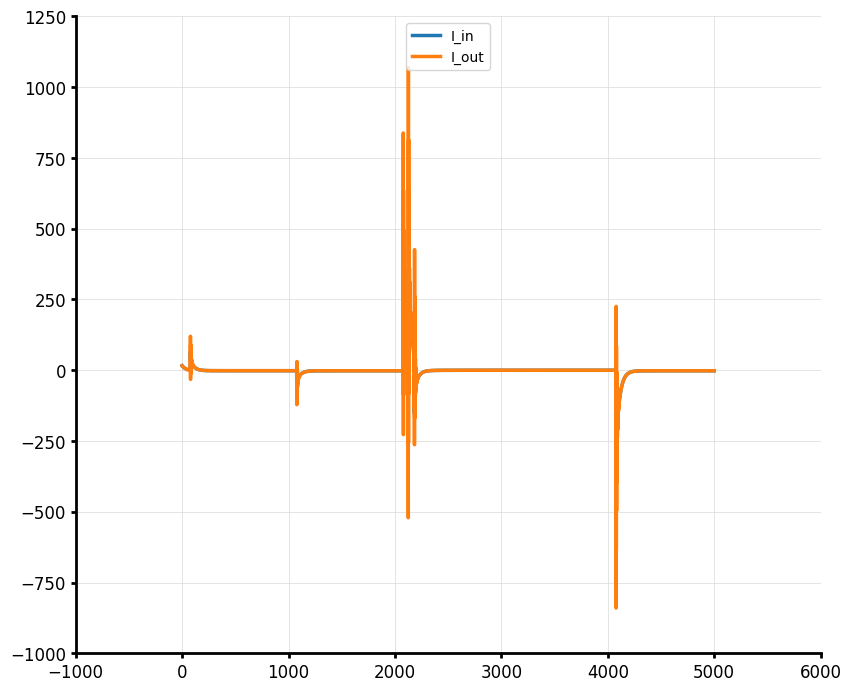

In [75]:
calculate_I_out(x0, kwargs)

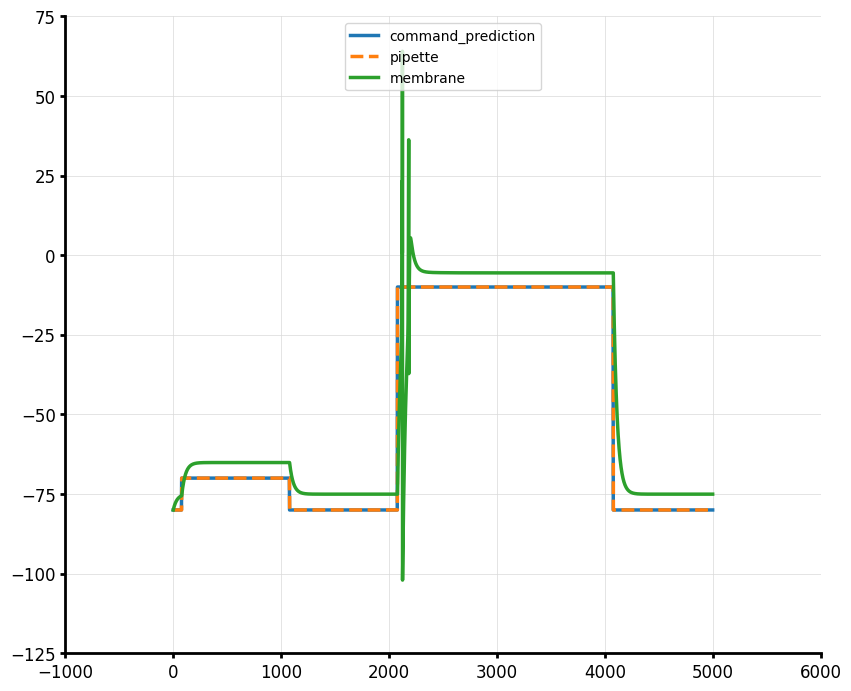

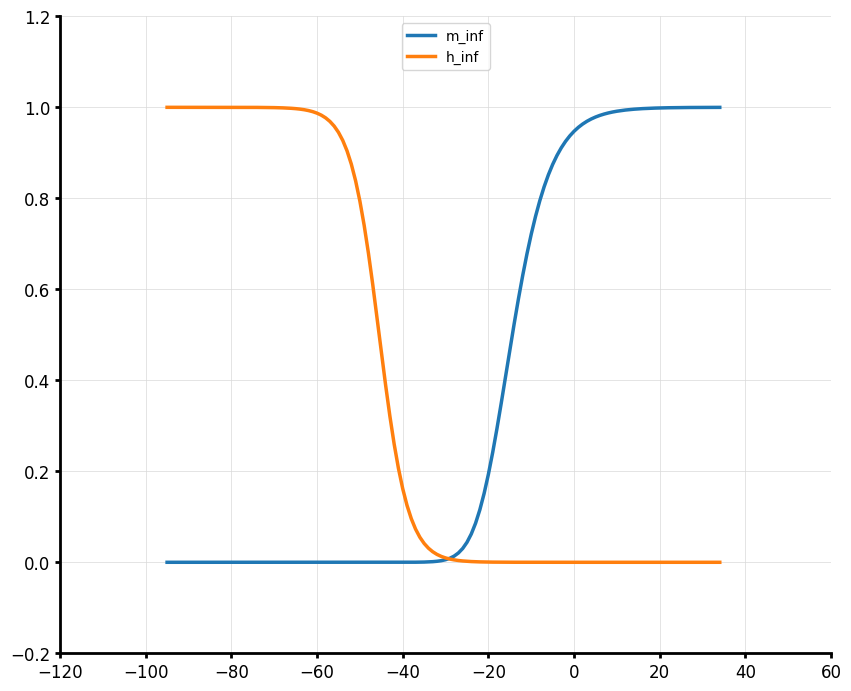

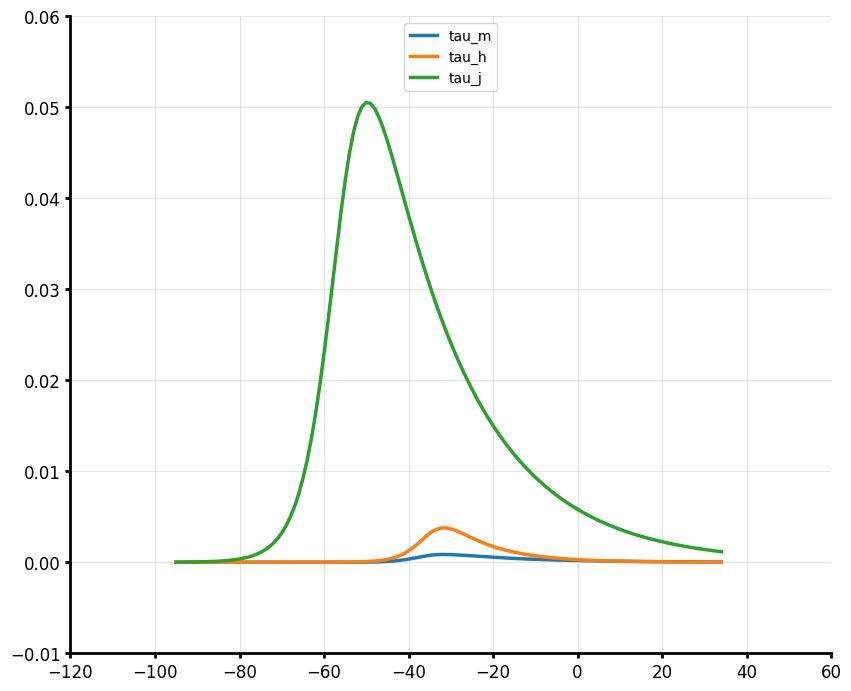

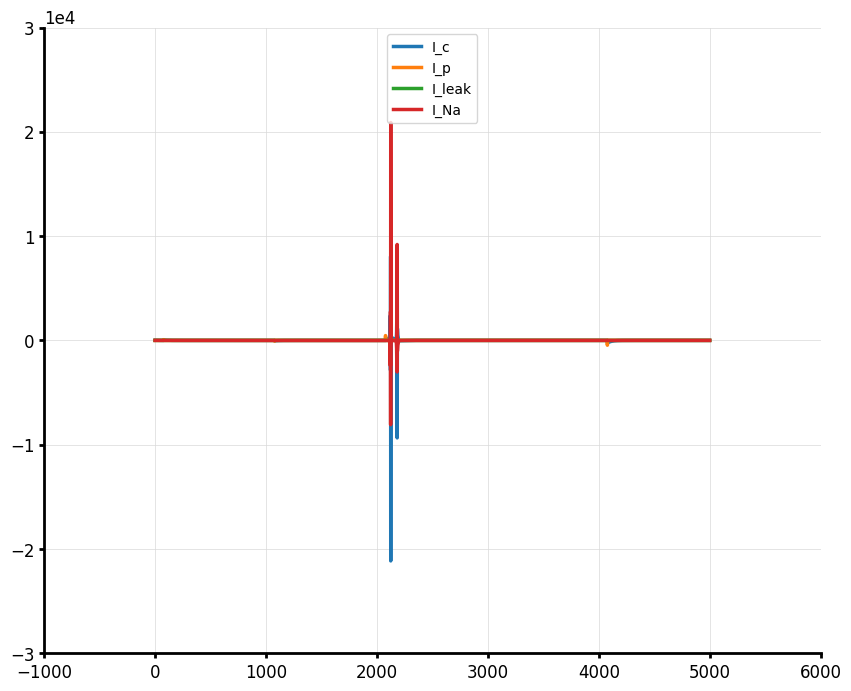

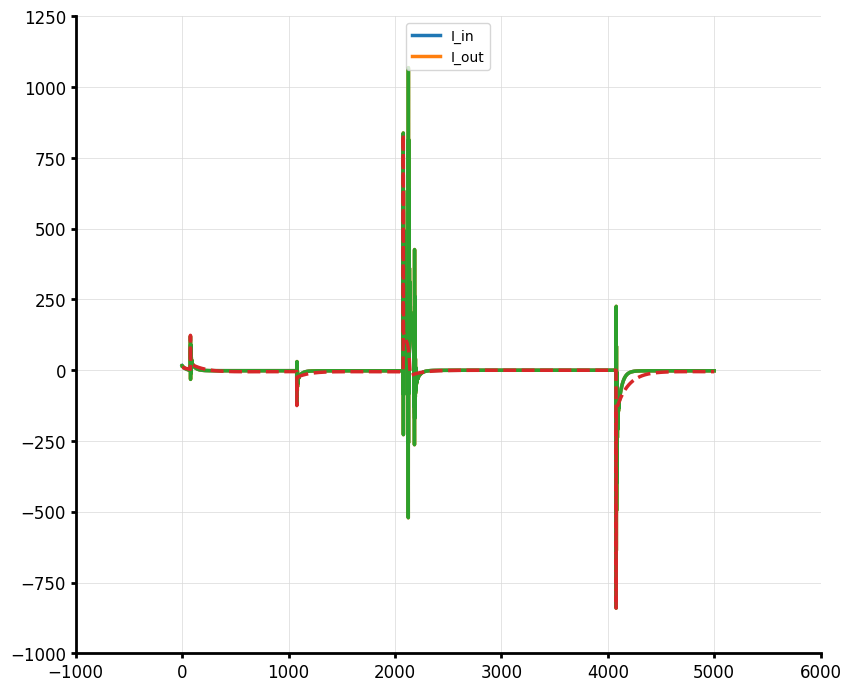

In [76]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [ ]:
%%time
res = scop.minimize(loss, x0,  args=(data, kwargs),bounds=bounds)

kwargs = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
             log_scale = True,
             graph = False)

<ipython-input-57-bcbb0bb09c25>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [ ]:
loss(res.x, data, kwargs)

In [ ]:
print('error in param = ', x_true_log - res.x)

In [ ]:
#%matplotlib notebook

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs), label = 'found data')
plt.plot(data, '--',label = 'initial data')
plt.legend()

 ### real_data_minimize


In [ ]:
def get_full_trace(a):
    data = pd.read_csv( a ,delimiter= '\t', header=None, skiprows = 11)
    for k in range(1,21):
        print(np.mean(data[k][:77]),np.mean(data[k][4877:]))
#get_full_trace('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf')

In [ ]:
def line(x,k,l):
    return k*x+l

In [ ]:
#x_true_log = np.load('one_start_scop_minimize.npy')
sample_weight = np.zeros(5000)
w1 = 1
w2 = 5
w3 = 10
#sample_weight[:]+= 1
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2400] += 50
    sample_weight[2400:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [ ]:
def no_drift(data):
    v = 1
    final_data = np.zeros(len(data)*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data[0])
    for k in range(1,len(data.columns)):
        x_0 = np.arange(dif)
        x = np.arange((k-1) * dif, k * dif)
        data_drift = data[k][list_drift]
        popt,pcov = scop.curve_fit(line, list_drift,data_drift)
        drift = line(x_0,*popt)[::v]
        final_data[(k-1) * dif : k * dif] = data[k] - drift
        #plt.plot(x[::v], data[k][::v])
        #plt.plot(x[::v], data[k][::v]-drift[::v])
        #plt.plot(x[::v], drift[::v])
    return final_data


In [25]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
real_data_small = real_data[14]
real_data_all = no_drift(real_data)#np.concatenate([real_data[k] for k in range(1,21)])
sample_weight_all = np.concatenate([sample_weight for k in range(1,21)])

#sample_weights = np.zeros(5000)
#sample_weights[2210:4000] += 1


#           C_f     C    a0_m   b0_m   s_m_1  s_m_2   a0_h   b0_h   s_h_1  s_h_2  a0_j   b0_j   s_j_1  s_j_2     R    R_f  g_max  g_leak v_half_m v_half_h  k_m   k_h    v_off
bounds = ([1e-18, 1e-13, 1e-8,  1e-8,  1e-8,  1e-8,   1e-8,  1e-8,  1e-8,  1e-8,  1e-8,  1e-8,  1e-8,  1e-8, 1e5,  1e3,  1e-10, 1e-10,  1e-2   ,  1e-2,   1e-4, 1e-4,  -50],
          [1e-11,  1e-10, 1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,   1e6,  1e15, 1e15, 1e10,  1e10,   100,      100,    1e2,  1e2,   50])
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:]))
                        , np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
kwargs_for_count = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight_all)


In [26]:
%%time
res = scop.minimize(loss, x_true_log, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',
               options={ 'adaptive':True})

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nik/.local/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 606, in minimize
    return _minimize_neldermead(fun, x0, args, callback, **options)
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 705, in _minimize_neldermead
    fxr = func(xr)
  File "/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py", line 427, in function_wrapper
    return function(*(wrapper_args + args))
  File "<ipython-input-11-96167d7ab3be>", line 5, in loss
    I_out = calculate_I_out(x, *args)
  File "<ipython-input-4-bcbb0bb09c25>", line 135, in calculate_I_out
    m_inf, h_inf, tau_m, tau_h, v_p, v_m, I_leak, I_Na = calculate_cicle(t,v_c, v_rev,y)
KeyboardInterrupt

During handling of the above exception, anothe

TypeError: object of type 'NoneType' has no len()

In [ ]:
loss(res.x, real_data_all, kwargs_for_count)

In [ ]:
#%matplotlib notebook

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs_for_count), label = 'calculated')
plt.plot(real_data_all,'.-', label = 'real_data')

plt.legend()


In [ ]:
x = calculate_I_out(res.x, kwargs_for_count) - real_data_all
x **= 2
x *= sample_weight_all
plt.plot(x, '.-', label = 'calculated')
#lt.xlim(2050,2200)

In [ ]:
np.sqrt(x.mean())

In [ ]:
np.sqrt(x[x <= 0.25e5].mean())

In [ ]:
#np.save('one_start_scop_minimize',res.x)

In [ ]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weights)
calculate_I_out(res.x, kwargs)
plt.plot(real_data_small, '--', label = 'real data')
plt.legend()

In [ ]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

### differential_evolution

In [ ]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=bounds,
                                  args=(data, kwargs_for_count),
                                  maxiter=1, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42)

In [ ]:
loss(res.x, real_data_small, kwargs_for_count)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')
#plt.xlim(0, 1000)

### dual_annealing

In [ ]:
%%time
#res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs_for_count), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')